In [1]:
import numpy as np
import cv2
import scipy.io
import os
from numpy.linalg import norm
from matplotlib import pyplot as plt
from numpy.linalg import det
from numpy.linalg import inv
from scipy.linalg import rq
from numpy.linalg import svd
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import sys
from scipy import ndimage, spatial
from tqdm.notebook import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from skimage import io, transform,data
from torchvision import transforms, utils
import numpy as np
import math
import glob
import matplotlib.pyplot as plt
import time
import os
import copy
import sklearn.svm
import cv2
from matplotlib import pyplot as plt
import numpy as np
from os.path import exists
import pandas as pd
import PIL
import random
from google.colab import drive
from sklearn.metrics.cluster import completeness_score
from sklearn.cluster import KMeans
from tqdm import tqdm, tqdm_notebook
from functools import partial
from torchsummary import summary
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler
import h5py as h5

#cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
#accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#print("Accelerator type = ",accelerator)
#print("Pytorch verision: ", torch.__version__)

In [2]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!pip install ipython-autotime

#%load_ext autotime

In [3]:
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

In [4]:
class Image:
    def __init__(self, img, position):
        
        self.img = img
        self.position = position

inlier_matchset = []
def features_matching(a,keypointlength,threshold):
  #threshold=0.2
  bestmatch=np.empty((keypointlength),dtype= np.int16)
  img1index=np.empty((keypointlength),dtype=np.int16)
  distance=np.empty((keypointlength))
  index=0
  for j in range(0,keypointlength):
    #For a descriptor fa in Ia, take the two closest descriptors fb1 and fb2 in Ib
    x=a[j]
    listx=x.tolist()
    x.sort()
    minval1=x[0]                                # min 
    minval2=x[1]                                # 2nd min
    itemindex1 = listx.index(minval1)           #index of min val    
    itemindex2 = listx.index(minval2)           #index of second min value 
    ratio=minval1/minval2                       #Ratio Test
    
    if ratio<threshold: 
      #Low distance ratio: fb1 can be a good match
      bestmatch[index]=itemindex1
      distance[index]=minval1
      img1index[index]=j
      index=index+1
  return  [cv2.DMatch(img1index[i],bestmatch[i].astype(int),distance[i]) for i in range(0,index)]
          
   
  
def compute_Homography(im1_pts,im2_pts):
  """
  im1_pts and im2_pts are 2×n matrices with
  4 point correspondences from the two images
  """
  num_matches=len(im1_pts)
  num_rows = 2 * num_matches
  num_cols = 9
  A_matrix_shape = (num_rows,num_cols)
  A = np.zeros(A_matrix_shape)
  a_index = 0
  for i in range(0,num_matches):
    (a_x, a_y) = im1_pts[i]
    (b_x, b_y) = im2_pts[i]
    row1 = [a_x, a_y, 1, 0, 0, 0, -b_x*a_x, -b_x*a_y, -b_x] # First row 
    row2 = [0, 0, 0, a_x, a_y, 1, -b_y*a_x, -b_y*a_y, -b_y] # Second row 

    # place the rows in the matrix
    A[a_index] = row1
    A[a_index+1] = row2

    a_index += 2
    
  U, s, Vt = np.linalg.svd(A)

  #s is a 1-D array of singular values sorted in descending order
  #U, Vt are unitary matrices
  #Rows of Vt are the eigenvectors of A^TA.
  #Columns of U are the eigenvectors of AA^T.
  H = np.eye(3)
  H = Vt[-1].reshape(3,3) # take the last row of the Vt matrix
  return H
  
  
def displayplot(img,title):
  
  plt.figure(figsize=(15,15))
  plt.title(title)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()

In [5]:
def get_inliers(f1, f2, matches, H, RANSACthresh):

  inlier_indices = []
  for i in range(len(matches)):
    queryInd = matches[i].queryIdx
    trainInd = matches[i].trainIdx

    #queryInd = matches[i][0]
    #trainInd = matches[i][1]

    queryPoint = np.array([f1[queryInd].pt[0],  f1[queryInd].pt[1], 1]).T 
    trans_query = H.dot(queryPoint) 

   
    comp1 = [trans_query[0]/trans_query[2], trans_query[1]/trans_query[2]] # normalize with respect to z
    comp2 = np.array(f2[trainInd].pt)[:2]
    

    if(np.linalg.norm(comp1-comp2) <= RANSACthresh): # check against threshold
      inlier_indices.append(i)
  return inlier_indices


def RANSAC_alg(f1, f2, matches, nRANSAC, RANSACthresh):

      
    minMatches = 4
    nBest = 0
    best_inliers = []
    H_estimate = np.eye(3,3)
    global inlier_matchset
    inlier_matchset=[]
    for iteration in range(nRANSAC):
      
        #Choose a minimal set of feature matches.
        matchSample = random.sample(matches, minMatches)
        
        #Estimate the Homography implied by these matches
        im1_pts=np.empty((minMatches,2))
        im2_pts=np.empty((minMatches,2))
        for i in range(0,minMatches):
          m = matchSample[i]
          im1_pts[i] = f1[m.queryIdx].pt
          im2_pts[i] = f2[m.trainIdx].pt
          #im1_pts[i] = f1[m[0]].pt
          #im2_pts[i] = f2[m[1]].pt             
          
        H_estimate=compute_Homography(im1_pts,im2_pts)
        
               
        # Calculate the inliers for the H
        inliers = get_inliers(f1, f2, matches, H_estimate, RANSACthresh)

        # if the number of inliers is higher than previous iterations, update the best estimates
        if len(inliers) > nBest:
            nBest= len(inliers)
            best_inliers = inliers

    print("Number of best inliers",len(best_inliers))
    for i in range(len(best_inliers)):
      inlier_matchset.append(matches[best_inliers[i]])
    
    # compute a homography given this set of matches
    im1_pts=np.empty((len(best_inliers),2))
    im2_pts=np.empty((len(best_inliers),2))
    for i in range(0,len(best_inliers)):
      m = inlier_matchset[i]
      im1_pts[i] = f1[m.queryIdx].pt
      im2_pts[i] = f2[m.trainIdx].pt
      #im1_pts[i] = f1[m[0]].pt
      #im2_pts[i] = f2[m[1]].pt

    M=compute_Homography(im1_pts,im2_pts)
    return M, best_inliers

In [6]:
tqdm = partial(tqdm, position=0, leave=True)

In [7]:
files_all=[]
for file in os.listdir("/content/drive/MyDrive/geotagged-images"):
    if file.endswith(".JPG"):
      files_all.append(file)


files_all.sort()
folder_path = '/content/drive/MyDrive/geotagged-images/'

#centre_file = folder_path + files_all[50]
left_files_path_rev = []
right_files_path = []


#Change this according to your dataset split

for file in files_all[:61]:
  left_files_path_rev.append(folder_path + file)

left_files_path = left_files_path_rev[::-1]

for file in files_all[60:120]:
  right_files_path.append(folder_path + file)

In [8]:
print(len(files_all))

297


In [9]:
from multiprocessing import Pool

In [10]:
import multiprocessing
print(multiprocessing.cpu_count())


2


In [11]:
gridsize = 8
clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(gridsize,gridsize))

images_left_bgr = []
images_right_bgr = []

images_left = []
images_right = []

for file in tqdm(left_files_path):
  left_image_sat= cv2.imread(file)
  lab = cv2.cvtColor(left_image_sat, cv2.COLOR_BGR2LAB)
  lab[...,0] = clahe.apply(lab[...,0])
  left_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  left_img = cv2.resize(left_image_sat,None,fx=0.75, fy=0.75, interpolation = cv2.INTER_CUBIC )
  images_left.append(cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_left_bgr.append(left_img)


for file in tqdm(right_files_path):
  right_image_sat= cv2.imread(file)
  lab = cv2.cvtColor(right_image_sat, cv2.COLOR_BGR2LAB)
  lab[...,0] = clahe.apply(lab[...,0])
  right_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  right_img = cv2.resize(right_image_sat,None,fx=0.75,fy=0.75, interpolation = cv2.INTER_CUBIC )
  images_right.append(cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_right_bgr.append(right_img)

100%|██████████| 60/60 [01:19<00:00,  1.32s/it]


In [12]:
Dataset = 'Small Village Dataset'

In [13]:
f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','w')
t0=time.time()
f.create_dataset('data',data=images_left_bgr + images_right_bgr)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize(f'drive/MyDrive/all_images_bgr_{Dataset}.h5')/1.e6,'MB')

HDF5  w/o comp.: 59.09611105918884 [s] ... size 3251.738624 MB


In [14]:
f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','w')
t0=time.time()
f.create_dataset('data',data=images_left + images_right)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize(f'drive/MyDrive/all_images_gray_{Dataset}.h5')/1.e6,'MB')

HDF5  w/o comp.: 60.00102233886719 [s] ... size 4335.650816 MB


In [15]:
del images_left_bgr,images_right_bgr

In [ ]:
#images_left_bgr_no_enhance = []
#images_right_bgr_no_enhance = []

#for file in tqdm(left_files_path):
#  left_image_sat= cv2.imread(file)
#  left_img = cv2.resize(left_image_sat,None,fx=0.35, fy=0.35, interpolation = cv2.INTER_CUBIC)
#  images_left_bgr_no_enhance.append(left_img)

#for file in tqdm(right_files_path):
# right_image_sat= cv2.imread(file)
#  right_img = cv2.resize(right_image_sat,None,fx=0.35,fy=0.35, interpolation = cv2.INTER_CUBIC)
#  images_right_bgr_no_enhance.append(right_img)

In [16]:
from timeit import default_timer as timer

In [17]:
time_all = []

In [18]:
num_kps_sift = []
num_kps_brisk = []
num_kps_agast = []
num_kps_kaze = []
num_kps_akaze = []
num_kps_orb = []
num_kps_mser = []
num_kps_daisy = []
num_kps_surfsift = []
num_kps_fast = []
num_kps_freak = []
num_kps_gftt = []
num_kps_star = []
num_kps_surf = []
num_kps_rootsift = []
num_kps_superpoint = []


BRISK

In [19]:
Threshl=60;
Octaves=6; 
#PatternScales=1.0f;

start = timer()

brisk = cv2.BRISK_create(Threshl,Octaves)


keypoints_all_left_brisk = []
descriptors_all_left_brisk = []
points_all_left_brisk=[]

keypoints_all_right_brisk = []
descriptors_all_right_brisk = []
points_all_right_brisk=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  brisk.compute(imgs, kpt)
  keypoints_all_left_brisk.append(kpt)
  descriptors_all_left_brisk.append(descrip)
  #points_all_left_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  brisk.compute(imgs, kpt)
  keypoints_all_right_brisk.append(kpt)
  descriptors_all_right_brisk.append(descrip)
  #points_all_right_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [02:14<00:00,  2.24s/it]


In [20]:
for j in tqdm(keypoints_all_left_brisk + keypoints_all_right_brisk[1:]):
  num_kps_brisk.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 379575.02it/s]


In [21]:
all_feat_brisk_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_brisk):
  all_feat_brisk_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_brisk[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_brisk_left_each.append(temp)
  all_feat_brisk_left.append(all_feat_brisk_left_each)

In [22]:
all_feat_brisk_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_brisk):
  all_feat_brisk_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_brisk[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_brisk_right_each.append(temp)
  all_feat_brisk_right.append(all_feat_brisk_right_each)

In [23]:
del keypoints_all_left_brisk, keypoints_all_right_brisk, descriptors_all_left_brisk, descriptors_all_right_brisk

In [24]:
import pickle
Fdb = open('all_feat_brisk_left.dat', 'wb')
pickle.dump(all_feat_brisk_left,Fdb,-1)
Fdb.close()

In [25]:
import pickle
Fdb = open('all_feat_brisk_right.dat', 'wb')
pickle.dump(all_feat_brisk_right,Fdb,-1)
Fdb.close()

In [26]:
del Fdb, all_feat_brisk_left, all_feat_brisk_right

ORB

In [27]:
orb = cv2.ORB_create(20000)

start = timer()


keypoints_all_left_orb = []
descriptors_all_left_orb = []
points_all_left_orb=[]

keypoints_all_right_orb = []
descriptors_all_right_orb = []
points_all_right_orb=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()    
  kpt = orb.detect(imgs,None)
  kpt,descrip =  orb.compute(imgs, kpt)
  keypoints_all_left_orb.append(kpt)
  descriptors_all_left_orb.append(descrip)
  #points_all_left_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = orb.detect(imgs,None)
  kpt,descrip =  orb.compute(imgs, kpt)
  keypoints_all_right_orb.append(kpt)
  descriptors_all_right_orb.append(descrip)
  #points_all_right_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [00:57<00:00,  1.04it/s]


In [28]:
for j in tqdm(keypoints_all_left_orb + keypoints_all_right_orb[1:]):
  num_kps_orb.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 295894.46it/s]


In [29]:
all_feat_orb_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_orb):
  all_feat_orb_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_orb[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_orb_left_each.append(temp)
  all_feat_orb_left.append(all_feat_orb_left_each)

In [30]:
all_feat_orb_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_orb):
  all_feat_orb_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_orb[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_orb_right_each.append(temp)
  all_feat_orb_right.append(all_feat_orb_right_each)

In [31]:
del keypoints_all_left_orb, keypoints_all_right_orb, descriptors_all_left_orb, descriptors_all_right_orb

In [32]:
import pickle
Fdb = open('all_feat_orb_left.dat', 'wb')
pickle.dump(all_feat_orb_left,Fdb,-1)
Fdb.close()

In [33]:
import pickle
Fdb = open('all_feat_orb_right.dat', 'wb')
pickle.dump(all_feat_orb_right,Fdb,-1)
Fdb.close()

In [34]:
del Fdb, all_feat_orb_left, all_feat_orb_right

KAZE


In [35]:
start = timer()

kaze = cv2.KAZE_create()


keypoints_all_left_kaze = []
descriptors_all_left_kaze = []
points_all_left_kaze=[]

keypoints_all_right_kaze = []
descriptors_all_right_kaze = []
points_all_right_kaze=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = kaze.detect(imgs,None)
  kpt,descrip =  kaze.compute(imgs, kpt)
  keypoints_all_left_kaze.append(kpt)
  descriptors_all_left_kaze.append(descrip)
  #points_all_left_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = kaze.detect(imgs,None)
  kpt,descrip =  kaze.compute(imgs, kpt)
  keypoints_all_right_kaze.append(kpt)
  descriptors_all_right_kaze.append(descrip)
  #points_all_right_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [32:27<00:00, 32.46s/it]


In [36]:
for j in tqdm(keypoints_all_left_kaze + keypoints_all_right_kaze[1:]):
  num_kps_kaze.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 59012.37it/s]


In [37]:
all_feat_kaze_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_kaze):
  all_feat_kaze_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_kaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_kaze_left_each.append(temp)
  all_feat_kaze_left.append(all_feat_kaze_left_each)

In [38]:
all_feat_kaze_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_kaze):
  all_feat_kaze_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_kaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_kaze_right_each.append(temp)
  all_feat_kaze_right.append(all_feat_kaze_right_each)

In [39]:
del keypoints_all_left_kaze, keypoints_all_right_kaze, descriptors_all_left_kaze, descriptors_all_right_kaze

In [ ]:
import pickle
Fdb = open('all_feat_kaze_left.dat', 'wb')
pickle.dump(all_feat_kaze_left,Fdb,-1)
Fdb.close()

In [ ]:
import pickle
Fdb = open('all_feat_kaze_right.dat', 'wb')
pickle.dump(all_feat_kaze_right,Fdb,-1)
Fdb.close()

In [ ]:
del Fdb, all_feat_kaze_left, all_feat_kaze_right

AKAZE

In [ ]:
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

In [ ]:
start = timer()

akaze = cv2.AKAZE_create()


keypoints_all_left_akaze = []
descriptors_all_left_akaze = []
points_all_left_akaze=[]

keypoints_all_right_akaze = []
descriptors_all_right_akaze = []
points_all_right_akaze=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = akaze.detect(imgs,None)
  kpt,descrip =  akaze.compute(imgs, kpt)
  keypoints_all_left_akaze.append(kpt)
  descriptors_all_left_akaze.append(descrip)
  #points_all_left_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = akaze.detect(imgs,None)
  kpt,descrip = akaze.compute(imgs, kpt)
  keypoints_all_right_akaze.append(kpt)
  descriptors_all_right_akaze.append(descrip)
  #points_all_right_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [01:02<00:00,  1.04s/it]


In [ ]:
for j in tqdm(keypoints_all_left_akaze + keypoints_all_right_akaze[1:]):
  num_kps_akaze.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 145341.17it/s]


In [ ]:
all_feat_akaze_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_akaze):
  all_feat_akaze_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_akaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_akaze_left_each.append(temp)
  all_feat_akaze_left.append(all_feat_akaze_left_each)

In [ ]:
all_feat_akaze_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_akaze):
  all_feat_akaze_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_akaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_akaze_right_each.append(temp)
  all_feat_akaze_right.append(all_feat_akaze_right_each)

In [ ]:
del keypoints_all_left_akaze, keypoints_all_right_akaze, descriptors_all_left_akaze, descriptors_all_right_akaze

In [ ]:
import pickle
Fdb = open('all_feat_akaze_left.dat', 'wb')
pickle.dump(all_feat_akaze_left,Fdb,-1)
Fdb.close()

In [ ]:
import pickle
Fdb = open('all_feat_akaze_right.dat', 'wb')
pickle.dump(all_feat_akaze_right,Fdb,-1)
Fdb.close()

In [ ]:
del Fdb, all_feat_akaze_left, all_feat_akaze_right


STAR + BRIEF

In [35]:
start = timer()

star = cv2.xfeatures2d.StarDetector_create()
brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()

keypoints_all_left_star = []
descriptors_all_left_brief = []
points_all_left_star=[]

keypoints_all_right_star = []
descriptors_all_right_brief = []
points_all_right_star=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = star.detect(imgs,None)
  kpt,descrip =  brief.compute(imgs, kpt)
  keypoints_all_left_star.append(kpt)
  descriptors_all_left_brief.append(descrip)
  #points_all_left_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = star.detect(imgs,None)
  kpt,descrip =  brief.compute(imgs, kpt)
  keypoints_all_right_star.append(kpt)
  descriptors_all_right_brief.append(descrip)
  #points_all_right_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [02:31<00:00,  2.52s/it]


In [36]:
for j in tqdm(keypoints_all_left_star + keypoints_all_right_star[1:]):
  num_kps_star.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 46560.27it/s]


In [37]:
all_feat_star_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_star):
  all_feat_star_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_brief[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_star_left_each.append(temp)
  all_feat_star_left.append(all_feat_star_left_each)

In [38]:
all_feat_star_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_star):
  all_feat_star_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_brief[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_star_right_each.append(temp)
  all_feat_star_right.append(all_feat_star_right_each)

In [39]:
del keypoints_all_left_star, keypoints_all_right_star, descriptors_all_left_brief, descriptors_all_right_brief

In [40]:
import pickle
Fdb = open('all_feat_star_left.dat', 'wb')
pickle.dump(all_feat_star_left,Fdb,-1)
Fdb.close()

In [41]:
import pickle
Fdb = open('all_feat_star_right.dat', 'wb')
pickle.dump(all_feat_star_right,Fdb,-1)
Fdb.close()

In [42]:
del Fdb, all_feat_star_left, all_feat_star_right


BRISK + FREAK

In [43]:
start = timer()

Threshl=60;
Octaves=8; 
#PatternScales=1.0f;
brisk = cv2.BRISK_create(Threshl,Octaves)

freak = cv2.xfeatures2d.FREAK_create()
keypoints_all_left_freak = []
descriptors_all_left_freak = []
points_all_left_freak=[]

keypoints_all_right_freak = []
descriptors_all_right_freak = []
points_all_right_freak=[]


for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = brisk.detect(imgs)
  kpt,descrip =  freak.compute(imgs, kpt)
  keypoints_all_left_freak.append(kpt)
  descriptors_all_left_freak.append(descrip)
  #points_all_left_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  freak.compute(imgs, kpt)
  keypoints_all_right_freak.append(kpt)
  descriptors_all_right_freak.append(descrip)
  #points_all_right_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [02:09<00:00,  2.16s/it]


In [44]:
for j in tqdm(keypoints_all_left_freak + keypoints_all_right_freak[1:]):
  num_kps_freak.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 277309.36it/s]


In [45]:
all_feat_freak_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_freak):
  all_feat_freak_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_freak[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_freak_left_each.append(temp)
  all_feat_freak_left.append(all_feat_freak_left_each)

In [46]:
all_feat_freak_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_freak):
  all_feat_freak_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_freak[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_freak_right_each.append(temp)
  all_feat_freak_right.append(all_feat_freak_right_each)

In [47]:
del keypoints_all_left_freak, keypoints_all_right_freak, descriptors_all_left_freak, descriptors_all_right_freak

In [48]:
import pickle
Fdb = open('all_feat_freak_left.dat', 'wb')
pickle.dump(all_feat_freak_left,Fdb,-1)
Fdb.close()

In [49]:
import pickle
Fdb = open('all_feat_freak_right.dat', 'wb')
pickle.dump(all_feat_freak_right,Fdb,-1)
Fdb.close()

In [50]:
del Fdb, all_feat_freak_left, all_feat_freak_right

MSER + SIFT

In [ ]:
'''
start = timer()

mser = cv2.MSER_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_mser = []
descriptors_all_left_mser = []
points_all_left_mser=[]

keypoints_all_right_mser = []
descriptors_all_right_mser = []
points_all_right_mser=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = mser.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_mser.append(kpt)
  descriptors_all_left_mser.append(descrip)
  #points_all_left_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = mser.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_mser.append(kpt)
  descriptors_all_right_mser.append(descrip)
  #points_all_right_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_mser + keypoints_all_right_mser[1:]):
  num_kps_mser.append(len(j))

In [ ]:
'''
all_feat_mser_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_mser):
  all_feat_mser_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_mser[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_mser_left_each.append(temp)
  all_feat_mser_left.append(all_feat_mser_left_each)

In [ ]:
'''
all_feat_mser_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_mser):
  all_feat_mser_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_mser[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_mser_right_each.append(temp)
  all_feat_mser_right.append(all_feat_mser_right_each)

In [ ]:
'''
del keypoints_all_left_mser, keypoints_all_right_mser, descriptors_all_left_mser, descriptors_all_right_mser

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_left.dat', 'wb')
pickle.dump(all_feat_mser_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_right.dat', 'wb')
pickle.dump(all_feat_mser_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_mser_left, all_feat_mser_right

AGAST + SIFT

In [ ]:
start = timer()

agast = cv2.AgastFeatureDetector_create(threshold = 40)
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_agast = []
descriptors_all_left_agast = []
points_all_left_agast=[]

keypoints_all_right_agast = []
descriptors_all_right_agast = []
points_all_right_agast=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = agast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_agast.append(kpt)
  descriptors_all_left_agast.append(descrip)
  #points_all_left_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = agast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_agast.append(kpt)
  descriptors_all_right_agast.append(descrip)
  #points_all_right_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [03:25<00:00,  3.42s/it]


In [ ]:
for j in tqdm(keypoints_all_left_agast + keypoints_all_right_agast[1:]):
  num_kps_agast.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 262007.54it/s]


In [ ]:
all_feat_agast_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_agast):
  all_feat_agast_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_agast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_agast_left_each.append(temp)
  all_feat_agast_left.append(all_feat_agast_left_each)

In [ ]:
all_feat_agast_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_agast):
  all_feat_agast_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_agast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_agast_right_each.append(temp)
  all_feat_agast_right.append(all_feat_agast_right_each)

In [ ]:
del keypoints_all_left_agast, keypoints_all_right_agast, descriptors_all_left_agast, descriptors_all_right_agast

In [ ]:
import pickle
Fdb = open('all_feat_agast_left.dat', 'wb')
pickle.dump(all_feat_agast_left,Fdb,-1)
Fdb.close()

In [ ]:
del Fdb, all_feat_agast_left

In [ ]:
import pickle
Fdb = open('all_feat_agast_right.dat', 'wb')
pickle.dump(all_feat_agast_right,Fdb,-1)
Fdb.close()

In [ ]:
del Fdb, all_feat_agast_right

FAST + SIFT

In [ ]:
'''
start = timer()


fast = cv2.FastFeatureDetector_create(threshold=40)
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_fast = []
descriptors_all_left_fast = []
points_all_left_fast=[]

keypoints_all_right_fast = []
descriptors_all_right_fast = []
points_all_right_fast=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = fast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_fast.append(kpt)
  descriptors_all_left_fast.append(descrip)
  #points_all_left_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = fast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_fast.append(kpt)
  descriptors_all_right_fast.append(descrip)
  #points_all_right_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_fast + keypoints_all_right_fast[1:]):
  num_kps_fast.append(len(j))

In [ ]:
'''
all_feat_fast_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_fast):
  all_feat_fast_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_fast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_fast_left_each.append(temp)
  all_feat_fast_left.append(all_feat_fast_left_each)

In [ ]:
'''
all_feat_fast_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_fast):
  all_feat_fast_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_fast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_fast_right_each.append(temp)
  all_feat_fast_right.append(all_feat_fast_right_each)

In [ ]:
'''
del keypoints_all_left_fast, keypoints_all_right_fast, descriptors_all_left_fast, descriptors_all_right_fast

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_left.dat', 'wb')
pickle.dump(all_feat_fast_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_right.dat', 'wb')
pickle.dump(all_feat_fast_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_fast_left, all_feat_fast_right

GFTT + SIFT

In [ ]:
'''
start = timer()

gftt = cv2.GFTTDetector_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_gftt = []
descriptors_all_left_gftt = []
points_all_left_gftt=[]

keypoints_all_right_gftt = []
descriptors_all_right_gftt = []
points_all_right_gftt=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = gftt.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_gftt.append(kpt)
  descriptors_all_left_gftt.append(descrip)
  #points_all_left_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = gftt.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_gftt.append(kpt)
  descriptors_all_right_gftt.append(descrip)
  #points_all_right_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_gftt + keypoints_all_right_gftt[1:]):
  num_kps_gftt.append(len(j))

In [ ]:
'''
all_feat_gftt_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_gftt):
  all_feat_gftt_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_gftt[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_gftt_left_each.append(temp)
  all_feat_gftt_left.append(all_feat_gftt_left_each)

In [ ]:
'''
all_feat_gftt_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_gftt):
  all_feat_gftt_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_gftt[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_gftt_right_each.append(temp)
  all_feat_gftt_right.append(all_feat_gftt_right_each)

In [ ]:
'''
del keypoints_all_left_gftt, keypoints_all_right_gftt, descriptors_all_left_gftt, descriptors_all_right_gftt

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_left.dat', 'wb')
pickle.dump(all_feat_gftt_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_right.dat', 'wb')
pickle.dump(all_feat_gftt_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_gftt_left, all_feat_gftt_right

DAISY+SIFT

In [ ]:
'''
start = timer()

daisy = cv2.xfeatures2d.DAISY_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_daisy = []
descriptors_all_left_daisy = []
points_all_left_daisy=[]

keypoints_all_right_daisy = []
descriptors_all_right_daisy = []
points_all_right_daisy=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = sift.detect(imgs,None)
  kpt,descrip =  daisy.compute(imgs, kpt)
  keypoints_all_left_daisy.append(kpt)
  descriptors_all_left_daisy.append(descrip)
  #points_all_left_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  daisy.compute(imgs, kpt)
  keypoints_all_right_daisy.append(kpt)
  descriptors_all_right_daisy.append(descrip)
  #points_all_right_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_daisy + keypoints_all_right_daisy[1:]):
  num_kps_daisy.append(len(j))

In [ ]:
'''
all_feat_daisy_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_daisy):
  all_feat_daisy_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_daisy[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_daisy_left_each.append(temp)
  all_feat_daisy_left.append(all_feat_daisy_left_each)

In [ ]:
'''
all_feat_daisy_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_daisy):
  all_feat_daisy_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_daisy[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_daisy_right_each.append(temp)
  all_feat_daisy_right.append(all_feat_daisy_right_each)

In [ ]:
'''
del keypoints_all_left_daisy, keypoints_all_right_daisy, descriptors_all_left_daisy, descriptors_all_right_daisy

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_left.dat', 'wb')
pickle.dump(all_feat_daisy_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_right.dat', 'wb')
pickle.dump(all_feat_daisy_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_daisy_left, all_feat_daisy_right

SURF + SIFT

In [ ]:
'''
start = timer()

surf = cv2.xfeatures2d.SURF_create(upright=1)
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_surfsift = []
descriptors_all_left_surfsift = []
points_all_left_surfsift=[]

keypoints_all_right_surfsift = []
descriptors_all_right_surfsift = []
points_all_right_surfsift=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = surf.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_surfsift.append(kpt)
  descriptors_all_left_surfsift.append(descrip)
  #points_all_left_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_surfsift.append(kpt)
  descriptors_all_right_surfsift.append(descrip)
  #points_all_right_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_surfsift + keypoints_all_right_surfsift[1:]):
  num_kps_surfsift.append(len(j))

In [ ]:
'''
all_feat_surfsift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_surfsift):
  all_feat_surfsift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_surfsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surfsift_left_each.append(temp)
  all_feat_surfsift_left.append(all_feat_surfsift_left_each)

In [ ]:
'''
all_feat_surfsift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_surfsift):
  all_feat_surfsift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_surfsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surfsift_right_each.append(temp)
  all_feat_surfsift_right.append(all_feat_surfsift_right_each)

In [ ]:
'''
del keypoints_all_left_surfsift, keypoints_all_right_surfsift, descriptors_all_left_surfsift, descriptors_all_right_surfsift

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_left.dat', 'wb')
pickle.dump(all_feat_surfsift_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_right.dat', 'wb')
pickle.dump(all_feat_surfsift_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_surfsift_left, all_feat_surfsift_right

SIFT

In [ ]:
'''
print(len(left_files_path))

In [ ]:
'''
print(len(right_files_path))

In [ ]:
# H5 file w/o compression
#t0=time.time()
#f=h5.File('drive/MyDrive/all_images_bgr_sift.h5','r')
#print('HDF5  w/o comp.: data shape =',len(f['data'][0]),time.time()-t0,'[s]')
#f.close()

In [ ]:
#del f

In [ ]:
'''
start = timer()

sift = cv2.xfeatures2d.SIFT_create()
keypoints_all_left_sift = []
descriptors_all_left_sift = []
points_all_left_sift=[]

keypoints_all_right_sift = []
descriptors_all_right_sift = []
points_all_right_sift=[]


for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()
  kpt = sift.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_sift.append(kpt)
  descriptors_all_left_sift.append(descrip)
  #points_all_left_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()
  kpt = sift.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_sift.append(kpt)
  descriptors_all_right_sift.append(descrip)
  #points_all_right_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_sift + keypoints_all_right_sift[1:]):
  num_kps_sift.append(len(j))

In [ ]:
'''
all_feat_sift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_sift):
  all_feat_sift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_sift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_sift_left_each.append(temp)
  all_feat_sift_left.append(all_feat_sift_left_each)

In [ ]:
'''
all_feat_sift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_sift):
  all_feat_sift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_sift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_sift_right_each.append(temp)
  all_feat_sift_right.append(all_feat_sift_right_each)

In [ ]:
'''
del keypoints_all_left_sift, keypoints_all_right_sift, descriptors_all_left_sift, descriptors_all_right_sift

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_left.dat', 'wb')
pickle.dump(all_feat_sift_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_right.dat', 'wb')
pickle.dump(all_feat_sift_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_sift_left, all_feat_sift_right

In [ ]:
#del keypoints_all_right_sift, keypoints_all_left_sift, descriptors_all_right_sift, descriptors_all_left_sift, points_all_right_sift, points_all_left_sift

SURF

In [ ]:
'''
start = timer()

surf  = cv2.xfeatures2d.SURF_create(upright=1)
keypoints_all_left_surf = []
descriptors_all_left_surf = []
points_all_left_surf=[]

keypoints_all_right_surf = []
descriptors_all_right_surf = []
points_all_right_surf=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  surf.compute(imgs, kpt)
  keypoints_all_left_surf.append(kpt)
  descriptors_all_left_surf.append(descrip)
  #points_all_left_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  surf.compute(imgs, kpt)
  keypoints_all_right_surf.append(kpt)
  descriptors_all_right_surf.append(descrip)
  #points_all_right_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_surf + keypoints_all_right_surf[1:]):
  num_kps_surf.append(len(j))

In [ ]:
'''
all_feat_surf_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_surf):
  all_feat_surf_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_surf[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surf_left_each.append(temp)
  all_feat_surf_left.append(all_feat_surf_left_each)

In [ ]:
'''
all_feat_surf_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_surf):
  all_feat_surf_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_surf[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surf_right_each.append(temp)
  all_feat_surf_right.append(all_feat_surf_right_each)

In [ ]:
'''
del keypoints_all_left_surf, keypoints_all_right_surf, descriptors_all_left_surf, descriptors_all_right_surf

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_left.dat', 'wb')
pickle.dump(all_feat_surf_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_right.dat', 'wb')
pickle.dump(all_feat_surf_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_surf_left, all_feat_surf_right

ROOTSIFT

In [ ]:
class RootSIFT:
  def __init__(self):
    # initialize the SIFT feature extractor
    #self.extractor = cv2.DescriptorExtractor_create("SIFT")
    self.sift = cv2.xfeatures2d.SIFT_create()

  def compute(self, image, kps, eps=1e-7):
    # compute SIFT descriptors
    (kps, descs) = self.sift.compute(image, kps)

    # if there are no keypoints or descriptors, return an empty tuple
    if len(kps) == 0:
      return ([], None)

    # apply the Hellinger kernel by first L1-normalizing, taking the
    # square-root, and then L2-normalizing
    descs /= (np.linalg.norm(descs, axis=0, ord=2) + eps)
    descs /= (descs.sum(axis=0) + eps)
    descs = np.sqrt(descs)
    #descs /= (np.linalg.norm(descs, axis=0, ord=2) + eps)

    # return a tuple of the keypoints and descriptors
    return (kps, descs)

In [ ]:
start = timer()

sift = cv2.xfeatures2d.SIFT_create()
rootsift = RootSIFT()
keypoints_all_left_rootsift = []
descriptors_all_left_rootsift = []
points_all_left_rootsift=[]

keypoints_all_right_rootsift = []
descriptors_all_right_rootsift = []
points_all_right_rootsift=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  rootsift.compute(imgs, kpt)
  keypoints_all_left_rootsift.append(kpt)
  descriptors_all_left_rootsift.append(descrip)
  #points_all_left_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  rootsift.compute(imgs, kpt)
  keypoints_all_right_rootsift.append(kpt)
  descriptors_all_right_rootsift.append(descrip)
  #points_all_right_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [02:08<00:00,  2.14s/it]


In [ ]:
for j in tqdm(keypoints_all_left_rootsift + keypoints_all_right_rootsift[1:]):
  num_kps_rootsift.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 49388.33it/s]


In [ ]:
all_feat_rootsift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_rootsift):
  all_feat_rootsift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_rootsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_rootsift_left_each.append(temp)
  all_feat_rootsift_left.append(all_feat_rootsift_left_each)

In [ ]:
all_feat_rootsift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_rootsift):
  all_feat_rootsift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_rootsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_rootsift_right_each.append(temp)
  all_feat_rootsift_right.append(all_feat_rootsift_right_each)

In [ ]:
del keypoints_all_left_rootsift, keypoints_all_right_rootsift, descriptors_all_left_rootsift, descriptors_all_right_rootsift

In [ ]:
import pickle
Fdb = open('all_feat_rootsift_left.dat', 'wb')
pickle.dump(all_feat_rootsift_left,Fdb,-1)
Fdb.close()

In [ ]:
import pickle
Fdb = open('all_feat_rootsift_right.dat', 'wb')
pickle.dump(all_feat_rootsift_right,Fdb,-1)
Fdb.close()

In [ ]:
del Fdb, all_feat_rootsift_left, all_feat_rootsift_right

SuperPoint

In [ ]:
'''
!git clone https://github.com/magicleap/SuperPointPretrainedNetwork.git

In [ ]:
'''
weights_path = 'SuperPointPretrainedNetwork/superpoint_v1.pth'

cuda = 'True'

In [ ]:
'''
def to_kpts(pts, size=1):
  return [cv2.KeyPoint(pt[0], pt[1], size) for pt in pts]

In [ ]:
'''
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.cuda.empty_cache()

class SuperPointNet(nn.Module):
    def __init__(self):
        super(SuperPointNet, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        c1, c2, c3, c4, c5, d1 = 64, 64, 128, 128, 256, 256
        # Shared Encoder.
        self.conv1a = nn.Conv2d(1, c1, kernel_size=3, stride=1, padding=1)
        self.conv1b = nn.Conv2d(c1, c1, kernel_size=3, stride=1, padding=1)
        self.conv2a = nn.Conv2d(c1, c2, kernel_size=3, stride=1, padding=1)
        self.conv2b = nn.Conv2d(c2, c2, kernel_size=3, stride=1, padding=1)
        self.conv3a = nn.Conv2d(c2, c3, kernel_size=3, stride=1, padding=1)
        self.conv3b = nn.Conv2d(c3, c3, kernel_size=3, stride=1, padding=1)
        self.conv4a = nn.Conv2d(c3, c4, kernel_size=3, stride=1, padding=1)
        self.conv4b = nn.Conv2d(c4, c4, kernel_size=3, stride=1, padding=1)
        # Detector Head.
        self.convPa = nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
        self.convPb = nn.Conv2d(c5, 65, kernel_size=1, stride=1, padding=0)
        # Descriptor Head.
        self.convDa = nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
        self.convDb = nn.Conv2d(c5, d1, kernel_size=1, stride=1, padding=0)

    def forward(self, x):

        # Shared Encoder.
        x = self.relu(self.conv1a(x))
        x = self.relu(self.conv1b(x))
        x = self.pool(x)
        x = self.relu(self.conv2a(x))
        x = self.relu(self.conv2b(x))
        x = self.pool(x)
        x = self.relu(self.conv3a(x))
        x = self.relu(self.conv3b(x))
        x = self.pool(x)
        x = self.relu(self.conv4a(x))
        x = self.relu(self.conv4b(x))
        # Detector Head.
        cPa = self.relu(self.convPa(x))
        semi = self.convPb(cPa)
        # Descriptor Head.
        cDa = self.relu(self.convDa(x))
        desc = self.convDb(cDa)
        dn = torch.norm(desc, p=2, dim=1) # Compute the norm.
        desc = desc.div(torch.unsqueeze(dn, 1)) # Divide by norm to normalize.
        return semi, desc


class SuperPointFrontend(object):
    def __init__(self, weights_path, nms_dist, conf_thresh, nn_thresh,cuda=True):
        self.name = 'SuperPoint'
        self.cuda = cuda
        self.nms_dist = nms_dist
        self.conf_thresh = conf_thresh
        self.nn_thresh = nn_thresh # L2 descriptor distance for good match.
        self.cell = 8 # Size of each output cell. Keep this fixed.
        self.border_remove = 4 # Remove points this close to the border.

        # Load the network in inference mode.
        self.net = SuperPointNet()
        if cuda:
          # Train on GPU, deploy on GPU.
            self.net.load_state_dict(torch.load(weights_path))
            self.net = self.net.cuda()
        else:
          # Train on GPU, deploy on CPU.
            self.net.load_state_dict(torch.load(weights_path, map_location=lambda storage, loc: storage))
        self.net.eval()

    def nms_fast(self, in_corners, H, W, dist_thresh):

        grid = np.zeros((H, W)).astype(int) # Track NMS data.
        inds = np.zeros((H, W)).astype(int) # Store indices of points.
        # Sort by confidence and round to nearest int.
        inds1 = np.argsort(-in_corners[2,:])
        corners = in_corners[:,inds1]
        rcorners = corners[:2,:].round().astype(int) # Rounded corners.
        # Check for edge case of 0 or 1 corners.
        if rcorners.shape[1] == 0:
            return np.zeros((3,0)).astype(int), np.zeros(0).astype(int)
        if rcorners.shape[1] == 1:
            out = np.vstack((rcorners, in_corners[2])).reshape(3,1)
            return out, np.zeros((1)).astype(int)
        # Initialize the grid.
        for i, rc in enumerate(rcorners.T):
            grid[rcorners[1,i], rcorners[0,i]] = 1
            inds[rcorners[1,i], rcorners[0,i]] = i
        # Pad the border of the grid, so that we can NMS points near the border.
        pad = dist_thresh
        grid = np.pad(grid, ((pad,pad), (pad,pad)), mode='constant')
        # Iterate through points, highest to lowest conf, suppress neighborhood.
        count = 0
        for i, rc in enumerate(rcorners.T):
          # Account for top and left padding.
            pt = (rc[0]+pad, rc[1]+pad)
            if grid[pt[1], pt[0]] == 1: # If not yet suppressed.
                grid[pt[1]-pad:pt[1]+pad+1, pt[0]-pad:pt[0]+pad+1] = 0
                grid[pt[1], pt[0]] = -1
                count += 1
        # Get all surviving -1's and return sorted array of remaining corners.
        keepy, keepx = np.where(grid==-1)
        keepy, keepx = keepy - pad, keepx - pad
        inds_keep = inds[keepy, keepx]
        out = corners[:, inds_keep]
        values = out[-1, :]
        inds2 = np.argsort(-values)
        out = out[:, inds2]
        out_inds = inds1[inds_keep[inds2]]
        return out, out_inds

    def run(self, img):
        assert img.ndim == 2 #Image must be grayscale.
        assert img.dtype == np.float32 #Image must be float32.
        H, W = img.shape[0], img.shape[1]
        inp = img.copy()
        inp = (inp.reshape(1, H, W))
        inp = torch.from_numpy(inp)
        inp = torch.autograd.Variable(inp).view(1, 1, H, W)
        if self.cuda:
            inp = inp.cuda()
        # Forward pass of network.
        outs = self.net.forward(inp)
        semi, coarse_desc = outs[0], outs[1]
        # Convert pytorch -> numpy.
        semi = semi.data.cpu().numpy().squeeze()
        
        # --- Process points.
        dense = np.exp(semi) # Softmax.
        dense = dense / (np.sum(dense, axis=0)+.00001) # Should sum to 1.
        nodust = dense[:-1, :, :]
        # Reshape to get full resolution heatmap.
        Hc = int(H / self.cell)
        Wc = int(W / self.cell)
        nodust = np.transpose(nodust, [1, 2, 0])
        heatmap = np.reshape(nodust, [Hc, Wc, self.cell, self.cell])
        heatmap = np.transpose(heatmap, [0, 2, 1, 3])
        heatmap = np.reshape(heatmap, [Hc*self.cell, Wc*self.cell]) 
        prob_map = heatmap/np.sum(np.sum(heatmap))
        
        return heatmap, coarse_desc


    def key_pt_sampling(self, img, heat_map, coarse_desc, sampled):
        
        H, W = img.shape[0], img.shape[1]

        xs, ys = np.where(heat_map >= self.conf_thresh) # Confidence threshold.
        if len(xs) == 0:
            return np.zeros((3, 0)), None, None
        print("number of pts selected :", len(xs))
        
        
        pts = np.zeros((3, len(xs))) # Populate point data sized 3xN.
        pts[0, :] = ys
        pts[1, :] = xs
        pts[2, :] = heat_map[xs, ys]
        pts, _ = self.nms_fast(pts, H, W, dist_thresh=self.nms_dist) # Apply NMS.
        inds = np.argsort(pts[2,:])
        pts = pts[:,inds[::-1]] # Sort by confidence.
        bord = self.border_remove
        toremoveW = np.logical_or(pts[0, :] < bord, pts[0, :] >= (W-bord))
        toremoveH = np.logical_or(pts[1, :] < bord, pts[1, :] >= (H-bord))
        toremove = np.logical_or(toremoveW, toremoveH)
        pts = pts[:, ~toremove]
        pts = pts[:,0:sampled] #we take 2000 keypoints with highest probability from heatmap for our benchmark
        
        # --- Process descriptor.
        D = coarse_desc.shape[1]
        if pts.shape[1] == 0:
            desc = np.zeros((D, 0))
        else:
          # Interpolate into descriptor map using 2D point locations.
            samp_pts = torch.from_numpy(pts[:2, :].copy())
            samp_pts[0, :] = (samp_pts[0, :] / (float(W)/2.)) - 1.
            samp_pts[1, :] = (samp_pts[1, :] / (float(H)/2.)) - 1.
            samp_pts = samp_pts.transpose(0, 1).contiguous()
            samp_pts = samp_pts.view(1, 1, -1, 2)
            samp_pts = samp_pts.float()
            if self.cuda:
                samp_pts = samp_pts.cuda()            
            desc = nn.functional.grid_sample(coarse_desc, samp_pts)
            desc = desc.data.cpu().numpy().reshape(D, -1)
            desc /= np.linalg.norm(desc, axis=0)[np.newaxis, :]

            
        return pts, desc

In [ ]:
'''
print('Loading pre-trained network.')
# This class runs the SuperPoint network and processes its outputs.
fe = SuperPointFrontend(weights_path=weights_path,nms_dist = 3,conf_thresh = 0.01,nn_thresh=0.5)
print('Successfully loaded pre-trained network.')

In [ ]:
'''
start = timer()

keypoints_all_left_superpoint = []
descriptors_all_left_superpoint = []
points_all_left_superpoint=[]

keypoints_all_right_superpoint = []
descriptors_all_right_superpoint = []
points_all_right_superpoint=[]

tqdm = partial(tqdm, position=0, leave=True)

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','r')
  lfpth = f['data'][cnt]
  f.close()  
  heatmap1, coarse_desc1 = fe.run(lfpth)
  pts_1, desc_1 = fe.key_pt_sampling(lfpth, heatmap1, coarse_desc1, 80000) #Getting keypoints and descriptors for 1st image

  keypoints_all_left_superpoint.append(to_kpts(pts_1.T))
  descriptors_all_left_superpoint.append(desc_1.T)
  #points_all_left_superpoint.append(pts_1.T)


for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','r')
  rfpth = f['data'][cnt]
  f.close()  
  heatmap1, coarse_desc1 = fe.run(rfpth)
  pts_1, desc_1 = fe.key_pt_sampling(rfpth, heatmap1, coarse_desc1, 80000) #Getting keypoints and descriptors for 1st image

  keypoints_all_right_superpoint.append(to_kpts(pts_1.T))
  descriptors_all_right_superpoint.append(desc_1.T)
  #points_all_right_superpoint.append(pts_1.T)

end = timer()
time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_superpoint + keypoints_all_right_superpoint[1:]):
  num_kps_superpoint.append(len(j))

In [ ]:
'''
all_feat_superpoint_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_superpoint):
  all_feat_superpoint_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_superpoint[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_superpoint_left_each.append(temp)
  all_feat_superpoint_left.append(all_feat_superpoint_left_each)

In [ ]:
'''
all_feat_superpoint_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_superpoint):
  all_feat_superpoint_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_superpoint[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_superpoint_right_each.append(temp)
  all_feat_superpoint_right.append(all_feat_superpoint_right_each)

In [ ]:
'''
del keypoints_all_left_superpoint, keypoints_all_right_superpoint, descriptors_all_left_superpoint, descriptors_all_right_superpoint

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_left.dat', 'wb')
pickle.dump(all_feat_superpoint_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_right.dat', 'wb')
pickle.dump(all_feat_superpoint_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_superpoint_left, all_feat_superpoint_right

Total Matches,Robust Matches and Homography Computation

In [51]:
def compute_homography_fast(matched_pts1, matched_pts2,thresh=4):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    cv2.RANSAC, ransacReprojThreshold =thresh, maxIters=3000)
    inliers = inliers.flatten()
    return H, inliers

In [52]:
def compute_homography_fast_other(matched_pts1, matched_pts2):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    0)
    inliers = inliers.flatten()
    return H, inliers

In [53]:
def get_Hmatrix(imgs,keypts,pts,descripts,ratio=0.75,thresh=4,use_lowe=True,disp=False,no_ransac=False,binary=False):
  lff1 = descripts[0]
  lff = descripts[1]

  if use_lowe==False:
    #FLANN_INDEX_KDTREE = 2
    #index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    #search_params = dict(checks=50)
    #flann = cv2.FlannBasedMatcher(index_params, search_params)
    #flann = cv2.BFMatcher()
    if binary==True:
      bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    else:
      bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])


    #matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)
    matches_4 = bf.knnMatch(lff1, lff,k=2)
    matches_lf1_lf = []


    print("\nNumber of matches",len(matches_4))
    '''
    matches_4 = []
    ratio = ratio
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      #if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
      matches_4.append(m[0])
    '''
    print("Number of matches After Lowe's Ratio",len(matches_4))
  else:
    FLANN_INDEX_KDTREE = 2
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    if binary==True:
      bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])
    else:
      bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])


    matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)
    #matches_lf1_lf = bf.knnMatch(lff1, lff,k=2)


    print("\nNumber of matches",len(matches_lf1_lf))
    matches_4 = []
    ratio = ratio
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
        matches_4.append(m[0])
  
    print("Number of matches After Lowe's Ratio",len(matches_4))


  
  matches_idx = np.array([m.queryIdx for m in matches_4])
  imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
  matches_idx = np.array([m.trainIdx for m in matches_4])
  imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
  '''
  # Estimate homography 1
  #Compute H1
  # Estimate homography 1
  #Compute H1
  imm1_pts=np.empty((len(matches_4),2))
  imm2_pts=np.empty((len(matches_4),2))
  for i in range(0,len(matches_4)):
    m = matches_4[i]
    (a_x, a_y) = keypts[0][m.queryIdx].pt
    (b_x, b_y) = keypts[1][m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  Hn, best_inliers=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1000, RANSACthresh=6)
  '''
  
  if no_ransac==True:
    Hn,inliers = compute_homography_fast_other(imm1_pts,imm2_pts)
  else:
    Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts,thresh)  

  inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
  print("Number of Robust matches",len(inlier_matchset))
  print("\n")
  
  if len(inlier_matchset)<25:
    matches_4 = []
    ratio = 0.85
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
          matches_4.append(m[0])
    print("Number of matches After Lowe's Ratio New",len(matches_4))
  
    matches_idx = np.array([m.queryIdx for m in matches_4])
    imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
    matches_idx = np.array([m.trainIdx for m in matches_4])
    imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
    Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts)  
    inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
    print("Number of Robust matches New",len(inlier_matchset))
    print("\n")    
  
  #H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  #Hn=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1500, RANSACthresh=6)

  #global inlier_matchset   
  
  if disp==True:
    dispimg1=cv2.drawMatches(imgs[0], keypts[0], imgs[1], keypts[1], inlier_matchset, None,flags=2)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')
  
  
  return Hn/Hn[2,2], len(matches_lf1_lf), len(inlier_matchset)

In [54]:
def get_Hmatrix_rfnet(imgs,pts,descripts,disp=True):

  des1 = descripts[0]
  des2 = descripts[1]

  kp1 = pts[0]
  kp2 = pts[1]


  predict_label, nn_kp2 = nearest_neighbor_distance_ratio_match(des1, des2, kp2, 0.7)
  idx = predict_label.nonzero().view(-1)
  mkp1 = kp1.index_select(dim=0, index=idx.long())  # predict match keypoints in I1
  mkp2 = nn_kp2.index_select(dim=0, index=idx.long())  # predict match keypoints in I2

  #img1, img2 = reverse_img(img1), reverse_img(img2)
  keypoints1 = list(map(to_cv2_kp, mkp1))
  keypoints2 = list(map(to_cv2_kp, mkp2))
  DMatch = list(map(to_cv2_dmatch, np.arange(0, len(keypoints1))))

  imm1_pts=np.empty((len(DMatch),2))
  imm2_pts=np.empty((len(DMatch),2))
  for i in range(0,len(DMatch)):
    m = DMatch[i]
    (a_x, a_y) = keypoints1[m.queryIdx].pt
    (b_x, b_y) = keypoints2[m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography_fast(imm1_pts,imm2_pts) 


  if disp==True:
    dispimg1 = cv2.drawMatches(imgs[0], keypoints1, imgs[1], keypoints2, DMatch, None)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')


  return H/H[2,2]

In [55]:
import pickle
Fdb = open('all_feat_brisk_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_brisk = []
descriptors_all_left_brisk = []
points_all_left_brisk = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_brisk.append(keypoints_each)
  descriptors_all_left_brisk.append(descrip_each)

In [56]:
import pickle
Fdb = open('all_feat_brisk_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_brisk = []
descriptors_all_right_brisk = []
points_all_right_brisk = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_brisk.append(keypoints_each)
  descriptors_all_right_brisk.append(descrip_each)

In [57]:
H_left_brisk = []
H_right_brisk = []

num_matches_brisk = []
num_good_matches_brisk = []

images_left_bgr = []
images_right_bgr = []
for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_brisk[j:j+2][::-1],points_all_left_brisk[j:j+2][::-1],descriptors_all_left_brisk[j:j+2][::-1],0.7,3,use_lowe=True,binary=True)
  H_left_brisk.append(H_a)
  num_matches_brisk.append(matches)
  num_good_matches_brisk.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_brisk[j:j+2][::-1],points_all_right_brisk[j:j+2][::-1],descriptors_all_right_brisk[j:j+2][::-1],0.7,3,use_lowe=True,binary=True)
  H_right_brisk.append(H_a)
  num_matches_brisk.append(matches)
  num_good_matches_brisk.append(gd_matches)

  2%|▏         | 1/61 [00:07<07:23,  7.40s/it]


Number of matches 53753
Number of matches After Lowe's Ratio 767
Number of Robust matches 225




  3%|▎         | 2/61 [00:16<07:39,  7.79s/it]


Number of matches 55365
Number of matches After Lowe's Ratio 1033
Number of Robust matches 261




  5%|▍         | 3/61 [00:23<07:20,  7.60s/it]


Number of matches 45520
Number of matches After Lowe's Ratio 779
Number of Robust matches 211




  7%|▋         | 4/61 [00:30<07:03,  7.43s/it]


Number of matches 46185
Number of matches After Lowe's Ratio 960
Number of Robust matches 377




  8%|▊         | 5/61 [00:38<07:02,  7.54s/it]


Number of matches 53868
Number of matches After Lowe's Ratio 638
Number of Robust matches 235




 10%|▉         | 6/61 [00:50<08:16,  9.02s/it]


Number of matches 79010
Number of matches After Lowe's Ratio 2573
Number of Robust matches 1733




 11%|█▏        | 7/61 [01:03<09:13, 10.26s/it]


Number of matches 68061
Number of matches After Lowe's Ratio 3340
Number of Robust matches 2357




 13%|█▎        | 8/61 [01:13<08:58, 10.16s/it]


Number of matches 47738
Number of matches After Lowe's Ratio 1791
Number of Robust matches 1153




 15%|█▍        | 9/61 [01:22<08:24,  9.70s/it]


Number of matches 45834
Number of matches After Lowe's Ratio 1080
Number of Robust matches 453




 16%|█▋        | 10/61 [01:29<07:40,  9.03s/it]


Number of matches 48706
Number of matches After Lowe's Ratio 926
Number of Robust matches 348




 18%|█▊        | 11/61 [01:39<07:41,  9.24s/it]


Number of matches 52078
Number of matches After Lowe's Ratio 878
Number of Robust matches 197




 20%|█▉        | 12/61 [01:49<07:43,  9.45s/it]


Number of matches 53241
Number of matches After Lowe's Ratio 975
Number of Robust matches 196




 21%|██▏       | 13/61 [02:01<08:18, 10.40s/it]


Number of matches 112719
Number of matches After Lowe's Ratio 391
Number of Robust matches 102




 23%|██▎       | 14/61 [02:24<10:53, 13.90s/it]


Number of matches 186321
Number of matches After Lowe's Ratio 359
Number of Robust matches 136




 25%|██▍       | 15/61 [02:45<12:27, 16.26s/it]


Number of matches 92663
Number of matches After Lowe's Ratio 746
Number of Robust matches 337




 26%|██▌       | 16/61 [02:57<11:04, 14.76s/it]


Number of matches 61977
Number of matches After Lowe's Ratio 1330
Number of Robust matches 348




 28%|██▊       | 17/61 [03:06<09:36, 13.10s/it]


Number of matches 52666
Number of matches After Lowe's Ratio 1037
Number of Robust matches 259




 30%|██▉       | 18/61 [03:14<08:24, 11.74s/it]


Number of matches 57519
Number of matches After Lowe's Ratio 748
Number of Robust matches 178




 31%|███       | 19/61 [03:22<07:23, 10.55s/it]


Number of matches 50616
Number of matches After Lowe's Ratio 636
Number of Robust matches 231




 33%|███▎      | 20/61 [03:31<06:49,  9.99s/it]


Number of matches 61253
Number of matches After Lowe's Ratio 386
Number of Robust matches 135




 34%|███▍      | 21/61 [03:42<06:56, 10.42s/it]


Number of matches 84489
Number of matches After Lowe's Ratio 2295
Number of Robust matches 1738




 36%|███▌      | 22/61 [03:57<07:37, 11.72s/it]


Number of matches 117944
Number of matches After Lowe's Ratio 4608
Number of Robust matches 3358




 38%|███▊      | 23/61 [04:13<08:19, 13.14s/it]


Number of matches 81869
Number of matches After Lowe's Ratio 2955
Number of Robust matches 2261




 39%|███▉      | 24/61 [04:25<07:51, 12.74s/it]


Number of matches 49386
Number of matches After Lowe's Ratio 518
Number of Robust matches 281




 41%|████      | 25/61 [04:34<06:52, 11.44s/it]


Number of matches 45038
Number of matches After Lowe's Ratio 512
Number of Robust matches 160




 43%|████▎     | 26/61 [04:43<06:21, 10.90s/it]


Number of matches 59721
Number of matches After Lowe's Ratio 286
Number of Robust matches 62




 44%|████▍     | 27/61 [04:54<06:12, 10.97s/it]


Number of matches 61157
Number of matches After Lowe's Ratio 843
Number of Robust matches 175




 46%|████▌     | 28/61 [05:08<06:32, 11.89s/it]


Number of matches 85822
Number of matches After Lowe's Ratio 426
Number of Robust matches 95




 48%|████▊     | 29/61 [05:26<07:14, 13.57s/it]


Number of matches 125042
Number of matches After Lowe's Ratio 278
Number of Robust matches 86




 49%|████▉     | 30/61 [05:43<07:35, 14.70s/it]


Number of matches 109197
Number of matches After Lowe's Ratio 534
Number of Robust matches 227




 51%|█████     | 31/61 [05:55<06:57, 13.92s/it]


Number of matches 64605
Number of matches After Lowe's Ratio 591
Number of Robust matches 127




 52%|█████▏    | 32/61 [06:04<05:55, 12.26s/it]


Number of matches 38824
Number of matches After Lowe's Ratio 767
Number of Robust matches 165




 54%|█████▍    | 33/61 [06:09<04:42, 10.09s/it]


Number of matches 43610
Number of matches After Lowe's Ratio 671
Number of Robust matches 182




 56%|█████▌    | 34/61 [06:16<04:07,  9.18s/it]


Number of matches 51744
Number of matches After Lowe's Ratio 713
Number of Robust matches 182




 57%|█████▋    | 35/61 [06:25<03:59,  9.20s/it]


Number of matches 65537
Number of matches After Lowe's Ratio 822
Number of Robust matches 244




 59%|█████▉    | 36/61 [06:37<04:12, 10.08s/it]


Number of matches 91744
Number of matches After Lowe's Ratio 1552
Number of Robust matches 1162




 61%|██████    | 37/61 [06:53<04:40, 11.70s/it]


Number of matches 126987
Number of matches After Lowe's Ratio 3232
Number of Robust matches 1831




 62%|██████▏   | 38/61 [07:08<04:55, 12.83s/it]


Number of matches 84289
Number of matches After Lowe's Ratio 2662
Number of Robust matches 1554




 64%|██████▍   | 39/61 [07:19<04:30, 12.31s/it]


Number of matches 58118
Number of matches After Lowe's Ratio 1340
Number of Robust matches 806




 66%|██████▌   | 40/61 [07:26<03:43, 10.63s/it]


Number of matches 30892
Number of matches After Lowe's Ratio 565
Number of Robust matches 287




 67%|██████▋   | 41/61 [07:30<02:49,  8.49s/it]


Number of matches 29134
Number of matches After Lowe's Ratio 437
Number of Robust matches 116




 69%|██████▉   | 42/61 [07:34<02:21,  7.42s/it]


Number of matches 45554
Number of matches After Lowe's Ratio 636
Number of Robust matches 136




 70%|███████   | 43/61 [07:46<02:34,  8.57s/it]


Number of matches 76374
Number of matches After Lowe's Ratio 596
Number of Robust matches 114




 72%|███████▏  | 44/61 [08:03<03:10, 11.18s/it]


Number of matches 121038
Number of matches After Lowe's Ratio 326
Number of Robust matches 151




 74%|███████▍  | 45/61 [08:29<04:08, 15.53s/it]


Number of matches 196023
Number of matches After Lowe's Ratio 363
Number of Robust matches 177




 75%|███████▌  | 46/61 [08:56<04:45, 19.02s/it]


Number of matches 127464
Number of matches After Lowe's Ratio 314
Number of Robust matches 156




 77%|███████▋  | 47/61 [09:11<04:09, 17.82s/it]


Number of matches 78290
Number of matches After Lowe's Ratio 351
Number of Robust matches 146




 79%|███████▊  | 48/61 [09:21<03:21, 15.51s/it]


Number of matches 51879
Number of matches After Lowe's Ratio 644
Number of Robust matches 193




 80%|████████  | 49/61 [09:27<02:31, 12.61s/it]


Number of matches 26793
Number of matches After Lowe's Ratio 499
Number of Robust matches 102




 82%|████████▏ | 50/61 [09:31<01:51, 10.10s/it]


Number of matches 59169
Number of matches After Lowe's Ratio 575
Number of Robust matches 207




 84%|████████▎ | 51/61 [09:41<01:40, 10.09s/it]


Number of matches 72083
Number of matches After Lowe's Ratio 1294
Number of Robust matches 822




 85%|████████▌ | 52/61 [09:55<01:39, 11.11s/it]


Number of matches 104939
Number of matches After Lowe's Ratio 2108
Number of Robust matches 1415




 87%|████████▋ | 53/61 [10:12<01:45, 13.15s/it]


Number of matches 135947
Number of matches After Lowe's Ratio 3244
Number of Robust matches 2078




 89%|████████▊ | 54/61 [10:35<01:50, 15.83s/it]


Number of matches 138545
Number of matches After Lowe's Ratio 3407
Number of Robust matches 2396




 90%|█████████ | 55/61 [10:53<01:39, 16.64s/it]


Number of matches 98485
Number of matches After Lowe's Ratio 2077
Number of Robust matches 1295




 92%|█████████▏| 56/61 [11:07<01:19, 15.96s/it]


Number of matches 76836
Number of matches After Lowe's Ratio 793
Number of Robust matches 491




 93%|█████████▎| 57/61 [11:19<00:58, 14.73s/it]


Number of matches 52195
Number of matches After Lowe's Ratio 432
Number of Robust matches 190




 95%|█████████▌| 58/61 [11:28<00:38, 12.77s/it]


Number of matches 40448
Number of matches After Lowe's Ratio 327
Number of Robust matches 115




 97%|█████████▋| 59/61 [11:40<00:25, 12.62s/it]


Number of matches 108796
Number of matches After Lowe's Ratio 396
Number of Robust matches 157




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 148865
Number of matches After Lowe's Ratio 360
Number of Robust matches 168




  2%|▏         | 1/60 [00:11<11:47, 11.99s/it]


Number of matches 87014
Number of matches After Lowe's Ratio 994
Number of Robust matches 266




  3%|▎         | 2/60 [00:26<12:24, 12.84s/it]


Number of matches 124466
Number of matches After Lowe's Ratio 772
Number of Robust matches 238




  5%|▌         | 3/60 [00:42<12:57, 13.63s/it]


Number of matches 77624
Number of matches After Lowe's Ratio 294
Number of Robust matches 85




  7%|▋         | 4/60 [00:52<11:50, 12.68s/it]


Number of matches 58513
Number of matches After Lowe's Ratio 491
Number of Robust matches 147




  8%|▊         | 5/60 [01:00<10:22, 11.32s/it]


Number of matches 53339
Number of matches After Lowe's Ratio 889
Number of Robust matches 288




 10%|█         | 6/60 [01:09<09:22, 10.41s/it]


Number of matches 53466
Number of matches After Lowe's Ratio 827
Number of Robust matches 228




 12%|█▏        | 7/60 [01:16<08:29,  9.61s/it]


Number of matches 45806
Number of matches After Lowe's Ratio 1024
Number of Robust matches 357




 13%|█▎        | 8/60 [01:22<07:19,  8.46s/it]


Number of matches 39253
Number of matches After Lowe's Ratio 1109
Number of Robust matches 542




 15%|█▌        | 9/60 [01:27<06:12,  7.30s/it]


Number of matches 33698
Number of matches After Lowe's Ratio 1159
Number of Robust matches 392




 17%|█▋        | 10/60 [01:31<05:25,  6.51s/it]


Number of matches 34877
Number of matches After Lowe's Ratio 1176
Number of Robust matches 643




 18%|█▊        | 11/60 [01:36<04:47,  5.86s/it]


Number of matches 37471
Number of matches After Lowe's Ratio 1210
Number of Robust matches 690




 20%|██        | 12/60 [01:42<04:41,  5.87s/it]


Number of matches 47518
Number of matches After Lowe's Ratio 990
Number of Robust matches 610




 22%|██▏       | 13/60 [01:49<04:49,  6.15s/it]


Number of matches 50645
Number of matches After Lowe's Ratio 1262
Number of Robust matches 569




 23%|██▎       | 14/60 [01:56<05:07,  6.68s/it]


Number of matches 52800
Number of matches After Lowe's Ratio 1220
Number of Robust matches 441




 25%|██▌       | 15/60 [02:04<05:13,  6.97s/it]


Number of matches 52513
Number of matches After Lowe's Ratio 730
Number of Robust matches 229




 27%|██▋       | 16/60 [02:12<05:18,  7.24s/it]


Number of matches 47480
Number of matches After Lowe's Ratio 779
Number of Robust matches 290




 28%|██▊       | 17/60 [02:22<05:53,  8.21s/it]


Number of matches 68295
Number of matches After Lowe's Ratio 743
Number of Robust matches 337




 30%|███       | 18/60 [02:35<06:40,  9.53s/it]


Number of matches 80225
Number of matches After Lowe's Ratio 911
Number of Robust matches 278




 32%|███▏      | 19/60 [02:49<07:22, 10.78s/it]


Number of matches 68740
Number of matches After Lowe's Ratio 420
Number of Robust matches 172




 33%|███▎      | 20/60 [02:59<07:10, 10.76s/it]


Number of matches 46357
Number of matches After Lowe's Ratio 549
Number of Robust matches 181




 35%|███▌      | 21/60 [03:08<06:33, 10.08s/it]


Number of matches 63245
Number of matches After Lowe's Ratio 905
Number of Robust matches 347




 37%|███▋      | 22/60 [03:19<06:35, 10.41s/it]


Number of matches 54288
Number of matches After Lowe's Ratio 959
Number of Robust matches 327




 38%|███▊      | 23/60 [03:28<06:09,  9.98s/it]


Number of matches 46391
Number of matches After Lowe's Ratio 1058
Number of Robust matches 324




 40%|████      | 24/60 [03:36<05:35,  9.32s/it]


Number of matches 43788
Number of matches After Lowe's Ratio 1370
Number of Robust matches 688




 42%|████▏     | 25/60 [03:41<04:42,  8.07s/it]


Number of matches 31716
Number of matches After Lowe's Ratio 1611
Number of Robust matches 992




 43%|████▎     | 26/60 [03:44<03:41,  6.52s/it]


Number of matches 14450
Number of matches After Lowe's Ratio 876
Number of Robust matches 624




 45%|████▌     | 27/60 [03:46<02:50,  5.16s/it]


Number of matches 22805
Number of matches After Lowe's Ratio 545
Number of Robust matches 426




 47%|████▋     | 28/60 [03:49<02:26,  4.58s/it]


Number of matches 54885
Number of matches After Lowe's Ratio 1014
Number of Robust matches 618




 48%|████▊     | 29/60 [03:59<03:08,  6.07s/it]


Number of matches 65215
Number of matches After Lowe's Ratio 1570
Number of Robust matches 724




 50%|█████     | 30/60 [04:09<03:38,  7.29s/it]


Number of matches 64040
Number of matches After Lowe's Ratio 1393
Number of Robust matches 377




 52%|█████▏    | 31/60 [04:18<03:48,  7.90s/it]


Number of matches 62292
Number of matches After Lowe's Ratio 1166
Number of Robust matches 351




 53%|█████▎    | 32/60 [04:27<03:52,  8.29s/it]


Number of matches 53617
Number of matches After Lowe's Ratio 978
Number of Robust matches 416




 55%|█████▌    | 33/60 [04:35<03:39,  8.12s/it]


Number of matches 51440
Number of matches After Lowe's Ratio 821
Number of Robust matches 372




 57%|█████▋    | 34/60 [04:48<04:12,  9.70s/it]


Number of matches 108613
Number of matches After Lowe's Ratio 944
Number of Robust matches 433




 58%|█████▊    | 35/60 [05:02<04:31, 10.85s/it]


Number of matches 82077
Number of matches After Lowe's Ratio 729
Number of Robust matches 314




 60%|██████    | 36/60 [05:13<04:20, 10.86s/it]


Number of matches 59672
Number of matches After Lowe's Ratio 581
Number of Robust matches 288




 62%|██████▏   | 37/60 [05:23<04:01, 10.50s/it]


Number of matches 63179
Number of matches After Lowe's Ratio 1021
Number of Robust matches 385




 63%|██████▎   | 38/60 [05:32<03:43, 10.18s/it]


Number of matches 66633
Number of matches After Lowe's Ratio 936
Number of Robust matches 250




 65%|██████▌   | 39/60 [05:44<03:42, 10.59s/it]


Number of matches 55156
Number of matches After Lowe's Ratio 1239
Number of Robust matches 337




 67%|██████▋   | 40/60 [05:54<03:33, 10.69s/it]


Number of matches 57118
Number of matches After Lowe's Ratio 1721
Number of Robust matches 852




 68%|██████▊   | 41/60 [06:03<03:13, 10.17s/it]


Number of matches 39510
Number of matches After Lowe's Ratio 1487
Number of Robust matches 1063




 70%|███████   | 42/60 [06:07<02:28,  8.25s/it]


Number of matches 965
Number of matches After Lowe's Ratio 58
Number of Robust matches 39




 72%|███████▏  | 43/60 [06:08<01:40,  5.93s/it]


Number of matches 33256
Number of matches After Lowe's Ratio 116
Number of Robust matches 59




 73%|███████▎  | 44/60 [06:14<01:38,  6.16s/it]


Number of matches 57491
Number of matches After Lowe's Ratio 1193
Number of Robust matches 853




 75%|███████▌  | 45/60 [06:26<01:58,  7.91s/it]


Number of matches 68241
Number of matches After Lowe's Ratio 1563
Number of Robust matches 880




 77%|███████▋  | 46/60 [06:39<02:08,  9.19s/it]


Number of matches 59717
Number of matches After Lowe's Ratio 1056
Number of Robust matches 329




 78%|███████▊  | 47/60 [06:49<02:04,  9.57s/it]


Number of matches 58378
Number of matches After Lowe's Ratio 931
Number of Robust matches 245




 80%|████████  | 48/60 [06:59<01:57,  9.81s/it]


Number of matches 68346
Number of matches After Lowe's Ratio 848
Number of Robust matches 340




 82%|████████▏ | 49/60 [07:08<01:43,  9.37s/it]


Number of matches 45349
Number of matches After Lowe's Ratio 778
Number of Robust matches 320




 83%|████████▎ | 50/60 [07:17<01:34,  9.42s/it]


Number of matches 84701
Number of matches After Lowe's Ratio 897
Number of Robust matches 352




 85%|████████▌ | 51/60 [07:27<01:26,  9.57s/it]


Number of matches 44977
Number of matches After Lowe's Ratio 500
Number of Robust matches 220




 87%|████████▋ | 52/60 [07:36<01:14,  9.37s/it]


Number of matches 74261
Number of matches After Lowe's Ratio 412
Number of Robust matches 151




 88%|████████▊ | 53/60 [07:45<01:05,  9.36s/it]


Number of matches 61472
Number of matches After Lowe's Ratio 719
Number of Robust matches 226




 90%|█████████ | 54/60 [07:55<00:56,  9.34s/it]


Number of matches 60523
Number of matches After Lowe's Ratio 957
Number of Robust matches 260




 92%|█████████▏| 55/60 [08:03<00:45,  9.01s/it]


Number of matches 54220
Number of matches After Lowe's Ratio 909
Number of Robust matches 271




 93%|█████████▎| 56/60 [08:11<00:35,  8.78s/it]


Number of matches 49165
Number of matches After Lowe's Ratio 1646
Number of Robust matches 972




 95%|█████████▌| 57/60 [08:17<00:24,  8.02s/it]


Number of matches 36746
Number of matches After Lowe's Ratio 1703
Number of Robust matches 1359




 97%|█████████▋| 58/60 [08:22<00:13,  6.88s/it]


Number of matches 14310
Number of matches After Lowe's Ratio 1173
Number of Robust matches 1096




 98%|█████████▊| 59/60 [08:23<00:05,  5.20s/it]


Number of matches 28071
Number of matches After Lowe's Ratio 948
Number of Robust matches 628




In [58]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_brisk_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_brisk)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_brisk_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.021039247512817383 [s] ... size 0.006368 MB


In [59]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_brisk_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_brisk)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_brisk_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.011833667755126953 [s] ... size 0.006296 MB


In [60]:
del H_left_brisk, H_right_brisk,keypoints_all_left_brisk, keypoints_all_right_brisk, descriptors_all_left_brisk, descriptors_all_right_brisk, points_all_left_brisk, points_all_right_brisk

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_sift = []
descriptors_all_left_sift = []



for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_sift.append(keypoints_each)
  descriptors_all_left_sift.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_sift = []
descriptors_all_right_sift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_sift.append(keypoints_each)
  descriptors_all_right_sift.append(descrip_each)

In [ ]:
'''
H_left_sift = []
H_right_sift = []

num_matches_sift = []
num_good_matches_sift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_sift[j:j+2][::-1],points_all_left_sift[j:j+2][::-1],descriptors_all_left_sift[j:j+2][::-1],0.75)
  H_left_sift.append(H_a)
  num_matches_sift.append(matches)
  num_good_matches_sift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_sift[j:j+2][::-1],points_all_right_sift[j:j+2][::-1],descriptors_all_right_sift[j:j+2][::-1],0.75)
  H_right_sift.append(H_a)
  num_matches_sift.append(matches)
  num_good_matches_sift.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_sift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_sift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_sift_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_sift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_sift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_sift_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_sift, H_right_sift,keypoints_all_left_sift, keypoints_all_right_sift, descriptors_all_left_sift, descriptors_all_right_sift, points_all_left_sift, points_all_right_sift

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_fast = []
descriptors_all_left_fast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_fast.append(keypoints_each)
  descriptors_all_left_fast.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_fast = []
descriptors_all_right_fast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_fast.append(keypoints_each)
  descriptors_all_right_fast.append(descrip_each)

In [ ]:
'''
H_left_fast = []
H_right_fast = []

num_matches_fast = []
num_good_matches_fast = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_fast[j:j+2][::-1],points_all_left_fast[j:j+2][::-1],descriptors_all_left_fast[j:j+2][::-1],0.9,6)
  H_left_fast.append(H_a)
  num_matches_fast.append(matches)
  num_good_matches_fast.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_fast[j:j+2][::-1],points_all_right_fast[j:j+2][::-1],descriptors_all_right_fast[j:j+2][::-1],0.9,6)
  H_right_fast.append(H_a)
  num_matches_fast.append(matches)
  num_good_matches_fast.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_fast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_fast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_fast_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_fast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_fast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_fast_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_fast, H_right_fast,keypoints_all_left_fast, keypoints_all_right_fast, descriptors_all_left_fast, descriptors_all_right_fast, points_all_left_fast, points_all_right_fast

In [61]:
import pickle
Fdb = open('all_feat_orb_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_orb = []
descriptors_all_left_orb = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_orb.append(keypoints_each)
  descriptors_all_left_orb.append(descrip_each)

In [62]:
import pickle
Fdb = open('all_feat_orb_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_orb = []
descriptors_all_right_orb = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_orb.append(keypoints_each)
  descriptors_all_right_orb.append(descrip_each)

In [63]:
H_left_orb = []
H_right_orb = []

num_matches_orb = []
num_good_matches_orb = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_orb[j:j+2][::-1],points_all_left_orb[j:j+2][::-1],descriptors_all_left_orb[j:j+2][::-1],0.7)
  H_left_orb.append(H_a)
  num_matches_orb.append(matches)
  num_good_matches_orb.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_orb[j:j+2][::-1],points_all_right_orb[j:j+2][::-1],descriptors_all_right_orb[j:j+2][::-1],0.7)
  H_right_orb.append(H_a)
  num_matches_orb.append(matches)
  num_good_matches_orb.append(gd_matches)

  2%|▏         | 1/61 [00:01<01:09,  1.16s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 227
Number of Robust matches 59




  3%|▎         | 2/61 [00:02<01:09,  1.18s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 278
Number of Robust matches 61




  5%|▍         | 3/61 [00:03<01:14,  1.29s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 230
Number of Robust matches 42




  7%|▋         | 4/61 [00:05<01:11,  1.26s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 352
Number of Robust matches 110




  8%|▊         | 5/61 [00:06<01:09,  1.24s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 198
Number of Robust matches 61




 10%|▉         | 6/61 [00:07<01:07,  1.22s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 315
Number of Robust matches 146




 11%|█▏        | 7/61 [00:08<01:05,  1.21s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 398
Number of Robust matches 193




 13%|█▎        | 8/61 [00:10<01:08,  1.29s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 338
Number of Robust matches 119




 15%|█▍        | 9/61 [00:11<01:05,  1.26s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 409
Number of Robust matches 151




 16%|█▋        | 10/61 [00:12<01:03,  1.24s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 320
Number of Robust matches 103




 18%|█▊        | 11/61 [00:13<01:01,  1.23s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 250
Number of Robust matches 58




 20%|█▉        | 12/61 [00:14<01:00,  1.24s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 258
Number of Robust matches 53




 21%|██▏       | 13/61 [00:16<01:05,  1.36s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 104
Number of Robust matches 17


Number of matches After Lowe's Ratio New 1652
Number of Robust matches New 8




 23%|██▎       | 14/61 [00:17<01:03,  1.35s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 77
Number of Robust matches 10


Number of matches After Lowe's Ratio New 1550
Number of Robust matches New 7




 25%|██▍       | 15/61 [00:19<01:02,  1.35s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 103
Number of Robust matches 18


Number of matches After Lowe's Ratio New 1739
Number of Robust matches New 10




 26%|██▌       | 16/61 [00:20<00:59,  1.32s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 258
Number of Robust matches 68




 28%|██▊       | 17/61 [00:21<00:56,  1.29s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 219
Number of Robust matches 38




 30%|██▉       | 18/61 [00:23<00:58,  1.36s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 244
Number of Robust matches 41




 31%|███       | 19/61 [00:24<00:55,  1.32s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 221
Number of Robust matches 50




 33%|███▎      | 20/61 [00:25<00:52,  1.29s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 186
Number of Robust matches 46




 34%|███▍      | 21/61 [00:26<00:50,  1.26s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 215
Number of Robust matches 73




 36%|███▌      | 22/61 [00:28<00:51,  1.33s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 426
Number of Robust matches 210




 38%|███▊      | 23/61 [00:29<00:48,  1.29s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 358
Number of Robust matches 174




 39%|███▉      | 24/61 [00:30<00:47,  1.27s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 228
Number of Robust matches 41




 41%|████      | 25/61 [00:32<00:45,  1.27s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 244
Number of Robust matches 57




 43%|████▎     | 26/61 [00:33<00:45,  1.29s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 165
Number of Robust matches 24


Number of matches After Lowe's Ratio New 1993
Number of Robust matches New 16




 44%|████▍     | 27/61 [00:35<00:46,  1.37s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 228
Number of Robust matches 42




 46%|████▌     | 28/61 [00:36<00:44,  1.36s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 125
Number of Robust matches 18


Number of matches After Lowe's Ratio New 1748
Number of Robust matches New 30




 48%|████▊     | 29/61 [00:37<00:43,  1.36s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 92
Number of Robust matches 14


Number of matches After Lowe's Ratio New 1720
Number of Robust matches New 7




 49%|████▉     | 30/61 [00:39<00:41,  1.35s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 109
Number of Robust matches 10


Number of matches After Lowe's Ratio New 1672
Number of Robust matches New 9




 51%|█████     | 31/61 [00:40<00:40,  1.36s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 156
Number of Robust matches 23


Number of matches After Lowe's Ratio New 1980
Number of Robust matches New 23




 52%|█████▏    | 32/61 [00:41<00:41,  1.41s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 283
Number of Robust matches 65




 54%|█████▍    | 33/61 [00:43<00:37,  1.36s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 290
Number of Robust matches 78




 56%|█████▌    | 34/61 [00:44<00:35,  1.32s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 238
Number of Robust matches 51




 57%|█████▋    | 35/61 [00:45<00:33,  1.29s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 223
Number of Robust matches 72




 59%|█████▉    | 36/61 [00:47<00:33,  1.35s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 251
Number of Robust matches 84




 61%|██████    | 37/61 [00:48<00:31,  1.31s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 280
Number of Robust matches 158




 62%|██████▏   | 38/61 [00:49<00:29,  1.28s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 363
Number of Robust matches 191




 64%|██████▍   | 39/61 [00:50<00:27,  1.25s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 325
Number of Robust matches 146




 66%|██████▌   | 40/61 [00:51<00:26,  1.25s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 199
Number of Robust matches 66




 67%|██████▋   | 41/61 [00:53<00:27,  1.38s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 243
Number of Robust matches 68




 69%|██████▉   | 42/61 [00:55<00:27,  1.44s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 280
Number of Robust matches 52




 70%|███████   | 43/61 [00:56<00:26,  1.48s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 165
Number of Robust matches 26



Number of matches 20000
Number of matches After Lowe's Ratio 77
Number of Robust matches 7


Number of matches After Lowe's Ratio New 1659


 72%|███████▏  | 44/61 [00:58<00:26,  1.53s/it]

Number of Robust matches New 8



Number of matches 20000
Number of matches After Lowe's Ratio 74
Number of Robust matches 5


Number of matches After Lowe's Ratio New 1661


 74%|███████▍  | 45/61 [01:00<00:25,  1.58s/it]

Number of Robust matches New 7



Number of matches 20000
Number of matches After Lowe's Ratio 83
Number of Robust matches 5


Number of matches After Lowe's Ratio New 1654
Number of Robust matches New 

 75%|███████▌  | 46/61 [01:02<00:25,  1.72s/it]

7



Number of matches 20000
Number of matches After Lowe's Ratio 78
Number of Robust matches 12


Number of matches After Lowe's Ratio New 1655


 77%|███████▋  | 47/61 [01:03<00:24,  1.72s/it]

Number of Robust matches New 8



Number of matches 20000
Number of matches After Lowe's Ratio 178
Number of Robust matches 17


Number of matches After Lowe's Ratio New 2024


 79%|███████▊  | 48/61 [01:05<00:22,  1.72s/it]

Number of Robust matches New 16




 80%|████████  | 49/61 [01:07<00:20,  1.69s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 276
Number of Robust matches 47




 82%|████████▏ | 50/61 [01:08<00:17,  1.63s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 219
Number of Robust matches 60




 84%|████████▎ | 51/61 [01:10<00:17,  1.71s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 230
Number of Robust matches 100




 85%|████████▌ | 52/61 [01:12<00:14,  1.65s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 268
Number of Robust matches 164




 87%|████████▋ | 53/61 [01:13<00:12,  1.61s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 364
Number of Robust matches 199




 89%|████████▊ | 54/61 [01:15<00:11,  1.57s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 335
Number of Robust matches 221




 90%|█████████ | 55/61 [01:17<00:10,  1.67s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 217
Number of Robust matches 123




 92%|█████████▏| 56/61 [01:18<00:08,  1.62s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 134
Number of Robust matches 71




 93%|█████████▎| 57/61 [01:20<00:06,  1.61s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 152
Number of Robust matches 26




 95%|█████████▌| 58/61 [01:21<00:04,  1.58s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 222
Number of Robust matches 56




 97%|█████████▋| 59/61 [01:23<00:03,  1.57s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 135
Number of Robust matches 28



Number of matches 20000
Number of matches After Lowe's Ratio 65
Number of Robust matches 11


Number of matches After Lowe's Ratio New 1487


  0%|          | 0/60 [00:00<?, ?it/s]

Number of Robust matches New 7




  2%|▏         | 1/60 [00:01<01:32,  1.56s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 207
Number of Robust matches 53



Number of matches 20000
Number of matches After Lowe's Ratio 123
Number of Robust matches 20


Number of matches After Lowe's Ratio New 1782


  3%|▎         | 2/60 [00:03<01:32,  1.60s/it]

Number of Robust matches New 17



Number of matches 20000
Number of matches After Lowe's Ratio 112
Number of Robust matches 9


Number of matches After Lowe's Ratio New 1681


  5%|▌         | 3/60 [00:04<01:33,  1.64s/it]

Number of Robust matches New 8




  7%|▋         | 4/60 [00:06<01:30,  1.61s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 214
Number of Robust matches 46




  8%|▊         | 5/60 [00:08<01:33,  1.70s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 340
Number of Robust matches 88




 10%|█         | 6/60 [00:09<01:28,  1.65s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 274
Number of Robust matches 62




 12%|█▏        | 7/60 [00:11<01:26,  1.62s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 342
Number of Robust matches 80




 13%|█▎        | 8/60 [00:13<01:22,  1.59s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 394
Number of Robust matches 158




 15%|█▌        | 9/60 [00:14<01:25,  1.67s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 366
Number of Robust matches 138




 17%|█▋        | 10/60 [00:16<01:20,  1.61s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 330
Number of Robust matches 130




 18%|█▊        | 11/60 [00:17<01:17,  1.59s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 426
Number of Robust matches 233




 20%|██        | 12/60 [00:19<01:15,  1.57s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 234
Number of Robust matches 70




 22%|██▏       | 13/60 [00:21<01:13,  1.57s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 360
Number of Robust matches 156




 23%|██▎       | 14/60 [00:22<01:15,  1.64s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 311
Number of Robust matches 80




 25%|██▌       | 15/60 [00:24<01:13,  1.63s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 252
Number of Robust matches 52




 27%|██▋       | 16/60 [00:25<01:10,  1.60s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 269
Number of Robust matches 67




 28%|██▊       | 17/60 [00:27<01:08,  1.58s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 166
Number of Robust matches 40




 30%|███       | 18/60 [00:29<01:06,  1.58s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 135
Number of Robust matches 42



Number of matches 20000
Number of matches After Lowe's Ratio 133
Number of Robust matches 10


Number of matches After Lowe's Ratio New 1792


 32%|███▏      | 19/60 [00:31<01:11,  1.75s/it]

Number of Robust matches New 7




 33%|███▎      | 20/60 [00:32<01:07,  1.70s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 222
Number of Robust matches 40




 35%|███▌      | 21/60 [00:34<01:04,  1.65s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 263
Number of Robust matches 76




 37%|███▋      | 22/60 [00:35<01:01,  1.61s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 269
Number of Robust matches 73




 38%|███▊      | 23/60 [00:37<00:58,  1.59s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 281
Number of Robust matches 60




 40%|████      | 24/60 [00:39<01:00,  1.67s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 355
Number of Robust matches 144




 42%|████▏     | 25/60 [00:40<00:56,  1.63s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 371
Number of Robust matches 172




 43%|████▎     | 26/60 [00:42<00:54,  1.61s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 287
Number of Robust matches 157




 45%|████▌     | 27/60 [00:43<00:52,  1.60s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 325
Number of Robust matches 176




 47%|████▋     | 28/60 [00:45<00:54,  1.69s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 227
Number of Robust matches 93




 48%|████▊     | 29/60 [00:47<00:50,  1.64s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 262
Number of Robust matches 70




 50%|█████     | 30/60 [00:48<00:45,  1.52s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 362
Number of Robust matches 98




 52%|█████▏    | 31/60 [00:49<00:41,  1.45s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 264
Number of Robust matches 58




 53%|█████▎    | 32/60 [00:51<00:38,  1.39s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 226
Number of Robust matches 63




 55%|█████▌    | 33/60 [00:52<00:38,  1.42s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 255
Number of Robust matches 88




 57%|█████▋    | 34/60 [00:53<00:35,  1.36s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 118
Number of Robust matches 44




 58%|█████▊    | 35/60 [00:55<00:33,  1.32s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 129
Number of Robust matches 30




 60%|██████    | 36/60 [00:56<00:31,  1.31s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 179
Number of Robust matches 53




 62%|██████▏   | 37/60 [00:57<00:29,  1.30s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 246
Number of Robust matches 58




 63%|██████▎   | 38/60 [00:59<00:30,  1.39s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 284
Number of Robust matches 54




 65%|██████▌   | 39/60 [01:00<00:28,  1.34s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 338
Number of Robust matches 98




 67%|██████▋   | 40/60 [01:01<00:26,  1.31s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 297
Number of Robust matches 123




 68%|██████▊   | 41/60 [01:02<00:24,  1.28s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 199
Number of Robust matches 118




 70%|███████   | 42/60 [01:04<00:24,  1.36s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 194
Number of Robust matches 51




 72%|███████▏  | 43/60 [01:05<00:22,  1.33s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 102
Number of Robust matches 30




 73%|███████▎  | 44/60 [01:06<00:20,  1.29s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 227
Number of Robust matches 147




 75%|███████▌  | 45/60 [01:08<00:19,  1.27s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 261
Number of Robust matches 85




 77%|███████▋  | 46/60 [01:09<00:17,  1.27s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 269
Number of Robust matches 63




 78%|███████▊  | 47/60 [01:10<00:17,  1.37s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 216
Number of Robust matches 41




 80%|████████  | 48/60 [01:12<00:16,  1.34s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 207
Number of Robust matches 40




 82%|████████▏ | 49/60 [01:13<00:14,  1.31s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 167
Number of Robust matches 55




 83%|████████▎ | 50/60 [01:14<00:12,  1.29s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 197
Number of Robust matches 51




 85%|████████▌ | 51/60 [01:16<00:11,  1.28s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 182
Number of Robust matches 49




 87%|████████▋ | 52/60 [01:17<00:11,  1.40s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 142
Number of Robust matches 18


Number of matches After Lowe's Ratio New 1860
Number of Robust matches New 10




 88%|████████▊ | 53/60 [01:18<00:09,  1.37s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 233
Number of Robust matches 27




 90%|█████████ | 54/60 [01:20<00:08,  1.35s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 279
Number of Robust matches 57




 92%|█████████▏| 55/60 [01:21<00:06,  1.37s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 301
Number of Robust matches 80




 93%|█████████▎| 56/60 [01:23<00:05,  1.37s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 325
Number of Robust matches 111




 95%|█████████▌| 57/60 [01:24<00:04,  1.41s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 288
Number of Robust matches 188




 97%|█████████▋| 58/60 [01:25<00:02,  1.36s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 387
Number of Robust matches 293




 98%|█████████▊| 59/60 [01:27<00:01,  1.32s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 300
Number of Robust matches 161




In [64]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_orb_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_orb)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_orb_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.006673574447631836 [s] ... size 0.006368 MB


In [65]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_orb_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_orb)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_orb_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.008466243743896484 [s] ... size 0.006296 MB


In [66]:
del H_left_orb, H_right_orb,keypoints_all_left_orb, keypoints_all_right_orb, descriptors_all_left_orb, descriptors_all_right_orb, points_all_left_orb, points_all_right_orb

In [ ]:
import pickle
Fdb = open('all_feat_kaze_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_kaze = []
descriptors_all_left_kaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_kaze.append(keypoints_each)
  descriptors_all_left_kaze.append(descrip_each)

In [ ]:
import pickle
Fdb = open('all_feat_kaze_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_kaze = []
descriptors_all_right_kaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_kaze.append(keypoints_each)
  descriptors_all_right_kaze.append(descrip_each)

In [ ]:
H_left_kaze = []
H_right_kaze = []

num_matches_kaze = []
num_good_matches_kaze = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_kaze[j:j+2][::-1],points_all_left_kaze[j:j+2][::-1],descriptors_all_left_kaze[j:j+2][::-1])
  H_left_kaze.append(H_a)
  num_matches_kaze.append(matches)
  num_good_matches_kaze.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_kaze[j:j+2][::-1],points_all_right_kaze[j:j+2][::-1],descriptors_all_right_kaze[j:j+2][::-1])
  H_right_kaze.append(H_a)
  num_matches_kaze.append(matches)
  num_good_matches_kaze.append(gd_matches)

  2%|▏         | 1/61 [00:01<01:13,  1.23s/it]


Number of matches 17643
Number of matches After Lowe's Ratio 2399
Number of Robust matches 1192




  3%|▎         | 2/61 [00:03<01:25,  1.45s/it]


Number of matches 18035
Number of matches After Lowe's Ratio 3472
Number of Robust matches 1926




  5%|▍         | 3/61 [00:04<01:27,  1.50s/it]


Number of matches 17134
Number of matches After Lowe's Ratio 3026
Number of Robust matches 1546




  7%|▋         | 4/61 [00:06<01:27,  1.53s/it]


Number of matches 16168
Number of matches After Lowe's Ratio 3589
Number of Robust matches 2073




  8%|▊         | 5/61 [00:07<01:22,  1.46s/it]


Number of matches 13581
Number of matches After Lowe's Ratio 2146
Number of Robust matches 1339




 10%|▉         | 6/61 [00:08<01:14,  1.35s/it]


Number of matches 11448
Number of matches After Lowe's Ratio 3529
Number of Robust matches 3054



Number of matches 13712
Number of matches After Lowe's Ratio 3432


 11%|█▏        | 7/61 [00:09<01:09,  1.29s/it]

Number of Robust matches 2252




 13%|█▎        | 8/61 [00:11<01:06,  1.25s/it]


Number of matches 14507
Number of matches After Lowe's Ratio 3176
Number of Robust matches 2128




 15%|█▍        | 9/61 [00:12<01:03,  1.23s/it]


Number of matches 16589
Number of matches After Lowe's Ratio 3485
Number of Robust matches 2046




 16%|█▋        | 10/61 [00:13<01:07,  1.32s/it]


Number of matches 17964
Number of matches After Lowe's Ratio 3511
Number of Robust matches 2124




 18%|█▊        | 11/61 [00:15<01:12,  1.45s/it]


Number of matches 17177
Number of matches After Lowe's Ratio 2998
Number of Robust matches 1174




 20%|█▉        | 12/61 [00:17<01:13,  1.51s/it]


Number of matches 16442
Number of matches After Lowe's Ratio 2946
Number of Robust matches 1023




 21%|██▏       | 13/61 [00:18<01:14,  1.55s/it]


Number of matches 13994
Number of matches After Lowe's Ratio 1098
Number of Robust matches 417




 23%|██▎       | 14/61 [00:20<01:08,  1.45s/it]


Number of matches 15036
Number of matches After Lowe's Ratio 966
Number of Robust matches 622




 25%|██▍       | 15/61 [00:21<01:03,  1.37s/it]


Number of matches 13517
Number of matches After Lowe's Ratio 1100
Number of Robust matches 690




 26%|██▌       | 16/61 [00:22<00:58,  1.29s/it]


Number of matches 13560
Number of matches After Lowe's Ratio 2217
Number of Robust matches 973




 28%|██▊       | 17/61 [00:23<00:54,  1.24s/it]


Number of matches 15688
Number of matches After Lowe's Ratio 2425
Number of Robust matches 1204




 30%|██▉       | 18/61 [00:24<00:54,  1.26s/it]


Number of matches 17226
Number of matches After Lowe's Ratio 2541
Number of Robust matches 1066




 31%|███       | 19/61 [00:26<00:59,  1.42s/it]


Number of matches 17022
Number of matches After Lowe's Ratio 2345
Number of Robust matches 1096




 33%|███▎      | 20/61 [00:28<00:59,  1.46s/it]


Number of matches 15991
Number of matches After Lowe's Ratio 1931
Number of Robust matches 885




 34%|███▍      | 21/61 [00:29<00:56,  1.41s/it]


Number of matches 13717
Number of matches After Lowe's Ratio 2903
Number of Robust matches 1929




 36%|███▌      | 22/61 [00:30<00:51,  1.32s/it]


Number of matches 12834
Number of matches After Lowe's Ratio 3835
Number of Robust matches 2875




 38%|███▊      | 23/61 [00:31<00:46,  1.23s/it]


Number of matches 12030
Number of matches After Lowe's Ratio 2906
Number of Robust matches 2497




 39%|███▉      | 24/61 [00:32<00:42,  1.16s/it]


Number of matches 13959
Number of matches After Lowe's Ratio 1492
Number of Robust matches 779




 41%|████      | 25/61 [00:33<00:43,  1.20s/it]


Number of matches 14093
Number of matches After Lowe's Ratio 1797
Number of Robust matches 966




 43%|████▎     | 26/61 [00:34<00:41,  1.18s/it]


Number of matches 15117
Number of matches After Lowe's Ratio 1213
Number of Robust matches 460




 44%|████▍     | 27/61 [00:36<00:40,  1.18s/it]


Number of matches 14682
Number of matches After Lowe's Ratio 2575
Number of Robust matches 925




 46%|████▌     | 28/61 [00:37<00:39,  1.19s/it]


Number of matches 13120
Number of matches After Lowe's Ratio 1453
Number of Robust matches 654




 48%|████▊     | 29/61 [00:38<00:37,  1.18s/it]


Number of matches 17988
Number of matches After Lowe's Ratio 747
Number of Robust matches 366




 49%|████▉     | 30/61 [00:40<00:39,  1.28s/it]


Number of matches 12508
Number of matches After Lowe's Ratio 722
Number of Robust matches 359




 51%|█████     | 31/61 [00:41<00:37,  1.26s/it]


Number of matches 13614
Number of matches After Lowe's Ratio 1455
Number of Robust matches 659




 52%|█████▏    | 32/61 [00:42<00:35,  1.22s/it]


Number of matches 13634
Number of matches After Lowe's Ratio 2186
Number of Robust matches 844




 54%|█████▍    | 33/61 [00:43<00:33,  1.19s/it]


Number of matches 14252
Number of matches After Lowe's Ratio 2317
Number of Robust matches 961




 56%|█████▌    | 34/61 [00:44<00:31,  1.17s/it]


Number of matches 13473
Number of matches After Lowe's Ratio 2064
Number of Robust matches 1133




 57%|█████▋    | 35/61 [00:45<00:29,  1.14s/it]


Number of matches 12047
Number of matches After Lowe's Ratio 1831
Number of Robust matches 980




 59%|█████▉    | 36/61 [00:46<00:27,  1.08s/it]


Number of matches 12495
Number of matches After Lowe's Ratio 2150
Number of Robust matches 1479




 61%|██████    | 37/61 [00:47<00:25,  1.06s/it]


Number of matches 11614
Number of matches After Lowe's Ratio 2776
Number of Robust matches 2015




 62%|██████▏   | 38/61 [00:48<00:23,  1.01s/it]


Number of matches 8998
Number of matches After Lowe's Ratio 2951
Number of Robust matches 2286




 64%|██████▍   | 39/61 [00:49<00:21,  1.03it/s]


Number of matches 6944
Number of matches After Lowe's Ratio 1616
Number of Robust matches 1133




 66%|██████▌   | 40/61 [00:49<00:17,  1.19it/s]


Number of matches 8312
Number of matches After Lowe's Ratio 963
Number of Robust matches 577




 67%|██████▋   | 41/61 [00:50<00:15,  1.29it/s]


Number of matches 9621
Number of matches After Lowe's Ratio 1253
Number of Robust matches 704




 69%|██████▉   | 42/61 [00:51<00:14,  1.31it/s]


Number of matches 10173
Number of matches After Lowe's Ratio 1594
Number of Robust matches 703




 70%|███████   | 43/61 [00:52<00:13,  1.31it/s]


Number of matches 11300
Number of matches After Lowe's Ratio 1242
Number of Robust matches 461




 72%|███████▏  | 44/61 [00:53<00:13,  1.23it/s]


Number of matches 13839
Number of matches After Lowe's Ratio 472
Number of Robust matches 214




 74%|███████▍  | 45/61 [00:54<00:14,  1.10it/s]


Number of matches 16002
Number of matches After Lowe's Ratio 554
Number of Robust matches 339




 75%|███████▌  | 46/61 [00:55<00:15,  1.03s/it]


Number of matches 11703
Number of matches After Lowe's Ratio 456
Number of Robust matches 277




 77%|███████▋  | 47/61 [00:56<00:13,  1.03it/s]


Number of matches 8958
Number of matches After Lowe's Ratio 483
Number of Robust matches 282




 79%|███████▊  | 48/61 [00:56<00:11,  1.13it/s]


Number of matches 9279
Number of matches After Lowe's Ratio 990
Number of Robust matches 359




 80%|████████  | 49/61 [00:57<00:10,  1.12it/s]


Number of matches 8225
Number of matches After Lowe's Ratio 1487
Number of Robust matches 556




 82%|████████▏ | 50/61 [00:58<00:08,  1.25it/s]


Number of matches 6352
Number of matches After Lowe's Ratio 1028
Number of Robust matches 510




 84%|████████▎ | 51/61 [00:58<00:07,  1.41it/s]


Number of matches 6724
Number of matches After Lowe's Ratio 775
Number of Robust matches 574




 85%|████████▌ | 52/61 [00:59<00:05,  1.52it/s]


Number of matches 9644
Number of matches After Lowe's Ratio 1600
Number of Robust matches 1341




 87%|████████▋ | 53/61 [01:00<00:05,  1.46it/s]


Number of matches 9807
Number of matches After Lowe's Ratio 2843
Number of Robust matches 2584




 89%|████████▊ | 54/61 [01:01<00:04,  1.43it/s]


Number of matches 6855
Number of matches After Lowe's Ratio 2664
Number of Robust matches 1938




 90%|█████████ | 55/61 [01:01<00:03,  1.60it/s]


Number of matches 3435
Number of matches After Lowe's Ratio 1293
Number of Robust matches 1037




 92%|█████████▏| 56/61 [01:01<00:02,  1.93it/s]


Number of matches 4596
Number of matches After Lowe's Ratio 517
Number of Robust matches 390




 93%|█████████▎| 57/61 [01:02<00:01,  2.15it/s]


Number of matches 6012
Number of matches After Lowe's Ratio 631
Number of Robust matches 400




 95%|█████████▌| 58/61 [01:02<00:01,  2.18it/s]


Number of matches 6091
Number of matches After Lowe's Ratio 980
Number of Robust matches 480




 97%|█████████▋| 59/61 [01:02<00:00,  2.20it/s]


Number of matches 4868
Number of matches After Lowe's Ratio 653
Number of Robust matches 311




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 8131
Number of matches After Lowe's Ratio 627
Number of Robust matches 434




  2%|▏         | 1/60 [00:01<01:06,  1.13s/it]


Number of matches 11792
Number of matches After Lowe's Ratio 1959
Number of Robust matches 913




  3%|▎         | 2/60 [00:02<01:02,  1.07s/it]


Number of matches 12226
Number of matches After Lowe's Ratio 1321
Number of Robust matches 605




  5%|▌         | 3/60 [00:03<01:04,  1.12s/it]


Number of matches 12701
Number of matches After Lowe's Ratio 933
Number of Robust matches 390




  7%|▋         | 4/60 [00:04<01:02,  1.11s/it]


Number of matches 15497
Number of matches After Lowe's Ratio 1477
Number of Robust matches 773




  8%|▊         | 5/60 [00:05<01:05,  1.20s/it]


Number of matches 17962
Number of matches After Lowe's Ratio 2957
Number of Robust matches 1555




 10%|█         | 6/60 [00:07<01:13,  1.36s/it]


Number of matches 18614
Number of matches After Lowe's Ratio 2991
Number of Robust matches 1712




 12%|█▏        | 7/60 [00:09<01:17,  1.47s/it]


Number of matches 17275
Number of matches After Lowe's Ratio 3590
Number of Robust matches 1797




 13%|█▎        | 8/60 [00:11<01:21,  1.58s/it]


Number of matches 15683
Number of matches After Lowe's Ratio 3740
Number of Robust matches 2232




 15%|█▌        | 9/60 [00:12<01:15,  1.48s/it]


Number of matches 13151
Number of matches After Lowe's Ratio 3421
Number of Robust matches 1924




 17%|█▋        | 10/60 [00:13<01:06,  1.34s/it]


Number of matches 10207
Number of matches After Lowe's Ratio 2905
Number of Robust matches 2104




 18%|█▊        | 11/60 [00:14<00:58,  1.19s/it]


Number of matches 11405
Number of matches After Lowe's Ratio 2703
Number of Robust matches 2289




 20%|██        | 12/60 [00:15<00:54,  1.13s/it]


Number of matches 15489
Number of matches After Lowe's Ratio 2537
Number of Robust matches 1654




 22%|██▏       | 13/60 [00:16<00:56,  1.20s/it]


Number of matches 17739
Number of matches After Lowe's Ratio 3905
Number of Robust matches 2308




 23%|██▎       | 14/60 [00:18<01:05,  1.43s/it]


Number of matches 19034
Number of matches After Lowe's Ratio 3868
Number of Robust matches 2167




 25%|██▌       | 15/60 [00:20<01:10,  1.56s/it]


Number of matches 18357
Number of matches After Lowe's Ratio 2871
Number of Robust matches 1707




 27%|██▋       | 16/60 [00:22<01:09,  1.59s/it]


Number of matches 14763
Number of matches After Lowe's Ratio 3061
Number of Robust matches 1940




 28%|██▊       | 17/60 [00:23<01:02,  1.45s/it]


Number of matches 10609
Number of matches After Lowe's Ratio 1701
Number of Robust matches 879




 30%|███       | 18/60 [00:23<00:53,  1.27s/it]


Number of matches 11592
Number of matches After Lowe's Ratio 1344
Number of Robust matches 758




 32%|███▏      | 19/60 [00:24<00:47,  1.17s/it]


Number of matches 10500
Number of matches After Lowe's Ratio 731
Number of Robust matches 370




 33%|███▎      | 20/60 [00:26<00:46,  1.15s/it]


Number of matches 14710
Number of matches After Lowe's Ratio 1734
Number of Robust matches 860




 35%|███▌      | 21/60 [00:27<00:46,  1.20s/it]


Number of matches 18340
Number of matches After Lowe's Ratio 3012
Number of Robust matches 1705




 37%|███▋      | 22/60 [00:29<00:52,  1.37s/it]


Number of matches 18113
Number of matches After Lowe's Ratio 3345
Number of Robust matches 1726




 38%|███▊      | 23/60 [00:30<00:54,  1.47s/it]


Number of matches 16298
Number of matches After Lowe's Ratio 3463
Number of Robust matches 1607




 40%|████      | 24/60 [00:32<00:51,  1.44s/it]


Number of matches 13841
Number of matches After Lowe's Ratio 3506
Number of Robust matches 2170




 42%|████▏     | 25/60 [00:33<00:47,  1.36s/it]


Number of matches 10555
Number of matches After Lowe's Ratio 3357
Number of Robust matches 2729




 43%|████▎     | 26/60 [00:34<00:42,  1.26s/it]


Number of matches 6193
Number of matches After Lowe's Ratio 2003
Number of Robust matches 1822




 45%|████▌     | 27/60 [00:34<00:34,  1.03s/it]


Number of matches 8916
Number of matches After Lowe's Ratio 1527
Number of Robust matches 1209




 47%|████▋     | 28/60 [00:35<00:30,  1.04it/s]


Number of matches 14591
Number of matches After Lowe's Ratio 2424
Number of Robust matches 1751




 48%|████▊     | 29/60 [00:37<00:33,  1.07s/it]


Number of matches 17426
Number of matches After Lowe's Ratio 4128
Number of Robust matches 2617




 50%|█████     | 30/60 [00:38<00:38,  1.28s/it]


Number of matches 19392
Number of matches After Lowe's Ratio 4299
Number of Robust matches 2231




 52%|█████▏    | 31/60 [00:40<00:42,  1.46s/it]


Number of matches 17100
Number of matches After Lowe's Ratio 3521
Number of Robust matches 1691




 53%|█████▎    | 32/60 [00:42<00:44,  1.58s/it]


Number of matches 13241
Number of matches After Lowe's Ratio 2885
Number of Robust matches 1497




 55%|█████▌    | 33/60 [00:43<00:37,  1.40s/it]


Number of matches 9080
Number of matches After Lowe's Ratio 2233
Number of Robust matches 1244




 57%|█████▋    | 34/60 [00:44<00:30,  1.19s/it]


Number of matches 8796
Number of matches After Lowe's Ratio 892
Number of Robust matches 687




 58%|█████▊    | 35/60 [00:44<00:25,  1.04s/it]


Number of matches 9693
Number of matches After Lowe's Ratio 836
Number of Robust matches 450




 60%|██████    | 36/60 [00:45<00:23,  1.02it/s]


Number of matches 12802
Number of matches After Lowe's Ratio 1589
Number of Robust matches 1086




 62%|██████▏   | 37/60 [00:46<00:23,  1.02s/it]


Number of matches 16450
Number of matches After Lowe's Ratio 2875
Number of Robust matches 1788




 63%|██████▎   | 38/60 [00:48<00:27,  1.24s/it]


Number of matches 17657
Number of matches After Lowe's Ratio 3311
Number of Robust matches 1538




 65%|██████▌   | 39/60 [00:50<00:30,  1.46s/it]


Number of matches 16476
Number of matches After Lowe's Ratio 3784
Number of Robust matches 1934




 67%|██████▋   | 40/60 [00:52<00:30,  1.51s/it]


Number of matches 13610
Number of matches After Lowe's Ratio 4099
Number of Robust matches 2827




 68%|██████▊   | 41/60 [00:53<00:26,  1.39s/it]


Number of matches 9435
Number of matches After Lowe's Ratio 2912
Number of Robust matches 2508




 70%|███████   | 42/60 [00:53<00:21,  1.17s/it]


Number of matches 3890
Number of matches After Lowe's Ratio 1098
Number of Robust matches 1033




 72%|███████▏  | 43/60 [00:54<00:15,  1.08it/s]


Number of matches 7932
Number of matches After Lowe's Ratio 1063
Number of Robust matches 959




 73%|███████▎  | 44/60 [00:55<00:14,  1.13it/s]


Number of matches 15348
Number of matches After Lowe's Ratio 1897
Number of Robust matches 1522




 75%|███████▌  | 45/60 [00:56<00:15,  1.04s/it]


Number of matches 18003
Number of matches After Lowe's Ratio 4248
Number of Robust matches 2796




 77%|███████▋  | 46/60 [00:58<00:18,  1.35s/it]


Number of matches 18019
Number of matches After Lowe's Ratio 3574
Number of Robust matches 1879




 78%|███████▊  | 47/60 [01:00<00:19,  1.48s/it]


Number of matches 15330
Number of matches After Lowe's Ratio 3060
Number of Robust matches 1434




 80%|████████  | 48/60 [01:01<00:16,  1.38s/it]


Number of matches 9854
Number of matches After Lowe's Ratio 1815
Number of Robust matches 944




 82%|████████▏ | 49/60 [01:02<00:13,  1.19s/it]


Number of matches 6937
Number of matches After Lowe's Ratio 1192
Number of Robust matches 827




 83%|████████▎ | 50/60 [01:02<00:10,  1.00s/it]


Number of matches 8332
Number of matches After Lowe's Ratio 1296
Number of Robust matches 697




 85%|████████▌ | 51/60 [01:03<00:07,  1.14it/s]


Number of matches 7307
Number of matches After Lowe's Ratio 1083
Number of Robust matches 502




 87%|████████▋ | 52/60 [01:04<00:06,  1.26it/s]


Number of matches 10661
Number of matches After Lowe's Ratio 750
Number of Robust matches 483




 88%|████████▊ | 53/60 [01:05<00:06,  1.11it/s]


Number of matches 15656
Number of matches After Lowe's Ratio 1932
Number of Robust matches 850




 90%|█████████ | 54/60 [01:06<00:06,  1.04s/it]


Number of matches 17611
Number of matches After Lowe's Ratio 3243
Number of Robust matches 1525




 92%|█████████▏| 55/60 [01:08<00:06,  1.23s/it]


Number of matches 16504
Number of matches After Lowe's Ratio 3543
Number of Robust matches 1939




 93%|█████████▎| 56/60 [01:09<00:05,  1.33s/it]


Number of matches 13941
Number of matches After Lowe's Ratio 3923
Number of Robust matches 2666




 95%|█████████▌| 57/60 [01:10<00:03,  1.26s/it]


Number of matches 10287
Number of matches After Lowe's Ratio 3262
Number of Robust matches 2920




 97%|█████████▋| 58/60 [01:11<00:02,  1.12s/it]


Number of matches 5336
Number of matches After Lowe's Ratio 2141
Number of Robust matches 1916




 98%|█████████▊| 59/60 [01:12<00:00,  1.08it/s]


Number of matches 7608
Number of matches After Lowe's Ratio 1671
Number of Robust matches 1332




In [ ]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_kaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_kaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_kaze_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0051157474517822266 [s] ... size 0.006368 MB


In [ ]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_kaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_kaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_kaze_40.h5')/1.e6,'MB')


HDF5  w/o comp.: 0.007517576217651367 [s] ... size 0.006296 MB


In [ ]:
del H_left_kaze, H_right_kaze,keypoints_all_left_kaze, keypoints_all_right_kaze, descriptors_all_left_kaze, descriptors_all_right_kaze, points_all_left_kaze, points_all_right_kaze

In [ ]:
import pickle
Fdb = open('all_feat_akaze_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_akaze = []
descriptors_all_left_akaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_akaze.append(keypoints_each)
  descriptors_all_left_akaze.append(descrip_each)

In [ ]:
import pickle
Fdb = open('all_feat_akaze_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_akaze = []
descriptors_all_right_akaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_akaze.append(keypoints_each)
  descriptors_all_right_akaze.append(descrip_each)

In [ ]:
H_left_akaze = []
H_right_akaze = []

num_matches_akaze = []
num_good_matches_akaze = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_akaze[j:j+2][::-1],points_all_left_akaze[j:j+2][::-1],descriptors_all_left_akaze[j:j+2][::-1])
  H_left_akaze.append(H_a)
  num_matches_akaze.append(matches)
  num_good_matches_akaze.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_akaze[j:j+2][::-1],points_all_right_akaze[j:j+2][::-1],descriptors_all_right_akaze[j:j+2][::-1])
  H_right_akaze.append(H_a)
  num_matches_akaze.append(matches)
  num_good_matches_akaze.append(gd_matches)

  2%|▏         | 1/61 [00:01<01:00,  1.02s/it]


Number of matches 15572
Number of matches After Lowe's Ratio 891
Number of Robust matches 511




  3%|▎         | 2/61 [00:02<01:02,  1.06s/it]


Number of matches 15565
Number of matches After Lowe's Ratio 1072
Number of Robust matches 557




  5%|▍         | 3/61 [00:03<01:03,  1.10s/it]


Number of matches 14945
Number of matches After Lowe's Ratio 1060
Number of Robust matches 633




  7%|▋         | 4/61 [00:04<01:02,  1.10s/it]


Number of matches 14523
Number of matches After Lowe's Ratio 1298
Number of Robust matches 853




  8%|▊         | 5/61 [00:05<01:00,  1.08s/it]


Number of matches 12967
Number of matches After Lowe's Ratio 763
Number of Robust matches 516




 10%|▉         | 6/61 [00:06<00:56,  1.02s/it]


Number of matches 11221
Number of matches After Lowe's Ratio 1650
Number of Robust matches 1374




 11%|█▏        | 7/61 [00:07<00:55,  1.02s/it]


Number of matches 12384
Number of matches After Lowe's Ratio 1751
Number of Robust matches 1379




 13%|█▎        | 8/61 [00:08<00:52,  1.01it/s]


Number of matches 13393
Number of matches After Lowe's Ratio 1348
Number of Robust matches 923




 15%|█▍        | 9/61 [00:09<00:51,  1.01it/s]


Number of matches 14868
Number of matches After Lowe's Ratio 1363
Number of Robust matches 940




 16%|█▋        | 10/61 [00:10<00:52,  1.03s/it]


Number of matches 15661
Number of matches After Lowe's Ratio 1209
Number of Robust matches 843




 18%|█▊        | 11/61 [00:11<00:53,  1.08s/it]


Number of matches 15325
Number of matches After Lowe's Ratio 946
Number of Robust matches 426




 20%|█▉        | 12/61 [00:12<00:53,  1.10s/it]


Number of matches 14663
Number of matches After Lowe's Ratio 849
Number of Robust matches 340




 21%|██▏       | 13/61 [00:14<00:54,  1.14s/it]


Number of matches 13310
Number of matches After Lowe's Ratio 323
Number of Robust matches 128




 23%|██▎       | 14/61 [00:15<00:51,  1.09s/it]


Number of matches 15192
Number of matches After Lowe's Ratio 207
Number of Robust matches 123




 25%|██▍       | 15/61 [00:16<00:49,  1.09s/it]


Number of matches 12840
Number of matches After Lowe's Ratio 406
Number of Robust matches 282




 26%|██▌       | 16/61 [00:16<00:46,  1.03s/it]


Number of matches 12661
Number of matches After Lowe's Ratio 1000
Number of Robust matches 520




 28%|██▊       | 17/61 [00:17<00:44,  1.00s/it]


Number of matches 14259
Number of matches After Lowe's Ratio 936
Number of Robust matches 524




 30%|██▉       | 18/61 [00:19<00:44,  1.03s/it]


Number of matches 15386
Number of matches After Lowe's Ratio 916
Number of Robust matches 405




 31%|███       | 19/61 [00:20<00:45,  1.07s/it]


Number of matches 15049
Number of matches After Lowe's Ratio 737
Number of Robust matches 347




 33%|███▎      | 20/61 [00:21<00:47,  1.16s/it]


Number of matches 14461
Number of matches After Lowe's Ratio 484
Number of Robust matches 263




 34%|███▍      | 21/61 [00:22<00:44,  1.12s/it]


Number of matches 12879
Number of matches After Lowe's Ratio 1083
Number of Robust matches 819




 36%|███▌      | 22/61 [00:23<00:41,  1.07s/it]


Number of matches 12975
Number of matches After Lowe's Ratio 1868
Number of Robust matches 1419




 38%|███▊      | 23/61 [00:24<00:39,  1.03s/it]


Number of matches 10943
Number of matches After Lowe's Ratio 1406
Number of Robust matches 1099




 39%|███▉      | 24/61 [00:25<00:35,  1.04it/s]


Number of matches 12241
Number of matches After Lowe's Ratio 498
Number of Robust matches 265




 41%|████      | 25/61 [00:26<00:33,  1.07it/s]


Number of matches 12538
Number of matches After Lowe's Ratio 627
Number of Robust matches 395




 43%|████▎     | 26/61 [00:27<00:32,  1.08it/s]


Number of matches 13804
Number of matches After Lowe's Ratio 370
Number of Robust matches 144




 44%|████▍     | 27/61 [00:28<00:34,  1.03s/it]


Number of matches 13307
Number of matches After Lowe's Ratio 709
Number of Robust matches 255




 46%|████▌     | 28/61 [00:29<00:33,  1.00s/it]


Number of matches 12321
Number of matches After Lowe's Ratio 507
Number of Robust matches 219




 48%|████▊     | 29/61 [00:30<00:31,  1.00it/s]


Number of matches 17240
Number of matches After Lowe's Ratio 339
Number of Robust matches 172




 49%|████▉     | 30/61 [00:31<00:34,  1.12s/it]


Number of matches 12165
Number of matches After Lowe's Ratio 376
Number of Robust matches 199




 51%|█████     | 31/61 [00:32<00:31,  1.04s/it]


Number of matches 12313
Number of matches After Lowe's Ratio 657
Number of Robust matches 288




 52%|█████▏    | 32/61 [00:33<00:28,  1.00it/s]


Number of matches 12492
Number of matches After Lowe's Ratio 811
Number of Robust matches 331




 54%|█████▍    | 33/61 [00:34<00:26,  1.04it/s]


Number of matches 12449
Number of matches After Lowe's Ratio 771
Number of Robust matches 401




 56%|█████▌    | 34/61 [00:35<00:25,  1.08it/s]


Number of matches 11478
Number of matches After Lowe's Ratio 635
Number of Robust matches 337




 57%|█████▋    | 35/61 [00:36<00:24,  1.05it/s]


Number of matches 10440
Number of matches After Lowe's Ratio 610
Number of Robust matches 367




 59%|█████▉    | 36/61 [00:36<00:22,  1.12it/s]


Number of matches 11727
Number of matches After Lowe's Ratio 844
Number of Robust matches 673




 61%|██████    | 37/61 [00:37<00:20,  1.14it/s]


Number of matches 12139
Number of matches After Lowe's Ratio 1488
Number of Robust matches 1363




 62%|██████▏   | 38/61 [00:38<00:19,  1.16it/s]


Number of matches 8889
Number of matches After Lowe's Ratio 1563
Number of Robust matches 1226




 64%|██████▍   | 39/61 [00:39<00:16,  1.30it/s]


Number of matches 6581
Number of matches After Lowe's Ratio 701
Number of Robust matches 554




 66%|██████▌   | 40/61 [00:39<00:14,  1.49it/s]


Number of matches 6466
Number of matches After Lowe's Ratio 462
Number of Robust matches 337




 67%|██████▋   | 41/61 [00:40<00:12,  1.64it/s]


Number of matches 8189
Number of matches After Lowe's Ratio 498
Number of Robust matches 293




 69%|██████▉   | 42/61 [00:40<00:11,  1.66it/s]


Number of matches 8769
Number of matches After Lowe's Ratio 548
Number of Robust matches 237




 70%|███████   | 43/61 [00:41<00:10,  1.65it/s]


Number of matches 10277
Number of matches After Lowe's Ratio 400
Number of Robust matches 176




 72%|███████▏  | 44/61 [00:42<00:12,  1.37it/s]


Number of matches 14301
Number of matches After Lowe's Ratio 171
Number of Robust matches 75




 74%|███████▍  | 45/61 [00:43<00:13,  1.19it/s]


Number of matches 17464
Number of matches After Lowe's Ratio 209
Number of Robust matches 118




 75%|███████▌  | 46/61 [00:44<00:15,  1.02s/it]


Number of matches 12362
Number of matches After Lowe's Ratio 211
Number of Robust matches 126




 77%|███████▋  | 47/61 [00:45<00:13,  1.04it/s]


Number of matches 8106
Number of matches After Lowe's Ratio 248
Number of Robust matches 154




 79%|███████▊  | 48/61 [00:46<00:10,  1.20it/s]


Number of matches 7917
Number of matches After Lowe's Ratio 356
Number of Robust matches 167




 80%|████████  | 49/61 [00:46<00:08,  1.34it/s]


Number of matches 7158
Number of matches After Lowe's Ratio 579
Number of Robust matches 246




 82%|████████▏ | 50/61 [00:47<00:07,  1.52it/s]


Number of matches 5203
Number of matches After Lowe's Ratio 474
Number of Robust matches 276




 84%|████████▎ | 51/61 [00:47<00:05,  1.75it/s]


Number of matches 6448
Number of matches After Lowe's Ratio 442
Number of Robust matches 377




 85%|████████▌ | 52/61 [00:47<00:04,  1.85it/s]


Number of matches 9666
Number of matches After Lowe's Ratio 849
Number of Robust matches 738




 87%|████████▋ | 53/61 [00:48<00:04,  1.73it/s]


Number of matches 10576
Number of matches After Lowe's Ratio 1466
Number of Robust matches 1231




 89%|████████▊ | 54/61 [00:49<00:04,  1.64it/s]


Number of matches 7499
Number of matches After Lowe's Ratio 1347
Number of Robust matches 1150




 90%|█████████ | 55/61 [00:49<00:03,  1.61it/s]


Number of matches 4165
Number of matches After Lowe's Ratio 648
Number of Robust matches 508




 92%|█████████▏| 56/61 [00:50<00:02,  1.94it/s]


Number of matches 4071
Number of matches After Lowe's Ratio 236
Number of Robust matches 171




 93%|█████████▎| 57/61 [00:50<00:01,  2.19it/s]


Number of matches 5678
Number of matches After Lowe's Ratio 271
Number of Robust matches 166




 95%|█████████▌| 58/61 [00:50<00:01,  2.30it/s]


Number of matches 6068
Number of matches After Lowe's Ratio 352
Number of Robust matches 186




 97%|█████████▋| 59/61 [00:51<00:00,  2.33it/s]


Number of matches 5873
Number of matches After Lowe's Ratio 258
Number of Robust matches 143




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 10422
Number of matches After Lowe's Ratio 236
Number of Robust matches 140




  2%|▏         | 1/60 [00:00<00:52,  1.12it/s]


Number of matches 10886
Number of matches After Lowe's Ratio 689
Number of Robust matches 367




  3%|▎         | 2/60 [00:01<00:50,  1.15it/s]


Number of matches 12783
Number of matches After Lowe's Ratio 504
Number of Robust matches 276




  5%|▌         | 3/60 [00:02<00:49,  1.14it/s]


Number of matches 11818
Number of matches After Lowe's Ratio 212
Number of Robust matches 89




  7%|▋         | 4/60 [00:03<00:48,  1.15it/s]


Number of matches 14010
Number of matches After Lowe's Ratio 415
Number of Robust matches 202




  8%|▊         | 5/60 [00:04<00:55,  1.00s/it]


Number of matches 16050
Number of matches After Lowe's Ratio 888
Number of Robust matches 503




 10%|█         | 6/60 [00:06<00:58,  1.08s/it]


Number of matches 16288
Number of matches After Lowe's Ratio 847
Number of Robust matches 402




 12%|█▏        | 7/60 [00:07<01:00,  1.13s/it]


Number of matches 15361
Number of matches After Lowe's Ratio 1289
Number of Robust matches 726




 13%|█▎        | 8/60 [00:08<00:58,  1.13s/it]


Number of matches 14108
Number of matches After Lowe's Ratio 1423
Number of Robust matches 984




 15%|█▌        | 9/60 [00:09<00:56,  1.10s/it]


Number of matches 12050
Number of matches After Lowe's Ratio 1394
Number of Robust matches 869




 17%|█▋        | 10/60 [00:10<00:50,  1.02s/it]


Number of matches 9245
Number of matches After Lowe's Ratio 1527
Number of Robust matches 1184




 18%|█▊        | 11/60 [00:10<00:44,  1.10it/s]


Number of matches 10237
Number of matches After Lowe's Ratio 1549
Number of Robust matches 1243




 20%|██        | 12/60 [00:11<00:45,  1.06it/s]


Number of matches 13718
Number of matches After Lowe's Ratio 1320
Number of Robust matches 1028




 22%|██▏       | 13/60 [00:12<00:45,  1.03it/s]


Number of matches 15600
Number of matches After Lowe's Ratio 1543
Number of Robust matches 1114




 23%|██▎       | 14/60 [00:14<00:47,  1.04s/it]


Number of matches 16503
Number of matches After Lowe's Ratio 1342
Number of Robust matches 840




 25%|██▌       | 15/60 [00:15<00:51,  1.14s/it]


Number of matches 16264
Number of matches After Lowe's Ratio 897
Number of Robust matches 540




 27%|██▋       | 16/60 [00:16<00:50,  1.15s/it]


Number of matches 12663
Number of matches After Lowe's Ratio 1013
Number of Robust matches 550




 28%|██▊       | 17/60 [00:17<00:45,  1.07s/it]


Number of matches 9416
Number of matches After Lowe's Ratio 652
Number of Robust matches 400




 30%|███       | 18/60 [00:18<00:39,  1.05it/s]


Number of matches 11501
Number of matches After Lowe's Ratio 671
Number of Robust matches 366




 32%|███▏      | 19/60 [00:19<00:36,  1.11it/s]


Number of matches 9230
Number of matches After Lowe's Ratio 292
Number of Robust matches 151




 33%|███▎      | 20/60 [00:19<00:36,  1.10it/s]


Number of matches 13081
Number of matches After Lowe's Ratio 702
Number of Robust matches 365




 35%|███▌      | 21/60 [00:21<00:36,  1.06it/s]


Number of matches 16665
Number of matches After Lowe's Ratio 980
Number of Robust matches 535




 37%|███▋      | 22/60 [00:22<00:41,  1.09s/it]


Number of matches 16055
Number of matches After Lowe's Ratio 954
Number of Robust matches 531




 38%|███▊      | 23/60 [00:23<00:41,  1.12s/it]


Number of matches 14308
Number of matches After Lowe's Ratio 1046
Number of Robust matches 626




 40%|████      | 24/60 [00:24<00:39,  1.10s/it]


Number of matches 12186
Number of matches After Lowe's Ratio 1466
Number of Robust matches 1101




 42%|████▏     | 25/60 [00:25<00:35,  1.01s/it]


Number of matches 9074
Number of matches After Lowe's Ratio 1770
Number of Robust matches 1124




 43%|████▎     | 26/60 [00:26<00:29,  1.14it/s]


Number of matches 5214
Number of matches After Lowe's Ratio 1251
Number of Robust matches 1120




 45%|████▌     | 27/60 [00:26<00:24,  1.37it/s]


Number of matches 7096
Number of matches After Lowe's Ratio 949
Number of Robust matches 734




 47%|████▋     | 28/60 [00:27<00:23,  1.34it/s]


Number of matches 12768
Number of matches After Lowe's Ratio 1252
Number of Robust matches 984




 48%|████▊     | 29/60 [00:28<00:25,  1.24it/s]


Number of matches 15200
Number of matches After Lowe's Ratio 1470
Number of Robust matches 994




 50%|█████     | 30/60 [00:29<00:27,  1.09it/s]


Number of matches 16833
Number of matches After Lowe's Ratio 1463
Number of Robust matches 741




 52%|█████▏    | 31/60 [00:30<00:31,  1.07s/it]


Number of matches 15263
Number of matches After Lowe's Ratio 1184
Number of Robust matches 742




 53%|█████▎    | 32/60 [00:31<00:30,  1.08s/it]


Number of matches 11580
Number of matches After Lowe's Ratio 1132
Number of Robust matches 764




 55%|█████▌    | 33/60 [00:32<00:27,  1.00s/it]


Number of matches 7901
Number of matches After Lowe's Ratio 959
Number of Robust matches 689




 57%|█████▋    | 34/60 [00:33<00:22,  1.15it/s]


Number of matches 8752
Number of matches After Lowe's Ratio 391
Number of Robust matches 316




 58%|█████▊    | 35/60 [00:33<00:19,  1.27it/s]


Number of matches 9016
Number of matches After Lowe's Ratio 304
Number of Robust matches 195




 60%|██████    | 36/60 [00:34<00:19,  1.22it/s]


Number of matches 11472
Number of matches After Lowe's Ratio 511
Number of Robust matches 381




 62%|██████▏   | 37/60 [00:35<00:19,  1.20it/s]


Number of matches 14917
Number of matches After Lowe's Ratio 1012
Number of Robust matches 657




 63%|██████▎   | 38/60 [00:36<00:20,  1.09it/s]


Number of matches 15913
Number of matches After Lowe's Ratio 837
Number of Robust matches 428




 65%|██████▌   | 39/60 [00:37<00:21,  1.00s/it]


Number of matches 14605
Number of matches After Lowe's Ratio 1172
Number of Robust matches 611




 67%|██████▋   | 40/60 [00:38<00:20,  1.02s/it]


Number of matches 11939
Number of matches After Lowe's Ratio 1692
Number of Robust matches 1466




 68%|██████▊   | 41/60 [00:39<00:17,  1.06it/s]


Number of matches 7822
Number of matches After Lowe's Ratio 1363
Number of Robust matches 1167




 70%|███████   | 42/60 [00:40<00:14,  1.26it/s]


Number of matches 2513
Number of matches After Lowe's Ratio 587
Number of Robust matches 466




 72%|███████▏  | 43/60 [00:40<00:11,  1.53it/s]


Number of matches 6523
Number of matches After Lowe's Ratio 557
Number of Robust matches 367




 73%|███████▎  | 44/60 [00:41<00:10,  1.46it/s]


Number of matches 13467
Number of matches After Lowe's Ratio 898
Number of Robust matches 815




 75%|███████▌  | 45/60 [00:42<00:11,  1.28it/s]


Number of matches 16054
Number of matches After Lowe's Ratio 1743
Number of Robust matches 1222




 77%|███████▋  | 46/60 [00:43<00:12,  1.09it/s]


Number of matches 15885
Number of matches After Lowe's Ratio 1169
Number of Robust matches 883




 78%|███████▊  | 47/60 [00:44<00:12,  1.02it/s]


Number of matches 13121
Number of matches After Lowe's Ratio 947
Number of Robust matches 469




 80%|████████  | 48/60 [00:45<00:11,  1.05it/s]


Number of matches 8254
Number of matches After Lowe's Ratio 669
Number of Robust matches 500




 82%|████████▏ | 49/60 [00:46<00:09,  1.21it/s]


Number of matches 6784
Number of matches After Lowe's Ratio 613
Number of Robust matches 498




 83%|████████▎ | 50/60 [00:46<00:07,  1.39it/s]


Number of matches 8673
Number of matches After Lowe's Ratio 734
Number of Robust matches 430




 85%|████████▌ | 51/60 [00:47<00:05,  1.50it/s]


Number of matches 6224
Number of matches After Lowe's Ratio 355
Number of Robust matches 231




 87%|████████▋ | 52/60 [00:47<00:04,  1.65it/s]


Number of matches 9277
Number of matches After Lowe's Ratio 346
Number of Robust matches 224




 88%|████████▊ | 53/60 [00:48<00:04,  1.44it/s]


Number of matches 14177
Number of matches After Lowe's Ratio 647
Number of Robust matches 325




 90%|█████████ | 54/60 [00:49<00:04,  1.25it/s]


Number of matches 15868
Number of matches After Lowe's Ratio 938
Number of Robust matches 401




 92%|█████████▏| 55/60 [00:50<00:04,  1.09it/s]


Number of matches 15050
Number of matches After Lowe's Ratio 1027
Number of Robust matches 650




 93%|█████████▎| 56/60 [00:51<00:03,  1.04it/s]


Number of matches 12599
Number of matches After Lowe's Ratio 1541
Number of Robust matches 1074




 95%|█████████▌| 57/60 [00:52<00:02,  1.08it/s]


Number of matches 8510
Number of matches After Lowe's Ratio 1472
Number of Robust matches 1232




 97%|█████████▋| 58/60 [00:53<00:01,  1.25it/s]


Number of matches 3889
Number of matches After Lowe's Ratio 1147
Number of Robust matches 1120




 98%|█████████▊| 59/60 [00:53<00:00,  1.52it/s]


Number of matches 6607
Number of matches After Lowe's Ratio 960
Number of Robust matches 753




In [ ]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_akaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_akaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_akaze_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0060634613037109375 [s] ... size 0.006368 MB


In [ ]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_akaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_akaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_akaze_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.008934974670410156 [s] ... size 0.006296 MB


In [ ]:
del H_left_akaze, H_right_akaze,keypoints_all_left_akaze, keypoints_all_right_akaze, descriptors_all_left_akaze, descriptors_all_right_akaze, points_all_left_akaze, points_all_right_akaze

In [67]:
import pickle
Fdb = open('all_feat_star_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_star = []
descriptors_all_left_brief = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_star.append(keypoints_each)
  descriptors_all_left_brief.append(descrip_each)

In [68]:
import pickle
Fdb = open('all_feat_star_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_star = []
descriptors_all_right_brief = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_star.append(keypoints_each)
  descriptors_all_right_brief.append(descrip_each)

In [69]:
H_left_brief = []
H_right_brief = []

num_matches_briefstar = []
num_good_matches_briefstar = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_star[j:j+2][::-1],points_all_left_star[j:j+2][::-1],descriptors_all_left_brief[j:j+2][::-1])
  H_left_brief.append(H_a)
  num_matches_briefstar.append(matches)
  num_good_matches_briefstar.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_star[j:j+2][::-1],points_all_right_star[j:j+2][::-1],descriptors_all_right_brief[j:j+2][::-1])
  H_right_brief.append(H_a)
  num_matches_briefstar.append(matches)
  num_good_matches_briefstar.append(gd_matches)

  2%|▏         | 1/61 [00:01<01:30,  1.50s/it]


Number of matches 18834
Number of matches After Lowe's Ratio 1330
Number of Robust matches 191




  3%|▎         | 2/61 [00:03<01:31,  1.54s/it]


Number of matches 18046
Number of matches After Lowe's Ratio 1430
Number of Robust matches 222




  5%|▍         | 3/61 [00:04<01:31,  1.58s/it]


Number of matches 15982
Number of matches After Lowe's Ratio 1058
Number of Robust matches 140




  7%|▋         | 4/61 [00:05<01:19,  1.40s/it]


Number of matches 16956
Number of matches After Lowe's Ratio 767
Number of Robust matches 133



Number of matches 22037
Number of matches After Lowe's Ratio 547
Number of Robust matches 5


Number of matches After Lowe's Ratio New 2491


  8%|▊         | 5/61 [00:07<01:22,  1.47s/it]

Number of Robust matches New 6



Number of matches 24867
Number of matches After Lowe's Ratio 545
Number of Robust matches 6


Number of matches After Lowe's Ratio New 2869


 10%|▉         | 6/61 [00:09<01:28,  1.61s/it]

Number of Robust matches New 7




 11%|█▏        | 7/61 [00:11<01:33,  1.73s/it]


Number of matches 20674
Number of matches After Lowe's Ratio 1721
Number of Robust matches 869




 13%|█▎        | 8/61 [00:13<01:31,  1.73s/it]


Number of matches 16657
Number of matches After Lowe's Ratio 1163
Number of Robust matches 412




 15%|█▍        | 9/61 [00:14<01:20,  1.55s/it]


Number of matches 16403
Number of matches After Lowe's Ratio 1273
Number of Robust matches 402




 16%|█▋        | 10/61 [00:15<01:14,  1.47s/it]


Number of matches 18256
Number of matches After Lowe's Ratio 1275
Number of Robust matches 324



Number of matches 18759
Number of matches After Lowe's Ratio 794
Number of Robust matches 19


Number of matches After Lowe's Ratio New 2855


 18%|█▊        | 11/61 [00:17<01:16,  1.53s/it]

Number of Robust matches New 10



Number of matches 20793
Number of matches After Lowe's Ratio 802
Number of Robust matches 22


Number of matches After Lowe's Ratio New 2980


 20%|█▉        | 12/61 [00:18<01:17,  1.58s/it]

Number of Robust matches New 8



Number of matches 29204
Number of matches After Lowe's Ratio 692
Number of Robust matches 9


Number of matches After Lowe's Ratio New 3317


 21%|██▏       | 13/61 [00:21<01:25,  1.78s/it]

Number of Robust matches New 17



Number of matches 40817
Number of matches After Lowe's Ratio 706
Number of Robust matches 5


Number of matches After Lowe's Ratio New 4206


 23%|██▎       | 14/61 [00:24<01:41,  2.16s/it]

Number of Robust matches New 6




 25%|██▍       | 15/61 [00:27<01:53,  2.47s/it]


Number of matches 28717
Number of matches After Lowe's Ratio 1143
Number of Robust matches 357




 26%|██▌       | 16/61 [00:29<01:42,  2.27s/it]


Number of matches 20679
Number of matches After Lowe's Ratio 654
Number of Robust matches 14


Number of matches After Lowe's Ratio New 2848
Number of Robust matches New 13




 28%|██▊       | 17/61 [00:30<01:27,  2.00s/it]


Number of matches 18517
Number of matches After Lowe's Ratio 602
Number of Robust matches 6


Number of matches After Lowe's Ratio New 2562
Number of Robust matches New 8




 30%|██▉       | 18/61 [00:31<01:15,  1.76s/it]


Number of matches 17777
Number of matches After Lowe's Ratio 692
Number of Robust matches 6


Number of matches After Lowe's Ratio New 2532
Number of Robust matches New 9




 31%|███       | 19/61 [00:32<01:06,  1.58s/it]


Number of matches 17219
Number of matches After Lowe's Ratio 616
Number of Robust matches 6


Number of matches After Lowe's Ratio New 2471
Number of Robust matches New 7




 33%|███▎      | 20/61 [00:34<01:03,  1.56s/it]


Number of matches 20588
Number of matches After Lowe's Ratio 576
Number of Robust matches 6


Number of matches After Lowe's Ratio New 2595
Number of Robust matches New 7



Number of matches 23905
Number of matches After Lowe's Ratio 620
Number of Robust matches 6


Number of matches After Lowe's Ratio New 2840


 34%|███▍      | 21/61 [00:35<01:01,  1.54s/it]

Number of Robust matches New 6



Number of matches 28046
Number of matches After Lowe's Ratio 705
Number of Robust matches 6


Number of matches After Lowe's Ratio New 3479
Number of Robust matches New

 36%|███▌      | 22/61 [00:37<01:02,  1.59s/it]

 6




 38%|███▊      | 23/61 [00:39<01:05,  1.72s/it]


Number of matches 20001
Number of matches After Lowe's Ratio 519
Number of Robust matches 5


Number of matches After Lowe's Ratio New 2480
Number of Robust matches New 6




 39%|███▉      | 24/61 [00:40<00:57,  1.57s/it]


Number of matches 14493
Number of matches After Lowe's Ratio 550
Number of Robust matches 7


Number of matches After Lowe's Ratio New 2116
Number of Robust matches New 7




 41%|████      | 25/61 [00:41<00:48,  1.34s/it]


Number of matches 14661
Number of matches After Lowe's Ratio 528
Number of Robust matches 8


Number of matches After Lowe's Ratio New 2014
Number of Robust matches New 7




 43%|████▎     | 26/61 [00:42<00:41,  1.19s/it]


Number of matches 18221
Number of matches After Lowe's Ratio 625
Number of Robust matches 8


Number of matches After Lowe's Ratio New 2472
Number of Robust matches New 13




 44%|████▍     | 27/61 [00:43<00:40,  1.20s/it]


Number of matches 19435
Number of matches After Lowe's Ratio 577
Number of Robust matches 11


Number of matches After Lowe's Ratio New 2514
Number of Robust matches New 8




 46%|████▌     | 28/61 [00:45<00:45,  1.37s/it]


Number of matches 27731
Number of matches After Lowe's Ratio 587
Number of Robust matches 6


Number of matches After Lowe's Ratio New 2966
Number of Robust matches New 9



Number of matches 40140
Number of matches After Lowe's Ratio 872
Number of Robust matches 5


Number of matches After Lowe's Ratio New 4441


 48%|████▊     | 29/61 [00:47<00:54,  1.71s/it]

Number of Robust matches New 7




 49%|████▉     | 30/61 [00:50<01:03,  2.06s/it]


Number of matches 24603
Number of matches After Lowe's Ratio 569
Number of Robust matches 6


Number of matches After Lowe's Ratio New 2792
Number of Robust matches New 9




 51%|█████     | 31/61 [00:52<01:01,  2.03s/it]


Number of matches 19103
Number of matches After Lowe's Ratio 634
Number of Robust matches 15


Number of matches After Lowe's Ratio New 2658
Number of Robust matches New 7




 52%|█████▏    | 32/61 [00:54<00:51,  1.78s/it]


Number of matches 16214
Number of matches After Lowe's Ratio 578
Number of Robust matches 9


Number of matches After Lowe's Ratio New 2250
Number of Robust matches New 7




 54%|█████▍    | 33/61 [00:54<00:42,  1.51s/it]


Number of matches 14647
Number of matches After Lowe's Ratio 579
Number of Robust matches 9


Number of matches After Lowe's Ratio New 2141
Number of Robust matches New 10




 56%|█████▌    | 34/61 [00:55<00:35,  1.31s/it]


Number of matches 14711
Number of matches After Lowe's Ratio 557
Number of Robust matches 8


Number of matches After Lowe's Ratio New 2053
Number of Robust matches New 15




 57%|█████▋    | 35/61 [00:56<00:29,  1.14s/it]


Number of matches 17063
Number of matches After Lowe's Ratio 607
Number of Robust matches 51




 59%|█████▉    | 36/61 [00:58<00:32,  1.32s/it]


Number of matches 28599
Number of matches After Lowe's Ratio 1227
Number of Robust matches 413



Number of matches 33754
Number of matches After Lowe's Ratio 908
Number of Robust matches 6


Number of matches After Lowe's Ratio New 4163


 61%|██████    | 37/61 [01:00<00:39,  1.63s/it]

Number of Robust matches New 10




 62%|██████▏   | 38/61 [01:02<00:42,  1.83s/it]


Number of matches 29220
Number of matches After Lowe's Ratio 726
Number of Robust matches 73




 64%|██████▍   | 39/61 [01:04<00:40,  1.84s/it]


Number of matches 18411
Number of matches After Lowe's Ratio 428
Number of Robust matches 6


Number of matches After Lowe's Ratio New 2089
Number of Robust matches New 7




 66%|██████▌   | 40/61 [01:05<00:34,  1.64s/it]


Number of matches 10059
Number of matches After Lowe's Ratio 630
Number of Robust matches 225




 67%|██████▋   | 41/61 [01:06<00:26,  1.32s/it]


Number of matches 10397
Number of matches After Lowe's Ratio 295
Number of Robust matches 6


Number of matches After Lowe's Ratio New 1348
Number of Robust matches New 6




 69%|██████▉   | 42/61 [01:07<00:21,  1.11s/it]


Number of matches 13594
Number of matches After Lowe's Ratio 377
Number of Robust matches 7


Number of matches After Lowe's Ratio New 1676
Number of Robust matches New 9




 70%|███████   | 43/61 [01:07<00:18,  1.03s/it]


Number of matches 20256
Number of matches After Lowe's Ratio 578
Number of Robust matches 22


Number of matches After Lowe's Ratio New 2347
Number of Robust matches New 27



Number of matches 36299
Number of matches After Lowe's Ratio 704
Number of Robust matches 6


Number of matches After Lowe's Ratio New 3765


 72%|███████▏  | 44/61 [01:09<00:21,  1.25s/it]

Number of Robust matches New 7



Number of matches 47293
Number of matches After Lowe's Ratio 735
Number of Robust matches 5


Number of matches After Lowe's Ratio New 4418


 74%|███████▍  | 45/61 [01:13<00:32,  2.03s/it]

Number of Robust matches New 6




 75%|███████▌  | 46/61 [01:17<00:38,  2.59s/it]


Number of matches 33692
Number of matches After Lowe's Ratio 507
Number of Robust matches 5


Number of matches After Lowe's Ratio New 3034
Number of Robust matches New 6




 77%|███████▋  | 47/61 [01:19<00:35,  2.53s/it]


Number of matches 20657
Number of matches After Lowe's Ratio 587
Number of Robust matches 44




 79%|███████▊  | 48/61 [01:21<00:27,  2.12s/it]


Number of matches 15333
Number of matches After Lowe's Ratio 910
Number of Robust matches 184




 80%|████████  | 49/61 [01:21<00:20,  1.70s/it]


Number of matches 11133
Number of matches After Lowe's Ratio 675
Number of Robust matches 95




 82%|████████▏ | 50/61 [01:22<00:14,  1.34s/it]


Number of matches 13110
Number of matches After Lowe's Ratio 743
Number of Robust matches 223




 84%|████████▎ | 51/61 [01:22<00:11,  1.14s/it]


Number of matches 21863
Number of matches After Lowe's Ratio 1324
Number of Robust matches 708




 85%|████████▌ | 52/61 [01:24<00:11,  1.33s/it]


Number of matches 30749
Number of matches After Lowe's Ratio 1806
Number of Robust matches 828



Number of matches 33576
Number of matches After Lowe's Ratio 668
Number of Robust matches 6


Number of matches After Lowe's Ratio New 3562


 87%|████████▋ | 53/61 [01:27<00:13,  1.64s/it]

Number of Robust matches New 10




 89%|████████▊ | 54/61 [01:29<00:12,  1.81s/it]


Number of matches 26711
Number of matches After Lowe's Ratio 2008
Number of Robust matches 963




 90%|█████████ | 55/61 [01:31<00:10,  1.82s/it]


Number of matches 18481
Number of matches After Lowe's Ratio 341
Number of Robust matches 28




 92%|█████████▏| 56/61 [01:32<00:07,  1.60s/it]


Number of matches 14419
Number of matches After Lowe's Ratio 229
Number of Robust matches 12


Number of matches After Lowe's Ratio New 1412
Number of Robust matches New 9




 93%|█████████▎| 57/61 [01:32<00:05,  1.34s/it]


Number of matches 16417
Number of matches After Lowe's Ratio 555
Number of Robust matches 82




 95%|█████████▌| 58/61 [01:33<00:03,  1.25s/it]


Number of matches 16506
Number of matches After Lowe's Ratio 396
Number of Robust matches 21


Number of matches After Lowe's Ratio New 1911
Number of Robust matches New 60




 97%|█████████▋| 59/61 [01:35<00:02,  1.23s/it]


Number of matches 23767
Number of matches After Lowe's Ratio 448
Number of Robust matches 6


Number of matches After Lowe's Ratio New 2336
Number of Robust matches New 11



Number of matches 40942
Number of matches After Lowe's Ratio 624
Number of Robust matches 6


Number of matches After Lowe's Ratio New 3808


  0%|          | 0/60 [00:00<?, ?it/s]

Number of Robust matches New 7




  2%|▏         | 1/60 [00:01<01:14,  1.26s/it]


Number of matches 24052
Number of matches After Lowe's Ratio 1399
Number of Robust matches 225




  3%|▎         | 2/60 [00:03<01:22,  1.43s/it]


Number of matches 35561
Number of matches After Lowe's Ratio 1081
Number of Robust matches 162




  5%|▌         | 3/60 [00:05<01:46,  1.86s/it]


Number of matches 27922
Number of matches After Lowe's Ratio 618
Number of Robust matches 8


Number of matches After Lowe's Ratio New 3012
Number of Robust matches New 8




  7%|▋         | 4/60 [00:07<01:44,  1.86s/it]


Number of matches 21071
Number of matches After Lowe's Ratio 662
Number of Robust matches 7


Number of matches After Lowe's Ratio New 2802
Number of Robust matches New 11




  8%|▊         | 5/60 [00:09<01:33,  1.70s/it]


Number of matches 19254
Number of matches After Lowe's Ratio 1104
Number of Robust matches 83




 10%|█         | 6/60 [00:10<01:24,  1.56s/it]


Number of matches 18690
Number of matches After Lowe's Ratio 1315
Number of Robust matches 272




 12%|█▏        | 7/60 [00:11<01:20,  1.51s/it]


Number of matches 17207
Number of matches After Lowe's Ratio 1313
Number of Robust matches 323




 13%|█▎        | 8/60 [00:12<01:10,  1.35s/it]


Number of matches 15981
Number of matches After Lowe's Ratio 942
Number of Robust matches 214




 15%|█▌        | 9/60 [00:13<01:00,  1.18s/it]


Number of matches 16980
Number of matches After Lowe's Ratio 979
Number of Robust matches 238




 17%|█▋        | 10/60 [00:14<00:56,  1.12s/it]


Number of matches 18483
Number of matches After Lowe's Ratio 1073
Number of Robust matches 483




 18%|█▊        | 11/60 [00:15<00:55,  1.14s/it]


Number of matches 15755
Number of matches After Lowe's Ratio 444
Number of Robust matches 6


Number of matches After Lowe's Ratio New 1992
Number of Robust matches New 6




 20%|██        | 12/60 [00:16<00:49,  1.02s/it]


Number of matches 17281
Number of matches After Lowe's Ratio 1086
Number of Robust matches 400




 22%|██▏       | 13/60 [00:17<00:52,  1.11s/it]


Number of matches 18013
Number of matches After Lowe's Ratio 1446
Number of Robust matches 451




 23%|██▎       | 14/60 [00:18<00:50,  1.11s/it]


Number of matches 18815
Number of matches After Lowe's Ratio 1662
Number of Robust matches 399




 25%|██▌       | 15/60 [00:20<00:50,  1.13s/it]


Number of matches 19988
Number of matches After Lowe's Ratio 1349
Number of Robust matches 304




 27%|██▋       | 16/60 [00:21<00:50,  1.15s/it]


Number of matches 17549
Number of matches After Lowe's Ratio 1134
Number of Robust matches 228




 28%|██▊       | 17/60 [00:22<00:53,  1.25s/it]


Number of matches 22873
Number of matches After Lowe's Ratio 1248
Number of Robust matches 304




 30%|███       | 18/60 [00:24<00:56,  1.35s/it]


Number of matches 29476
Number of matches After Lowe's Ratio 1363
Number of Robust matches 303




 32%|███▏      | 19/60 [00:26<01:02,  1.53s/it]


Number of matches 22629
Number of matches After Lowe's Ratio 523
Number of Robust matches 6


Number of matches After Lowe's Ratio New 2510
Number of Robust matches New 14




 33%|███▎      | 20/60 [00:27<01:00,  1.50s/it]


Number of matches 18911
Number of matches After Lowe's Ratio 617
Number of Robust matches 8


Number of matches After Lowe's Ratio New 2537
Number of Robust matches New 16




 35%|███▌      | 21/60 [00:29<00:58,  1.49s/it]


Number of matches 21591
Number of matches After Lowe's Ratio 1261
Number of Robust matches 266




 37%|███▋      | 22/60 [00:30<00:54,  1.44s/it]


Number of matches 19281
Number of matches After Lowe's Ratio 1054
Number of Robust matches 166




 38%|███▊      | 23/60 [00:31<00:50,  1.36s/it]


Number of matches 17454
Number of matches After Lowe's Ratio 1142
Number of Robust matches 197




 40%|████      | 24/60 [00:32<00:44,  1.23s/it]


Number of matches 15212
Number of matches After Lowe's Ratio 1479
Number of Robust matches 602




 42%|████▏     | 25/60 [00:33<00:37,  1.06s/it]


Number of matches 12539
Number of matches After Lowe's Ratio 1770
Number of Robust matches 984




 43%|████▎     | 26/60 [00:33<00:30,  1.12it/s]


Number of matches 7452
Number of matches After Lowe's Ratio 553
Number of Robust matches 309




 45%|████▌     | 27/60 [00:34<00:25,  1.29it/s]


Number of matches 10679
Number of matches After Lowe's Ratio 285
Number of Robust matches 6


Number of matches After Lowe's Ratio New 1229
Number of Robust matches New 7




 47%|████▋     | 28/60 [00:35<00:25,  1.26it/s]


Number of matches 19010
Number of matches After Lowe's Ratio 1814
Number of Robust matches 1105




 48%|████▊     | 29/60 [00:36<00:27,  1.11it/s]


Number of matches 21300
Number of matches After Lowe's Ratio 1608
Number of Robust matches 579




 50%|█████     | 30/60 [00:37<00:30,  1.02s/it]


Number of matches 20509
Number of matches After Lowe's Ratio 1572
Number of Robust matches 249




 52%|█████▏    | 31/60 [00:38<00:31,  1.10s/it]


Number of matches 20057
Number of matches After Lowe's Ratio 1331
Number of Robust matches 194




 53%|█████▎    | 32/60 [00:40<00:31,  1.13s/it]


Number of matches 17149
Number of matches After Lowe's Ratio 758
Number of Robust matches 91




 55%|█████▌    | 33/60 [00:41<00:32,  1.19s/it]


Number of matches 18426
Number of matches After Lowe's Ratio 798
Number of Robust matches 174




 57%|█████▋    | 34/60 [00:42<00:30,  1.19s/it]


Number of matches 24443
Number of matches After Lowe's Ratio 1113
Number of Robust matches 424




 58%|█████▊    | 35/60 [00:44<00:33,  1.33s/it]


Number of matches 23390
Number of matches After Lowe's Ratio 483
Number of Robust matches 6


Number of matches After Lowe's Ratio New 2507
Number of Robust matches New 6




 60%|██████    | 36/60 [00:45<00:33,  1.38s/it]


Number of matches 19493
Number of matches After Lowe's Ratio 525
Number of Robust matches 7


Number of matches After Lowe's Ratio New 2371
Number of Robust matches New 6




 62%|██████▏   | 37/60 [00:47<00:32,  1.43s/it]


Number of matches 21078
Number of matches After Lowe's Ratio 1131
Number of Robust matches 86




 63%|██████▎   | 38/60 [00:48<00:30,  1.39s/it]


Number of matches 21163
Number of matches After Lowe's Ratio 1406
Number of Robust matches 224




 65%|██████▌   | 39/60 [00:49<00:28,  1.37s/it]


Number of matches 21597
Number of matches After Lowe's Ratio 1575
Number of Robust matches 378




 67%|██████▋   | 40/60 [00:51<00:26,  1.33s/it]


Number of matches 19414
Number of matches After Lowe's Ratio 2049
Number of Robust matches 1217




 68%|██████▊   | 41/60 [00:52<00:23,  1.24s/it]


Number of matches 14623
Number of matches After Lowe's Ratio 992
Number of Robust matches 532




 70%|███████   | 42/60 [00:52<00:18,  1.02s/it]


Number of matches 1094
Number of matches After Lowe's Ratio 160
Number of Robust matches 91




 72%|███████▏  | 43/60 [00:53<00:15,  1.10it/s]


Number of matches 13062
Number of matches After Lowe's Ratio 193
Number of Robust matches 7


Number of matches After Lowe's Ratio New 1093
Number of Robust matches New 11




 73%|███████▎  | 44/60 [00:53<00:13,  1.19it/s]


Number of matches 21768
Number of matches After Lowe's Ratio 2171
Number of Robust matches 1544




 75%|███████▌  | 45/60 [00:55<00:15,  1.05s/it]


Number of matches 23724
Number of matches After Lowe's Ratio 1674
Number of Robust matches 720




 77%|███████▋  | 46/60 [00:57<00:18,  1.30s/it]


Number of matches 21180
Number of matches After Lowe's Ratio 1081
Number of Robust matches 112




 78%|███████▊  | 47/60 [00:59<00:19,  1.51s/it]


Number of matches 20215
Number of matches After Lowe's Ratio 928
Number of Robust matches 33




 80%|████████  | 48/60 [01:00<00:17,  1.49s/it]


Number of matches 16691
Number of matches After Lowe's Ratio 776
Number of Robust matches 131




 82%|████████▏ | 49/60 [01:02<00:15,  1.41s/it]


Number of matches 19064
Number of matches After Lowe's Ratio 1140
Number of Robust matches 501




 83%|████████▎ | 50/60 [01:03<00:14,  1.45s/it]


Number of matches 23828
Number of matches After Lowe's Ratio 1396
Number of Robust matches 511



Number of matches 15693
Number of matches After Lowe's Ratio 348
Number of Robust matches 9


Number of matches After Lowe's Ratio New 1764


 85%|████████▌ | 51/60 [01:05<00:14,  1.56s/it]

Number of Robust matches New 14




 87%|████████▋ | 52/60 [01:06<00:12,  1.51s/it]


Number of matches 18448
Number of matches After Lowe's Ratio 797
Number of Robust matches 127




 88%|████████▊ | 53/60 [01:08<00:10,  1.51s/it]


Number of matches 23226
Number of matches After Lowe's Ratio 1430
Number of Robust matches 168




 90%|█████████ | 54/60 [01:10<00:09,  1.60s/it]


Number of matches 19746
Number of matches After Lowe's Ratio 954
Number of Robust matches 104




 92%|█████████▏| 55/60 [01:11<00:07,  1.60s/it]


Number of matches 21783
Number of matches After Lowe's Ratio 925
Number of Robust matches 94




 93%|█████████▎| 56/60 [01:13<00:06,  1.59s/it]


Number of matches 20079
Number of matches After Lowe's Ratio 1169
Number of Robust matches 461




 95%|█████████▌| 57/60 [01:15<00:04,  1.64s/it]


Number of matches 16788
Number of matches After Lowe's Ratio 2177
Number of Robust matches 1654




 97%|█████████▋| 58/60 [01:16<00:02,  1.42s/it]


Number of matches 6932
Number of matches After Lowe's Ratio 1824
Number of Robust matches 1351




 98%|█████████▊| 59/60 [01:16<00:01,  1.18s/it]


Number of matches 12098
Number of matches After Lowe's Ratio 216
Number of Robust matches 7


Number of matches After Lowe's Ratio New 1230
Number of Robust matches New 10




In [70]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_brief_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_brief)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_brief_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.015401601791381836 [s] ... size 0.006368 MB


In [71]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_brief_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_brief)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_brief_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004721164703369141 [s] ... size 0.006296 MB


In [72]:
del H_left_brief, H_right_brief,keypoints_all_left_star, keypoints_all_right_star, descriptors_all_left_brief, descriptors_all_right_brief, points_all_left_star, points_all_right_star

In [ ]:
import pickle
Fdb = open('all_feat_agast_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_agast = []
descriptors_all_left_agast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_agast.append(keypoints_each)
  descriptors_all_left_agast.append(descrip_each)

In [ ]:
import pickle
Fdb = open('all_feat_agast_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_agast = []
descriptors_all_right_agast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_agast.append(keypoints_each)
  descriptors_all_right_agast.append(descrip_each)

In [ ]:
H_left_agast = []
H_right_agast = []

num_matches_agast = []
num_good_matches_agast = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_agast[j:j+2][::-1],points_all_left_agast[j:j+2][::-1],descriptors_all_left_agast[j:j+2][::-1],0.85,6)
  H_left_agast.append(H_a)
  num_matches_agast.append(matches)
  num_good_matches_agast.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_agast[j:j+2][::-1],points_all_right_agast[j:j+2][::-1],descriptors_all_right_agast[j:j+2][::-1],0.85,6)
  H_right_agast.append(H_a)
  num_matches_agast.append(matches)
  num_good_matches_agast.append(gd_matches)

In [ ]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_agast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_agast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_agast_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.03326678276062012 [s] ... size 0.006368 MB


In [ ]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_agast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_agast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_agast_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.011441707611083984 [s] ... size 0.006296 MB


In [ ]:
del H_left_agast, H_right_agast,keypoints_all_left_agast, keypoints_all_right_agast, descriptors_all_left_agast, descriptors_all_right_agast, points_all_left_agast, points_all_right_agast

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_daisy = []
descriptors_all_left_daisy = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_daisy.append(keypoints_each)
  descriptors_all_left_daisy.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_daisy = []
descriptors_all_right_daisy = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_daisy.append(keypoints_each)
  descriptors_all_right_daisy.append(descrip_each)

In [ ]:
'''
H_left_daisy = []
H_right_daisy = []

num_matches_daisy = []
num_good_matches_daisy = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_daisy[j:j+2][::-1],points_all_left_daisy[j:j+2][::-1],descriptors_all_left_daisy[j:j+2][::-1],0.7,6)
  H_left_daisy.append(H_a)
  num_matches_daisy.append(matches)
  num_good_matches_daisy.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_daisy[j:j+2][::-1],points_all_right_daisy[j:j+2][::-1],descriptors_all_right_daisy[j:j+2][::-1],0.7,6)
  H_right_daisy.append(H_a)
  num_matches_daisy.append(matches)
  num_good_matches_daisy.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_daisy_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_daisy)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_daisy_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.006845712661743164 [s] ... size 0.005576 MB


In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_daisy_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_daisy)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_daisy_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004180192947387695 [s] ... size 0.005576 MB


In [ ]:
'''
del H_left_daisy, H_right_daisy,keypoints_all_left_daisy, keypoints_all_right_daisy, descriptors_all_left_daisy, descriptors_all_right_daisy, points_all_left_daisy, points_all_right_daisy

In [73]:
import pickle
Fdb = open('all_feat_freak_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_freak = []
descriptors_all_left_freak = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_freak.append(keypoints_each)
  descriptors_all_left_freak.append(descrip_each)

In [74]:
import pickle
Fdb = open('all_feat_freak_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_freak = []
descriptors_all_right_freak = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_freak.append(keypoints_each)
  descriptors_all_right_freak.append(descrip_each)

In [75]:
H_left_freak = []
H_right_freak = []

num_matches_freak = []
num_good_matches_freak = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_freak[j:j+2][::-1],points_all_left_freak[j:j+2][::-1],descriptors_all_left_freak[j:j+2][::-1],0.7,6)
  H_left_freak.append(H_a)
  num_matches_freak.append(matches)
  num_good_matches_freak.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_freak[j:j+2][::-1],points_all_right_freak[j:j+2][::-1],descriptors_all_right_freak[j:j+2][::-1],0.7,6)
  H_right_freak.append(H_a)
  num_matches_freak.append(matches)
  num_good_matches_freak.append(gd_matches)

  2%|▏         | 1/61 [00:06<06:21,  6.36s/it]


Number of matches 51871
Number of matches After Lowe's Ratio 521
Number of Robust matches 201




  3%|▎         | 2/61 [00:14<06:53,  7.01s/it]


Number of matches 53315
Number of matches After Lowe's Ratio 711
Number of Robust matches 301




  5%|▍         | 3/61 [00:22<07:04,  7.32s/it]


Number of matches 43564
Number of matches After Lowe's Ratio 550
Number of Robust matches 202




  7%|▋         | 4/61 [00:30<07:09,  7.53s/it]


Number of matches 44450
Number of matches After Lowe's Ratio 644
Number of Robust matches 367




  8%|▊         | 5/61 [00:38<06:53,  7.39s/it]


Number of matches 52559
Number of matches After Lowe's Ratio 372
Number of Robust matches 186




 10%|▉         | 6/61 [00:48<07:44,  8.45s/it]


Number of matches 77596
Number of matches After Lowe's Ratio 1221
Number of Robust matches 813




 11%|█▏        | 7/61 [01:01<08:41,  9.66s/it]


Number of matches 65924
Number of matches After Lowe's Ratio 1710
Number of Robust matches 1313




 13%|█▎        | 8/61 [01:10<08:26,  9.56s/it]


Number of matches 46357
Number of matches After Lowe's Ratio 957
Number of Robust matches 677




 15%|█▍        | 9/61 [01:18<07:54,  9.12s/it]


Number of matches 43922
Number of matches After Lowe's Ratio 700
Number of Robust matches 387




 16%|█▋        | 10/61 [01:25<07:09,  8.42s/it]


Number of matches 46926
Number of matches After Lowe's Ratio 659
Number of Robust matches 359




 18%|█▊        | 11/61 [01:33<06:54,  8.29s/it]


Number of matches 50171
Number of matches After Lowe's Ratio 539
Number of Robust matches 159




 20%|█▉        | 12/61 [01:40<06:24,  7.85s/it]


Number of matches 51140
Number of matches After Lowe's Ratio 656
Number of Robust matches 193




 21%|██▏       | 13/61 [01:51<07:07,  8.91s/it]


Number of matches 110078
Number of matches After Lowe's Ratio 263
Number of Robust matches 69




 23%|██▎       | 14/61 [02:11<09:30, 12.15s/it]


Number of matches 182475
Number of matches After Lowe's Ratio 294
Number of Robust matches 122




 25%|██▍       | 15/61 [02:35<12:02, 15.71s/it]


Number of matches 90565
Number of matches After Lowe's Ratio 396
Number of Robust matches 204




 26%|██▌       | 16/61 [02:46<10:47, 14.40s/it]


Number of matches 60101
Number of matches After Lowe's Ratio 647
Number of Robust matches 258




 28%|██▊       | 17/61 [02:55<09:15, 12.62s/it]


Number of matches 50995
Number of matches After Lowe's Ratio 525
Number of Robust matches 199




 30%|██▉       | 18/61 [03:02<07:51, 10.96s/it]


Number of matches 55723
Number of matches After Lowe's Ratio 432
Number of Robust matches 122




 31%|███       | 19/61 [03:10<07:01, 10.03s/it]


Number of matches 48861
Number of matches After Lowe's Ratio 381
Number of Robust matches 138




 33%|███▎      | 20/61 [03:17<06:16,  9.19s/it]


Number of matches 59063
Number of matches After Lowe's Ratio 303
Number of Robust matches 101




 34%|███▍      | 21/61 [03:27<06:22,  9.55s/it]


Number of matches 82682
Number of matches After Lowe's Ratio 832
Number of Robust matches 615




 36%|███▌      | 22/61 [03:43<07:26, 11.44s/it]


Number of matches 116315
Number of matches After Lowe's Ratio 2255
Number of Robust matches 1663




 38%|███▊      | 23/61 [03:59<08:05, 12.77s/it]


Number of matches 79843
Number of matches After Lowe's Ratio 1049
Number of Robust matches 742




 39%|███▉      | 24/61 [04:11<07:40, 12.44s/it]


Number of matches 47429
Number of matches After Lowe's Ratio 287
Number of Robust matches 129




 41%|████      | 25/61 [04:18<06:34, 10.97s/it]


Number of matches 43510
Number of matches After Lowe's Ratio 316
Number of Robust matches 111




 43%|████▎     | 26/61 [04:27<05:56, 10.19s/it]


Number of matches 58530
Number of matches After Lowe's Ratio 249
Number of Robust matches 47




 44%|████▍     | 27/61 [04:37<05:50, 10.30s/it]


Number of matches 59400
Number of matches After Lowe's Ratio 432
Number of Robust matches 120




 46%|████▌     | 28/61 [04:50<06:00, 10.93s/it]


Number of matches 83248
Number of matches After Lowe's Ratio 225
Number of Robust matches 63




 48%|████▊     | 29/61 [05:05<06:34, 12.31s/it]


Number of matches 121827
Number of matches After Lowe's Ratio 265
Number of Robust matches 94




 49%|████▉     | 30/61 [05:20<06:48, 13.19s/it]


Number of matches 106610
Number of matches After Lowe's Ratio 337
Number of Robust matches 139




 51%|█████     | 31/61 [05:33<06:26, 12.90s/it]


Number of matches 62833
Number of matches After Lowe's Ratio 390
Number of Robust matches 112




 52%|█████▏    | 32/61 [05:40<05:22, 11.13s/it]


Number of matches 37725
Number of matches After Lowe's Ratio 420
Number of Robust matches 142




 54%|█████▍    | 33/61 [05:45<04:25,  9.49s/it]


Number of matches 42144
Number of matches After Lowe's Ratio 416
Number of Robust matches 144




 56%|█████▌    | 34/61 [05:51<03:44,  8.33s/it]


Number of matches 49823
Number of matches After Lowe's Ratio 405
Number of Robust matches 164




 57%|█████▋    | 35/61 [05:59<03:36,  8.33s/it]


Number of matches 63329
Number of matches After Lowe's Ratio 457
Number of Robust matches 199




 59%|█████▉    | 36/61 [06:11<03:50,  9.21s/it]


Number of matches 89863
Number of matches After Lowe's Ratio 761
Number of Robust matches 553




 61%|██████    | 37/61 [06:25<04:18, 10.76s/it]


Number of matches 124817
Number of matches After Lowe's Ratio 1374
Number of Robust matches 1061




 62%|██████▏   | 38/61 [06:40<04:37, 12.07s/it]


Number of matches 82532
Number of matches After Lowe's Ratio 1186
Number of Robust matches 807




 64%|██████▍   | 39/61 [06:51<04:17, 11.68s/it]


Number of matches 56742
Number of matches After Lowe's Ratio 510
Number of Robust matches 359




 66%|██████▌   | 40/61 [06:57<03:30, 10.01s/it]


Number of matches 29724
Number of matches After Lowe's Ratio 263
Number of Robust matches 177




 67%|██████▋   | 41/61 [07:00<02:39,  7.97s/it]


Number of matches 28233
Number of matches After Lowe's Ratio 285
Number of Robust matches 107




 69%|██████▉   | 42/61 [07:05<02:10,  6.89s/it]


Number of matches 44574
Number of matches After Lowe's Ratio 398
Number of Robust matches 117




 70%|███████   | 43/61 [07:14<02:15,  7.56s/it]


Number of matches 74299
Number of matches After Lowe's Ratio 462
Number of Robust matches 113




 72%|███████▏  | 44/61 [07:30<02:50, 10.05s/it]


Number of matches 118614
Number of matches After Lowe's Ratio 199
Number of Robust matches 64




 74%|███████▍  | 45/61 [07:54<03:47, 14.24s/it]


Number of matches 192016
Number of matches After Lowe's Ratio 286
Number of Robust matches 109




 75%|███████▌  | 46/61 [08:38<05:47, 23.20s/it]


Number of matches 124750
Number of matches After Lowe's Ratio 192
Number of Robust matches 56




 77%|███████▋  | 47/61 [08:52<04:47, 20.55s/it]


Number of matches 76279
Number of matches After Lowe's Ratio 228
Number of Robust matches 86




 79%|███████▊  | 48/61 [09:01<03:42, 17.11s/it]


Number of matches 50736
Number of matches After Lowe's Ratio 300
Number of Robust matches 122




 80%|████████  | 49/61 [09:07<02:45, 13.80s/it]


Number of matches 26187
Number of matches After Lowe's Ratio 303
Number of Robust matches 111




 82%|████████▏ | 50/61 [09:11<01:58, 10.79s/it]


Number of matches 57816
Number of matches After Lowe's Ratio 320
Number of Robust matches 149




 84%|████████▎ | 51/61 [09:21<01:45, 10.55s/it]


Number of matches 70301
Number of matches After Lowe's Ratio 528
Number of Robust matches 426




 85%|████████▌ | 52/61 [09:33<01:40, 11.12s/it]


Number of matches 103370
Number of matches After Lowe's Ratio 902
Number of Robust matches 663




 87%|████████▋ | 53/61 [10:05<02:18, 17.30s/it]


Number of matches 134415
Number of matches After Lowe's Ratio 1185
Number of Robust matches 792




 89%|████████▊ | 54/61 [10:40<02:38, 22.64s/it]


Number of matches 136396
Number of matches After Lowe's Ratio 1425
Number of Robust matches 1033




 90%|█████████ | 55/61 [11:08<02:24, 24.06s/it]


Number of matches 96854
Number of matches After Lowe's Ratio 721
Number of Robust matches 510




 92%|█████████▏| 56/61 [11:23<01:46, 21.38s/it]


Number of matches 75422
Number of matches After Lowe's Ratio 322
Number of Robust matches 254




 93%|█████████▎| 57/61 [11:34<01:13, 18.48s/it]


Number of matches 51217
Number of matches After Lowe's Ratio 286
Number of Robust matches 136




 95%|█████████▌| 58/61 [11:42<00:45, 15.27s/it]


Number of matches 40019
Number of matches After Lowe's Ratio 209
Number of Robust matches 83




 97%|█████████▋| 59/61 [11:53<00:27, 13.97s/it]


Number of matches 106505
Number of matches After Lowe's Ratio 232
Number of Robust matches 70




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 145764
Number of matches After Lowe's Ratio 210
Number of Robust matches 100




  2%|▏         | 1/60 [00:08<08:41,  8.84s/it]


Number of matches 85106
Number of matches After Lowe's Ratio 554
Number of Robust matches 191




  3%|▎         | 2/60 [00:23<10:18, 10.66s/it]


Number of matches 122066
Number of matches After Lowe's Ratio 420
Number of Robust matches 159




  5%|▌         | 3/60 [00:38<11:16, 11.86s/it]


Number of matches 75638
Number of matches After Lowe's Ratio 246
Number of Robust matches 75




  7%|▋         | 4/60 [00:47<10:18, 11.04s/it]


Number of matches 56631
Number of matches After Lowe's Ratio 292
Number of Robust matches 115




  8%|▊         | 5/60 [00:55<09:17, 10.14s/it]


Number of matches 51399
Number of matches After Lowe's Ratio 573
Number of Robust matches 270




 10%|█         | 6/60 [01:02<08:12,  9.13s/it]


Number of matches 51283
Number of matches After Lowe's Ratio 588
Number of Robust matches 236




 12%|█▏        | 7/60 [01:09<07:30,  8.51s/it]


Number of matches 43957
Number of matches After Lowe's Ratio 696
Number of Robust matches 306




 13%|█▎        | 8/60 [01:14<06:31,  7.53s/it]


Number of matches 37904
Number of matches After Lowe's Ratio 722
Number of Robust matches 359




 15%|█▌        | 9/60 [01:19<05:47,  6.81s/it]


Number of matches 32569
Number of matches After Lowe's Ratio 764
Number of Robust matches 363




 17%|█▋        | 10/60 [01:23<04:53,  5.87s/it]


Number of matches 33589
Number of matches After Lowe's Ratio 791
Number of Robust matches 615




 18%|█▊        | 11/60 [01:27<04:20,  5.32s/it]


Number of matches 36277
Number of matches After Lowe's Ratio 700
Number of Robust matches 551




 20%|██        | 12/60 [01:33<04:20,  5.42s/it]


Number of matches 46045
Number of matches After Lowe's Ratio 658
Number of Robust matches 397




 22%|██▏       | 13/60 [01:39<04:24,  5.63s/it]


Number of matches 48707
Number of matches After Lowe's Ratio 786
Number of Robust matches 474




 23%|██▎       | 14/60 [01:47<04:58,  6.48s/it]


Number of matches 50810
Number of matches After Lowe's Ratio 828
Number of Robust matches 380




 25%|██▌       | 15/60 [01:56<05:25,  7.23s/it]


Number of matches 50733
Number of matches After Lowe's Ratio 519
Number of Robust matches 243




 27%|██▋       | 16/60 [02:04<05:27,  7.44s/it]


Number of matches 45997
Number of matches After Lowe's Ratio 555
Number of Robust matches 246




 28%|██▊       | 17/60 [02:13<05:41,  7.94s/it]


Number of matches 66245
Number of matches After Lowe's Ratio 442
Number of Robust matches 197




 30%|███       | 18/60 [02:26<06:33,  9.36s/it]


Number of matches 78553
Number of matches After Lowe's Ratio 497
Number of Robust matches 198




 32%|███▏      | 19/60 [02:38<06:56, 10.15s/it]


Number of matches 66892
Number of matches After Lowe's Ratio 275
Number of Robust matches 126




 33%|███▎      | 20/60 [02:48<06:49, 10.24s/it]


Number of matches 44646
Number of matches After Lowe's Ratio 364
Number of Robust matches 121




 35%|███▌      | 21/60 [02:57<06:17,  9.67s/it]


Number of matches 61582
Number of matches After Lowe's Ratio 660
Number of Robust matches 326




 37%|███▋      | 22/60 [03:06<06:03,  9.56s/it]


Number of matches 52502
Number of matches After Lowe's Ratio 645
Number of Robust matches 280




 38%|███▊      | 23/60 [03:12<05:17,  8.59s/it]


Number of matches 44870
Number of matches After Lowe's Ratio 625
Number of Robust matches 267




 40%|████      | 24/60 [03:19<04:45,  7.93s/it]


Number of matches 42363
Number of matches After Lowe's Ratio 878
Number of Robust matches 577




 42%|████▏     | 25/60 [03:24<04:05,  7.01s/it]


Number of matches 30553
Number of matches After Lowe's Ratio 1155
Number of Robust matches 991




 43%|████▎     | 26/60 [03:26<03:14,  5.73s/it]


Number of matches 13750
Number of matches After Lowe's Ratio 577
Number of Robust matches 386




 45%|████▌     | 27/60 [03:28<02:32,  4.61s/it]


Number of matches 21660
Number of matches After Lowe's Ratio 361
Number of Robust matches 284




 47%|████▋     | 28/60 [03:31<02:13,  4.16s/it]


Number of matches 53057
Number of matches After Lowe's Ratio 808
Number of Robust matches 528




 48%|████▊     | 29/60 [03:40<02:53,  5.61s/it]


Number of matches 63319
Number of matches After Lowe's Ratio 988
Number of Robust matches 547




 50%|█████     | 30/60 [03:50<03:23,  6.79s/it]


Number of matches 61578
Number of matches After Lowe's Ratio 821
Number of Robust matches 312




 52%|█████▏    | 31/60 [03:58<03:31,  7.30s/it]


Number of matches 60358
Number of matches After Lowe's Ratio 748
Number of Robust matches 310




 53%|█████▎    | 32/60 [04:07<03:36,  7.73s/it]


Number of matches 52389
Number of matches After Lowe's Ratio 566
Number of Robust matches 326




 55%|█████▌    | 33/60 [04:14<03:20,  7.44s/it]


Number of matches 50115
Number of matches After Lowe's Ratio 452
Number of Robust matches 304




 57%|█████▋    | 34/60 [04:25<03:41,  8.54s/it]


Number of matches 106618
Number of matches After Lowe's Ratio 490
Number of Robust matches 278




 58%|█████▊    | 35/60 [04:40<04:20, 10.41s/it]


Number of matches 80381
Number of matches After Lowe's Ratio 382
Number of Robust matches 194




 60%|██████    | 36/60 [04:50<04:10, 10.45s/it]


Number of matches 57966
Number of matches After Lowe's Ratio 318
Number of Robust matches 153




 62%|██████▏   | 37/60 [04:59<03:50, 10.02s/it]


Number of matches 61245
Number of matches After Lowe's Ratio 657
Number of Robust matches 319




 63%|██████▎   | 38/60 [05:09<03:40, 10.03s/it]


Number of matches 64841
Number of matches After Lowe's Ratio 601
Number of Robust matches 254




 65%|██████▌   | 39/60 [05:20<03:35, 10.28s/it]


Number of matches 53480
Number of matches After Lowe's Ratio 701
Number of Robust matches 267




 67%|██████▋   | 40/60 [05:30<03:20, 10.02s/it]


Number of matches 55356
Number of matches After Lowe's Ratio 1104
Number of Robust matches 838




 68%|██████▊   | 41/60 [05:39<03:04,  9.73s/it]


Number of matches 38114
Number of matches After Lowe's Ratio 958
Number of Robust matches 758




 70%|███████   | 42/60 [05:42<02:21,  7.88s/it]


Number of matches 659
Number of matches After Lowe's Ratio 33
Number of Robust matches 25




 72%|███████▏  | 43/60 [05:43<01:36,  5.66s/it]


Number of matches 32212
Number of matches After Lowe's Ratio 79
Number of Robust matches 44




 73%|███████▎  | 44/60 [05:49<01:34,  5.88s/it]


Number of matches 55965
Number of matches After Lowe's Ratio 845
Number of Robust matches 656




 75%|███████▌  | 45/60 [06:00<01:51,  7.45s/it]


Number of matches 66598
Number of matches After Lowe's Ratio 999
Number of Robust matches 701




 77%|███████▋  | 46/60 [06:11<01:57,  8.39s/it]


Number of matches 58023
Number of matches After Lowe's Ratio 691
Number of Robust matches 369




 78%|███████▊  | 47/60 [06:21<01:57,  9.02s/it]


Number of matches 56566
Number of matches After Lowe's Ratio 602
Number of Robust matches 209




 80%|████████  | 48/60 [06:30<01:45,  8.83s/it]


Number of matches 66778
Number of matches After Lowe's Ratio 511
Number of Robust matches 244




 82%|████████▏ | 49/60 [06:39<01:37,  8.85s/it]


Number of matches 44464
Number of matches After Lowe's Ratio 335
Number of Robust matches 236




 83%|████████▎ | 50/60 [06:47<01:28,  8.81s/it]


Number of matches 83280
Number of matches After Lowe's Ratio 449
Number of Robust matches 217




 85%|████████▌ | 51/60 [06:57<01:20,  8.92s/it]


Number of matches 43585
Number of matches After Lowe's Ratio 237
Number of Robust matches 104




 87%|████████▋ | 52/60 [07:05<01:09,  8.65s/it]


Number of matches 72012
Number of matches After Lowe's Ratio 305
Number of Robust matches 118




 88%|████████▊ | 53/60 [07:15<01:03,  9.06s/it]


Number of matches 59528
Number of matches After Lowe's Ratio 492
Number of Robust matches 173




 90%|█████████ | 54/60 [07:23<00:52,  8.82s/it]


Number of matches 58562
Number of matches After Lowe's Ratio 634
Number of Robust matches 248




 92%|█████████▏| 55/60 [07:31<00:43,  8.68s/it]


Number of matches 53032
Number of matches After Lowe's Ratio 544
Number of Robust matches 243




 93%|█████████▎| 56/60 [07:38<00:32,  8.13s/it]


Number of matches 48033
Number of matches After Lowe's Ratio 1032
Number of Robust matches 692




 95%|█████████▌| 57/60 [07:44<00:22,  7.60s/it]


Number of matches 35634
Number of matches After Lowe's Ratio 1208
Number of Robust matches 1078




 97%|█████████▋| 58/60 [07:48<00:12,  6.31s/it]


Number of matches 13177
Number of matches After Lowe's Ratio 702
Number of Robust matches 646




 98%|█████████▊| 59/60 [07:49<00:04,  4.77s/it]


Number of matches 27049
Number of matches After Lowe's Ratio 493
Number of Robust matches 443




In [76]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_freak_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_freak)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_freak_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004201173782348633 [s] ... size 0.006368 MB


In [77]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_freak_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_freak)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_freak_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0038831233978271484 [s] ... size 0.006296 MB


In [78]:
del H_left_freak, H_right_freak,keypoints_all_left_freak, keypoints_all_right_freak, descriptors_all_left_freak, descriptors_all_right_freak, points_all_left_freak, points_all_right_freak

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_surf = []
descriptors_all_left_surf = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_surf.append(keypoints_each)
  descriptors_all_left_surf.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_surf = []
descriptors_all_right_surf = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_surf.append(keypoints_each)
  descriptors_all_right_surf.append(descrip_each)

In [ ]:
'''
H_left_surf = []
H_right_surf = []

num_matches_surf = []
num_good_matches_surf = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_surf[j:j+2][::-1],points_all_left_surf[j:j+2][::-1],descriptors_all_left_surf[j:j+2][::-1],0.65)
  H_left_surf.append(H_a)
  num_matches_surf.append(matches)
  num_good_matches_surf.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_surf[j:j+2][::-1],points_all_right_surf[j:j+2][::-1],descriptors_all_right_surf[j:j+2][::-1],0.65)
  H_right_surf.append(H_a)
  num_matches_surf.append(matches)
  num_good_matches_surf.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_surf_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_surf)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_surf_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_surf_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_surf)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_surf_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_surf, H_right_surf,keypoints_all_left_surf, keypoints_all_right_surf, descriptors_all_left_surf, descriptors_all_right_surf, points_all_left_surf, points_all_right_surf

In [ ]:
import pickle
Fdb = open('all_feat_rootsift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_rootsift = []
descriptors_all_left_rootsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_rootsift.append(keypoints_each)
  descriptors_all_left_rootsift.append(descrip_each)

In [ ]:
import pickle
Fdb = open('all_feat_rootsift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_rootsift = []
descriptors_all_right_rootsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_rootsift.append(keypoints_each)
  descriptors_all_right_rootsift.append(descrip_each)

In [ ]:
H_left_rootsift = []
H_right_rootsift = []

num_matches_rootsift = []
num_good_matches_rootsift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_rootsift[j:j+2][::-1],points_all_left_rootsift[j:j+2][::-1],descriptors_all_left_rootsift[j:j+2][::-1],0.9)
  H_left_rootsift.append(H_a)
  num_matches_rootsift.append(matches)
  num_good_matches_rootsift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_rootsift[j:j+2][::-1],points_all_right_rootsift[j:j+2][::-1],descriptors_all_right_rootsift[j:j+2][::-1],0.9)
  H_right_rootsift.append(H_a)
  num_matches_rootsift.append(matches)
  num_good_matches_rootsift.append(gd_matches)

  2%|▏         | 1/61 [00:02<02:28,  2.48s/it]


Number of matches 15909
Number of matches After Lowe's Ratio 3477
Number of Robust matches 895




  3%|▎         | 2/61 [00:04<02:24,  2.45s/it]


Number of matches 14898
Number of matches After Lowe's Ratio 3690
Number of Robust matches 1021




  5%|▍         | 3/61 [00:07<02:19,  2.40s/it]


Number of matches 14784
Number of matches After Lowe's Ratio 3533
Number of Robust matches 887




  7%|▋         | 4/61 [00:09<02:14,  2.37s/it]


Number of matches 15780
Number of matches After Lowe's Ratio 3891
Number of Robust matches 1496




  8%|▊         | 5/61 [00:12<02:18,  2.48s/it]


Number of matches 21621
Number of matches After Lowe's Ratio 3136
Number of Robust matches 935




 10%|▉         | 6/61 [00:15<02:34,  2.82s/it]


Number of matches 20540
Number of matches After Lowe's Ratio 5820
Number of Robust matches 3716




 11%|█▏        | 7/61 [00:19<02:42,  3.01s/it]


Number of matches 18397
Number of matches After Lowe's Ratio 5053
Number of Robust matches 3109




 13%|█▎        | 8/61 [00:22<02:38,  3.00s/it]


Number of matches 15386
Number of matches After Lowe's Ratio 3620
Number of Robust matches 1799




 15%|█▍        | 9/61 [00:24<02:28,  2.85s/it]


Number of matches 14533
Number of matches After Lowe's Ratio 3450
Number of Robust matches 1340




 16%|█▋        | 10/61 [00:26<02:15,  2.65s/it]


Number of matches 15781
Number of matches After Lowe's Ratio 3795
Number of Robust matches 938




 18%|█▊        | 11/61 [00:29<02:10,  2.60s/it]


Number of matches 16405
Number of matches After Lowe's Ratio 3749
Number of Robust matches 779




 20%|█▉        | 12/61 [00:32<02:11,  2.67s/it]


Number of matches 17314
Number of matches After Lowe's Ratio 4136
Number of Robust matches 776




 21%|██▏       | 13/61 [00:35<02:13,  2.78s/it]


Number of matches 18303
Number of matches After Lowe's Ratio 2818
Number of Robust matches 299




 23%|██▎       | 14/61 [00:39<02:28,  3.16s/it]


Number of matches 21216
Number of matches After Lowe's Ratio 2682
Number of Robust matches 665




 25%|██▍       | 15/61 [00:43<02:37,  3.43s/it]


Number of matches 19225
Number of matches After Lowe's Ratio 2735
Number of Robust matches 754




 26%|██▌       | 16/61 [00:46<02:31,  3.36s/it]


Number of matches 16689
Number of matches After Lowe's Ratio 3407
Number of Robust matches 900




 28%|██▊       | 17/61 [00:49<02:18,  3.15s/it]


Number of matches 16142
Number of matches After Lowe's Ratio 3613
Number of Robust matches 909




 30%|██▉       | 18/61 [00:51<02:06,  2.95s/it]


Number of matches 15741
Number of matches After Lowe's Ratio 3377
Number of Robust matches 643




 31%|███       | 19/61 [00:54<02:00,  2.86s/it]


Number of matches 15077
Number of matches After Lowe's Ratio 3171
Number of Robust matches 672




 33%|███▎      | 20/61 [00:56<01:51,  2.72s/it]


Number of matches 17299
Number of matches After Lowe's Ratio 3231
Number of Robust matches 791




 34%|███▍      | 21/61 [00:59<01:50,  2.77s/it]


Number of matches 18561
Number of matches After Lowe's Ratio 4008
Number of Robust matches 1615




 36%|███▌      | 22/61 [01:03<01:57,  3.02s/it]


Number of matches 18310
Number of matches After Lowe's Ratio 4401
Number of Robust matches 2144




 38%|███▊      | 23/61 [01:06<02:01,  3.19s/it]


Number of matches 14763
Number of matches After Lowe's Ratio 3055
Number of Robust matches 1745




 39%|███▉      | 24/61 [01:08<01:46,  2.87s/it]


Number of matches 13202
Number of matches After Lowe's Ratio 2456
Number of Robust matches 751




 41%|████      | 25/61 [01:10<01:33,  2.60s/it]


Number of matches 13594
Number of matches After Lowe's Ratio 2869
Number of Robust matches 656




 43%|████▎     | 26/61 [01:13<01:25,  2.45s/it]


Number of matches 14626
Number of matches After Lowe's Ratio 2714
Number of Robust matches 425




 44%|████▍     | 27/61 [01:15<01:22,  2.41s/it]


Number of matches 16817
Number of matches After Lowe's Ratio 3608
Number of Robust matches 634




 46%|████▌     | 28/61 [01:18<01:26,  2.61s/it]


Number of matches 19623
Number of matches After Lowe's Ratio 3155
Number of Robust matches 537




 48%|████▊     | 29/61 [01:22<01:36,  3.01s/it]


Number of matches 24989
Number of matches After Lowe's Ratio 3066
Number of Robust matches 372




 49%|████▉     | 30/61 [01:26<01:45,  3.39s/it]


Number of matches 17135
Number of matches After Lowe's Ratio 1800
Number of Robust matches 417




 51%|█████     | 31/61 [01:29<01:36,  3.22s/it]


Number of matches 16324
Number of matches After Lowe's Ratio 2843
Number of Robust matches 580




 52%|█████▏    | 32/61 [01:32<01:27,  3.03s/it]


Number of matches 15371
Number of matches After Lowe's Ratio 3314
Number of Robust matches 651




 54%|█████▍    | 33/61 [01:34<01:19,  2.83s/it]


Number of matches 13842
Number of matches After Lowe's Ratio 3083
Number of Robust matches 698




 56%|█████▌    | 34/61 [01:36<01:11,  2.66s/it]


Number of matches 13568
Number of matches After Lowe's Ratio 2984
Number of Robust matches 795




 57%|█████▋    | 35/61 [01:38<01:04,  2.47s/it]


Number of matches 13855
Number of matches After Lowe's Ratio 2632
Number of Robust matches 650




 59%|█████▉    | 36/61 [01:40<00:59,  2.36s/it]


Number of matches 18145
Number of matches After Lowe's Ratio 3373
Number of Robust matches 1105




 61%|██████    | 37/61 [01:44<01:02,  2.62s/it]


Number of matches 18636
Number of matches After Lowe's Ratio 4082
Number of Robust matches 1621




 62%|██████▏   | 38/61 [01:47<01:04,  2.80s/it]


Number of matches 17180
Number of matches After Lowe's Ratio 4036
Number of Robust matches 2438




 64%|██████▍   | 39/61 [01:50<01:02,  2.84s/it]


Number of matches 14479
Number of matches After Lowe's Ratio 3076
Number of Robust matches 1681




 66%|██████▌   | 40/61 [01:52<00:54,  2.58s/it]


Number of matches 11681
Number of matches After Lowe's Ratio 1967
Number of Robust matches 703




 67%|██████▋   | 41/61 [01:53<00:46,  2.31s/it]


Number of matches 12191
Number of matches After Lowe's Ratio 2707
Number of Robust matches 600




 69%|██████▉   | 42/61 [01:55<00:41,  2.16s/it]


Number of matches 12455
Number of matches After Lowe's Ratio 2837
Number of Robust matches 519




 70%|███████   | 43/61 [01:57<00:37,  2.11s/it]


Number of matches 15644
Number of matches After Lowe's Ratio 2714
Number of Robust matches 471




 72%|███████▏  | 44/61 [02:00<00:38,  2.29s/it]


Number of matches 23147
Number of matches After Lowe's Ratio 2070
Number of Robust matches 235




 74%|███████▍  | 45/61 [02:04<00:47,  2.98s/it]


Number of matches 23881
Number of matches After Lowe's Ratio 2851
Number of Robust matches 444




 75%|███████▌  | 46/61 [02:09<00:50,  3.40s/it]


Number of matches 20378
Number of matches After Lowe's Ratio 2202
Number of Robust matches 419




 77%|███████▋  | 47/61 [02:12<00:48,  3.45s/it]


Number of matches 15093
Number of matches After Lowe's Ratio 1613
Number of Robust matches 387




 79%|███████▊  | 48/61 [02:15<00:40,  3.11s/it]


Number of matches 13431
Number of matches After Lowe's Ratio 2444
Number of Robust matches 504




 80%|████████  | 49/61 [02:17<00:33,  2.78s/it]


Number of matches 12542
Number of matches After Lowe's Ratio 2818
Number of Robust matches 574




 82%|████████▏ | 50/61 [02:19<00:27,  2.54s/it]


Number of matches 11044
Number of matches After Lowe's Ratio 2068
Number of Robust matches 649




 84%|████████▎ | 51/61 [02:20<00:22,  2.29s/it]


Number of matches 14530
Number of matches After Lowe's Ratio 2367
Number of Robust matches 1028




 85%|████████▌ | 52/61 [02:23<00:20,  2.30s/it]


Number of matches 17602
Number of matches After Lowe's Ratio 3096
Number of Robust matches 1502




 87%|████████▋ | 53/61 [02:26<00:20,  2.57s/it]


Number of matches 17848
Number of matches After Lowe's Ratio 4070
Number of Robust matches 2182




 89%|████████▊ | 54/61 [02:29<00:18,  2.67s/it]


Number of matches 14492
Number of matches After Lowe's Ratio 3329
Number of Robust matches 2089




 90%|█████████ | 55/61 [02:31<00:14,  2.49s/it]


Number of matches 12033
Number of matches After Lowe's Ratio 2389
Number of Robust matches 1262




 92%|█████████▏| 56/61 [02:33<00:11,  2.33s/it]


Number of matches 11032
Number of matches After Lowe's Ratio 1792
Number of Robust matches 938




 93%|█████████▎| 57/61 [02:35<00:08,  2.13s/it]


Number of matches 13199
Number of matches After Lowe's Ratio 2230
Number of Robust matches 643




 95%|█████████▌| 58/61 [02:37<00:06,  2.13s/it]


Number of matches 16397
Number of matches After Lowe's Ratio 2668
Number of Robust matches 644




 97%|█████████▋| 59/61 [02:39<00:04,  2.33s/it]


Number of matches 14906
Number of matches After Lowe's Ratio 2313
Number of Robust matches 588




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 19170
Number of matches After Lowe's Ratio 2085
Number of Robust matches 647




  2%|▏         | 1/60 [00:02<02:25,  2.46s/it]


Number of matches 16203
Number of matches After Lowe's Ratio 3339
Number of Robust matches 783




  3%|▎         | 2/60 [00:05<02:32,  2.63s/it]


Number of matches 19986
Number of matches After Lowe's Ratio 2754
Number of Robust matches 497




  5%|▌         | 3/60 [00:08<02:43,  2.87s/it]


Number of matches 18009
Number of matches After Lowe's Ratio 2651
Number of Robust matches 363




  7%|▋         | 4/60 [00:11<02:41,  2.88s/it]


Number of matches 16008
Number of matches After Lowe's Ratio 2718
Number of Robust matches 624




  8%|▊         | 5/60 [00:14<02:32,  2.77s/it]


Number of matches 15403
Number of matches After Lowe's Ratio 3507
Number of Robust matches 869




 10%|█         | 6/60 [00:16<02:22,  2.64s/it]


Number of matches 15186
Number of matches After Lowe's Ratio 3472
Number of Robust matches 879




 12%|█▏        | 7/60 [00:19<02:18,  2.61s/it]


Number of matches 14970
Number of matches After Lowe's Ratio 3780
Number of Robust matches 1076




 13%|█▎        | 8/60 [00:21<02:09,  2.49s/it]


Number of matches 15937
Number of matches After Lowe's Ratio 3980
Number of Robust matches 1521




 15%|█▌        | 9/60 [00:23<02:07,  2.51s/it]


Number of matches 18388
Number of matches After Lowe's Ratio 4555
Number of Robust matches 2210




 17%|█▋        | 10/60 [00:27<02:15,  2.70s/it]


Number of matches 17691
Number of matches After Lowe's Ratio 5124
Number of Robust matches 3055




 18%|█▊        | 11/60 [00:30<02:19,  2.85s/it]


Number of matches 16438
Number of matches After Lowe's Ratio 4755
Number of Robust matches 3080




 20%|██        | 12/60 [00:33<02:15,  2.83s/it]


Number of matches 16414
Number of matches After Lowe's Ratio 4045
Number of Robust matches 1818




 22%|██▏       | 13/60 [00:35<02:10,  2.77s/it]


Number of matches 16302
Number of matches After Lowe's Ratio 4123
Number of Robust matches 1632




 23%|██▎       | 14/60 [00:38<02:04,  2.70s/it]


Number of matches 16147
Number of matches After Lowe's Ratio 4078
Number of Robust matches 1154




 25%|██▌       | 15/60 [00:40<01:58,  2.64s/it]


Number of matches 16853
Number of matches After Lowe's Ratio 3793
Number of Robust matches 1083




 27%|██▋       | 16/60 [00:43<02:01,  2.75s/it]


Number of matches 14422
Number of matches After Lowe's Ratio 3398
Number of Robust matches 1335




 28%|██▊       | 17/60 [00:46<01:51,  2.60s/it]


Number of matches 15599
Number of matches After Lowe's Ratio 2889
Number of Robust matches 816




 30%|███       | 18/60 [00:48<01:48,  2.59s/it]


Number of matches 19342
Number of matches After Lowe's Ratio 3085
Number of Robust matches 692




 32%|███▏      | 19/60 [00:52<01:57,  2.87s/it]


Number of matches 15807
Number of matches After Lowe's Ratio 2342
Number of Robust matches 467




 33%|███▎      | 20/60 [00:54<01:49,  2.75s/it]


Number of matches 15503
Number of matches After Lowe's Ratio 3091
Number of Robust matches 900




 35%|███▌      | 21/60 [00:57<01:46,  2.73s/it]


Number of matches 16541
Number of matches After Lowe's Ratio 3977
Number of Robust matches 1286




 37%|███▋      | 22/60 [01:00<01:45,  2.77s/it]


Number of matches 15621
Number of matches After Lowe's Ratio 3689
Number of Robust matches 1152




 38%|███▊      | 23/60 [01:02<01:37,  2.65s/it]


Number of matches 15317
Number of matches After Lowe's Ratio 3749
Number of Robust matches 1073




 40%|████      | 24/60 [01:04<01:30,  2.52s/it]


Number of matches 14045
Number of matches After Lowe's Ratio 3843
Number of Robust matches 1790




 42%|████▏     | 25/60 [01:06<01:22,  2.36s/it]


Number of matches 13005
Number of matches After Lowe's Ratio 4072
Number of Robust matches 2632




 43%|████▎     | 26/60 [01:08<01:16,  2.26s/it]


Number of matches 9448
Number of matches After Lowe's Ratio 2751
Number of Robust matches 1998




 45%|████▌     | 27/60 [01:10<01:04,  1.97s/it]


Number of matches 11264
Number of matches After Lowe's Ratio 2680
Number of Robust matches 1446




 47%|████▋     | 28/60 [01:11<01:00,  1.90s/it]


Number of matches 16322
Number of matches After Lowe's Ratio 3849
Number of Robust matches 2336




 48%|████▊     | 29/60 [01:14<01:04,  2.09s/it]


Number of matches 17746
Number of matches After Lowe's Ratio 5052
Number of Robust matches 2309




 50%|█████     | 30/60 [01:17<01:10,  2.34s/it]


Number of matches 17096
Number of matches After Lowe's Ratio 4148
Number of Robust matches 1109




 52%|█████▏    | 31/60 [01:20<01:13,  2.55s/it]


Number of matches 16445
Number of matches After Lowe's Ratio 3988
Number of Robust matches 1146




 53%|█████▎    | 32/60 [01:22<01:11,  2.57s/it]


Number of matches 13732
Number of matches After Lowe's Ratio 3218
Number of Robust matches 1260




 55%|█████▌    | 33/60 [01:24<01:05,  2.42s/it]


Number of matches 14987
Number of matches After Lowe's Ratio 3079
Number of Robust matches 1319




 57%|█████▋    | 34/60 [01:27<01:01,  2.36s/it]


Number of matches 15247
Number of matches After Lowe's Ratio 2332
Number of Robust matches 786




 58%|█████▊    | 35/60 [01:29<00:58,  2.33s/it]


Number of matches 16119
Number of matches After Lowe's Ratio 2462
Number of Robust matches 672




 60%|██████    | 36/60 [01:31<00:56,  2.33s/it]


Number of matches 15152
Number of matches After Lowe's Ratio 2707
Number of Robust matches 1049




 62%|██████▏   | 37/60 [01:34<00:55,  2.40s/it]


Number of matches 16680
Number of matches After Lowe's Ratio 3731
Number of Robust matches 1331




 63%|██████▎   | 38/60 [01:37<00:55,  2.52s/it]


Number of matches 16913
Number of matches After Lowe's Ratio 3674
Number of Robust matches 904




 65%|██████▌   | 39/60 [01:40<00:56,  2.69s/it]


Number of matches 18833
Number of matches After Lowe's Ratio 4355
Number of Robust matches 1294




 67%|██████▋   | 40/60 [01:43<00:56,  2.82s/it]


Number of matches 16112
Number of matches After Lowe's Ratio 4932
Number of Robust matches 2779



Number of matches 12083
Number of matches After Lowe's Ratio 3764


 68%|██████▊   | 41/60 [01:45<00:52,  2.74s/it]

Number of Robust matches 2537




 70%|███████   | 42/60 [01:47<00:42,  2.34s/it]


Number of matches 4730
Number of matches After Lowe's Ratio 683
Number of Robust matches 567




 72%|███████▏  | 43/60 [01:48<00:32,  1.91s/it]


Number of matches 10763
Number of matches After Lowe's Ratio 1156
Number of Robust matches 706




 73%|███████▎  | 44/60 [01:49<00:29,  1.85s/it]


Number of matches 17694
Number of matches After Lowe's Ratio 3622
Number of Robust matches 2142




 75%|███████▌  | 45/60 [01:52<00:32,  2.17s/it]


Number of matches 19326
Number of matches After Lowe's Ratio 5623
Number of Robust matches 2656




 77%|███████▋  | 46/60 [01:55<00:34,  2.47s/it]


Number of matches 17545
Number of matches After Lowe's Ratio 3901
Number of Robust matches 1178




 78%|███████▊  | 47/60 [01:59<00:34,  2.65s/it]


Number of matches 15760
Number of matches After Lowe's Ratio 3806
Number of Robust matches 936




 80%|████████  | 48/60 [02:01<00:30,  2.53s/it]


Number of matches 11829
Number of matches After Lowe's Ratio 2346
Number of Robust matches 730




 82%|████████▏ | 49/60 [02:03<00:25,  2.33s/it]


Number of matches 15987
Number of matches After Lowe's Ratio 2069
Number of Robust matches 747




 83%|████████▎ | 50/60 [02:05<00:23,  2.36s/it]


Number of matches 15717
Number of matches After Lowe's Ratio 2668
Number of Robust matches 881




 85%|████████▌ | 51/60 [02:07<00:21,  2.36s/it]


Number of matches 13621
Number of matches After Lowe's Ratio 2037
Number of Robust matches 435




 87%|████████▋ | 52/60 [02:09<00:18,  2.26s/it]


Number of matches 13414
Number of matches After Lowe's Ratio 2086
Number of Robust matches 523




 88%|████████▊ | 53/60 [02:12<00:16,  2.31s/it]


Number of matches 17175
Number of matches After Lowe's Ratio 3207
Number of Robust matches 765




 90%|█████████ | 54/60 [02:15<00:15,  2.51s/it]


Number of matches 16313
Number of matches After Lowe's Ratio 3756
Number of Robust matches 876




 92%|█████████▏| 55/60 [02:18<00:12,  2.54s/it]


Number of matches 18744
Number of matches After Lowe's Ratio 4047
Number of Robust matches 1328




 93%|█████████▎| 56/60 [02:21<00:11,  2.84s/it]


Number of matches 16454
Number of matches After Lowe's Ratio 4890
Number of Robust matches 2831




 95%|█████████▌| 57/60 [02:24<00:08,  2.77s/it]


Number of matches 12743
Number of matches After Lowe's Ratio 3883
Number of Robust matches 2735




 97%|█████████▋| 58/60 [02:25<00:04,  2.44s/it]


Number of matches 7534
Number of matches After Lowe's Ratio 2252
Number of Robust matches 1869




 98%|█████████▊| 59/60 [02:27<00:02,  2.12s/it]


Number of matches 10485
Number of matches After Lowe's Ratio 3081
Number of Robust matches 2138




In [ ]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_rootsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_rootsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_rootsift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004731178283691406 [s] ... size 0.006368 MB


In [ ]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_rootsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_rootsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_rootsift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0061299800872802734 [s] ... size 0.006296 MB


In [ ]:
del H_left_rootsift, H_right_rootsift,keypoints_all_left_rootsift, keypoints_all_right_rootsift, descriptors_all_left_rootsift, descriptors_all_right_rootsift, points_all_left_rootsift, points_all_right_rootsift

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_surfsift = []
descriptors_all_left_surfsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_surfsift.append(keypoints_each)
  descriptors_all_left_surfsift.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_surfsift = []
descriptors_all_right_surfsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_surfsift.append(keypoints_each)
  descriptors_all_right_surfsift.append(descrip_each)

In [ ]:
'''
H_left_surfsift = []
H_right_surfsift = []

num_matches_surfsift = []
num_good_matches_surfsift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_surfsift[j:j+2][::-1],points_all_left_surfsift[j:j+2][::-1],descriptors_all_left_surfsift[j:j+2][::-1],0.7,6)
  H_left_surfsift.append(H_a)
  num_matches_surfsift.append(matches)
  num_good_matches_surfsift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_surfsift[j:j+2][::-1],points_all_right_surfsift[j:j+2][::-1],descriptors_all_right_surfsift[j:j+2][::-1],0.7,6)
  H_right_surfsift.append(H_a)
  num_matches_surfsift.append(matches)
  num_good_matches_surfsift.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_surfsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_surfsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_surfsift_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_surfsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_surfsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_surfsift_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_surfsift, H_right_surfsift,keypoints_all_left_surfsift, keypoints_all_right_surfsift, descriptors_all_left_surfsift, descriptors_all_right_surfsift, points_all_left_surfsift, points_all_right_surfsift

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_gftt = []
descriptors_all_left_gftt = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_gftt.append(keypoints_each)
  descriptors_all_left_gftt.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_gftt = []
descriptors_all_right_gftt = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_gftt.append(keypoints_each)
  descriptors_all_right_gftt.append(descrip_each)

In [ ]:
'''
H_left_gftt = []
H_right_gftt = []

num_matches_gftt = []
num_good_matches_gftt = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_gftt[j:j+2][::-1],points_all_left_gftt[j:j+2][::-1],descriptors_all_left_gftt[j:j+2][::-1],0.85,6)
  H_left_gftt.append(H_a)
  num_matches_gftt.append(matches)
  num_good_matches_gftt.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_gftt[j:j+2][::-1],points_all_right_gftt[j:j+2][::-1],descriptors_all_right_gftt[j:j+2][::-1],0.85,6)
  H_right_gftt.append(H_a)
  num_matches_gftt.append(matches)
  num_good_matches_gftt.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_gftt_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_gftt)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_gftt_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_gftt_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_gftt)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_gftt_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_gftt, H_right_gftt,keypoints_all_left_gftt, keypoints_all_right_gftt, descriptors_all_left_gftt, descriptors_all_right_gftt, points_all_left_gftt, points_all_right_gftt

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_mser = []
descriptors_all_left_mser = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_mser.append(keypoints_each)
  descriptors_all_left_mser.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_mser = []
descriptors_all_right_mser = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_mser.append(keypoints_each)
  descriptors_all_right_mser.append(descrip_each)

In [ ]:
'''
H_left_mser = []
H_right_mser = []

num_matches_mser = []
num_good_matches_mser = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_mser[j:j+2][::-1],points_all_left_mser[j:j+2][::-1],descriptors_all_left_mser[j:j+2][::-1],0.95,8)
  H_left_mser.append(H_a)
  num_matches_mser.append(matches)
  num_good_matches_mser.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_mser[j:j+2][::-1],points_all_right_mser[j:j+2][::-1],descriptors_all_right_mser[j:j+2][::-1],0.95,8)
  H_right_mser.append(H_a)
  num_matches_mser.append(matches)
  num_good_matches_mser.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_mser_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_mser)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_mser_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_mser_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_mser)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_mser_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_mser, H_right_mser,keypoints_all_left_mser, keypoints_all_right_mser, descriptors_all_left_mser, descriptors_all_right_mser, points_all_left_mser, points_all_right_mser

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_superpoint = []
descriptors_all_left_superpoint = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_superpoint.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_superpoint.append(keypoints_each)
  descriptors_all_left_superpoint.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_superpoint = []
descriptors_all_right_superpoint = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_superpoint.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_superpoint.append(keypoints_each)
  descriptors_all_right_superpoint.append(descrip_each)

In [ ]:
'''
H_left_superpoint = []
H_right_superpoint = []

num_matches_superpoint = []
num_good_matches_superpoint = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_superpoint[j:j+2][::-1],points_all_left_superpoint[j:j+2][::-1],descriptors_all_left_superpoint[j:j+2][::-1],ratio=0.8,thresh=3,no_ransac=False,use_lowe=True)
  H_left_superpoint.append(H_a)
  num_matches_superpoint.append(matches)
  num_good_matches_superpoint.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_superpoint[j:j+2][::-1],points_all_right_superpoint[j:j+2][::-1],descriptors_all_right_superpoint[j:j+2][::-1],ratio=0.8,thresh = 3,no_ransac=False,use_lowe=True)
  H_right_superpoint.append(H_a)
  num_matches_superpoint.append(matches)
  num_good_matches_superpoint.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_superpoint_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_superpoint)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_superpoint_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_superpoint_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_superpoint)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_superpoint_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_superpoint, H_right_superpoint,keypoints_all_left_superpoint, keypoints_all_right_superpoint, descriptors_all_left_superpoint, descriptors_all_right_superpoint, points_all_left_superpoint, points_all_right_superpoint

In [ ]:
'''
print(len(num_matches_superpoint))

Collect All Number Of KeyPoints

In [79]:
len_files = len(left_files_path) + len(right_files_path[1:])
num_detectors = 4

In [80]:
d = {'Dataset': [f'{Dataset}']*(num_detectors*len_files), 'Number of Keypoints': num_kps_brisk + num_kps_freak + num_kps_orb + num_kps_star, 'Detector/Descriptor': ['BRISK']*len_files + ['BRISK+FREAK']*len_files + ['ORB']*len_files + ['STAR+BRIEF']*len_files  }
df_numkey_4 = pd.DataFrame(data=d)
df_numkey_4['Number of Keypoints'] = df_numkey_4['Number of Keypoints']/(len_files)

In [ ]:
#d = {'Dataset': ['University Campus']*(3*len_files), 'Number of Keypoints': num_kps_rootsift + num_kps_superpoint + num_kps_surf, 'Detector/Descriptor':['ROOTSIFT']*101 + ['SuperPoint']*101 + ['SURF']*101  }
#df = pd.DataFrame(data=d)

In [ ]:
#df_13 = pd.read_csv('drive/MyDrive/Num_Key_13.csv')
#frames = [df_13, df]
#df_16 = pd.concat(frames)

In [ ]:
#df_16.to_csv('drive/MyDrive/Num_Key_16.csv')

Text(0.5, 0.98, 'Number of Keypoints Detected for each Detector/Descriptor in Different Aerial Datasets')

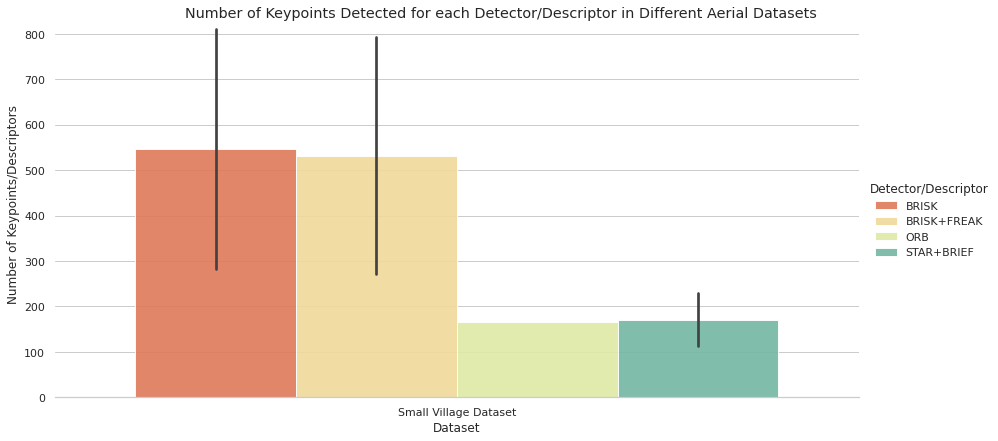

In [81]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_numkey_4, kind="bar",
    x="Dataset", y="Number of Keypoints", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=6, aspect=2
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Number of Keypoints/Descriptors")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Number of Keypoints Detected for each Detector/Descriptor in Different Aerial Datasets")

In [82]:
g.savefig(f'drive/MyDrive/Num_Kypoints_4_{Dataset}.png')

In [83]:
df_numkey_4.to_csv(f'drive/MyDrive/Num_Kypoints_4_{Dataset}.csv')

In [ ]:
#print(len(num_matches_agast))

Total Number of Matches Detected for each Detector+Descriptor

In [84]:
#df_match_15['Number of Total Matches'] =  num_matches_agast + num_matches_akaze + num_matches_brisk + num_matches_daisy + num_matches_fast + num_matches_freak + num_matches_gftt + num_matches_kaze + num_matches_mser + num_matches_orb + num_matches_rootsift + num_matches_sift + num_matches_briefstar + num_matches_superpoint+ num_matches_surf+ num_matches_surfsift
d = {'Dataset': [f'{Dataset}']*(num_detectors*(len_files-1)), 'Number of Total Matches': num_matches_brisk + num_matches_freak + num_matches_orb + num_matches_briefstar, 'Detector/Descriptor': ['BRISK']*(len_files-1) + ['BRISK+FREAK']*(len_files-1) + ['ORB']*(len_files-1) + ['STAR+BRIEF']*(len_files-1)  }
df_match_4 = pd.DataFrame(data=d)
df_match_4['Number of Total Matches'] = df_match_4['Number of Total Matches']/(len_files-1)

Text(0.5, 0.98, 'Total Number of Matches Detected for each Detector/Descriptor in Different Aerial Datasets')

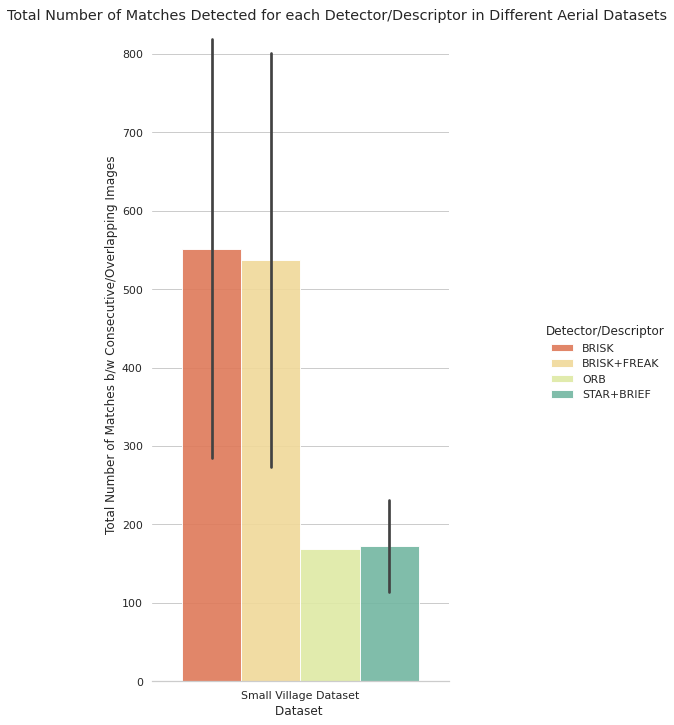

In [85]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_4, kind="bar",
    x="Dataset", y="Number of Total Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset ", "Total Number of Matches b/w Consecutive/Overlapping Images")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Total Number of Matches Detected for each Detector/Descriptor in Different Aerial Datasets")

In [86]:
g.savefig(f'drive/MyDrive/Num_Matches_4_{Dataset}.png')

In [ ]:
#df_match_16.to_csv('drive/MyDrive/Num_Matches_16.csv')

Total Number of Good/Robust Matches (NN+Lowe+RANSAC) Detected for each Detector+Descriptor

In [87]:
df_match_4['Number of Good Matches'] = num_good_matches_brisk + num_good_matches_freak + num_good_matches_orb + num_good_matches_briefstar
df_match_4['Number of Good Matches'] = df_match_4['Number of Good Matches']/(len_files-1)

Text(0.5, 0.98, 'Number of Good Matches (Lowe + RANSAC) Detected for each Detector/Descriptor in Different Aerial Datasets')

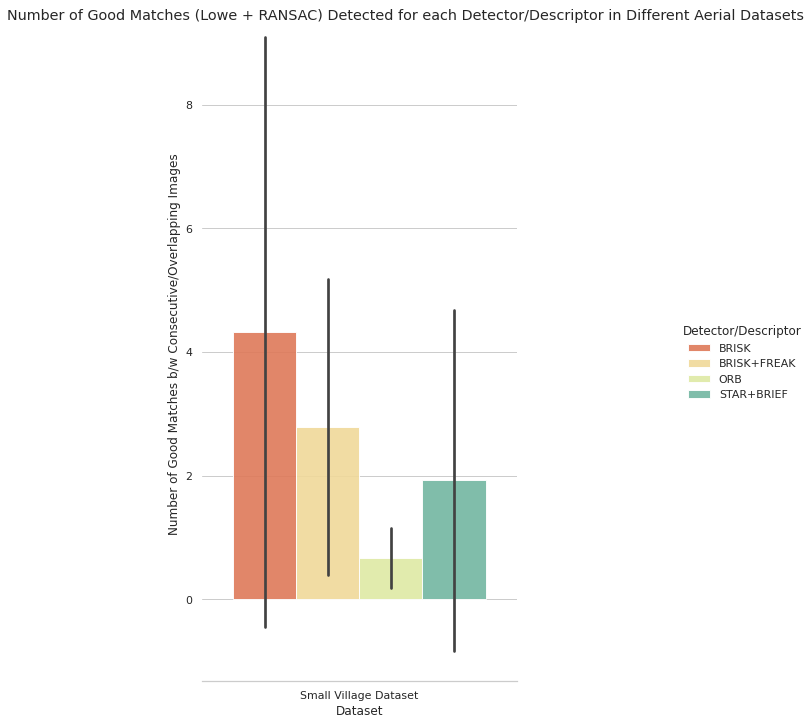

In [88]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_4, kind="bar",
    x="Dataset", y="Number of Good Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Number of Good Matches b/w Consecutive/Overlapping Images")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Number of Good Matches (Lowe + RANSAC) Detected for each Detector/Descriptor in Different Aerial Datasets")

In [89]:
g.savefig('drive/MyDrive/Num_Good_Matches_4.png')

In [ ]:
#df_match_16.to_csv('drive/MyDrive/Num_Good_Matches_16.csv')

Recall Rate for each Detector+Descriptor

In [90]:
df_match_4['Recall Rate of Matches'] = df_match_4['Number of Good Matches']/df_match_4['Number of Total Matches']

Text(0.5, 0.98, 'Recall Rate of Matches Detected (Good/Total) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)')

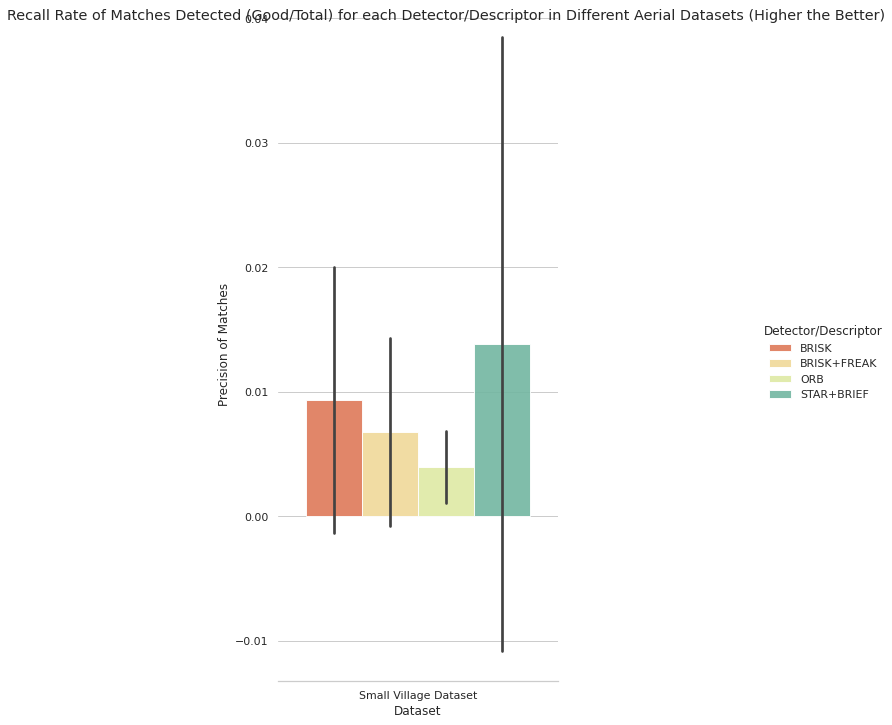

In [91]:
import seaborn as sns
sns.set_theme(style='whitegrid')


g = sns.catplot(
    data=df_match_4, kind="bar",
    x="Dataset", y="Recall Rate of Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Precision of Matches")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Recall Rate of Matches Detected (Good/Total) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)")

In [92]:
g.savefig('drive/MyDrive/Recall_Rate_Matches_4.png')

1-Precision Rate for each Detector+Descriptor

In [93]:
df_match_4['1 - Precision Rate of Matches'] = (df_match_4['Number of Total Matches'] - df_match_4['Number of Good Matches'])/df_match_4['Number of Total Matches']

Text(0.5, 0.98, '1 - Precision rate of Matches Detected (False/Total Matches) for each Detector/Descriptor in Different Aerial Datasets (Lower the Better)')

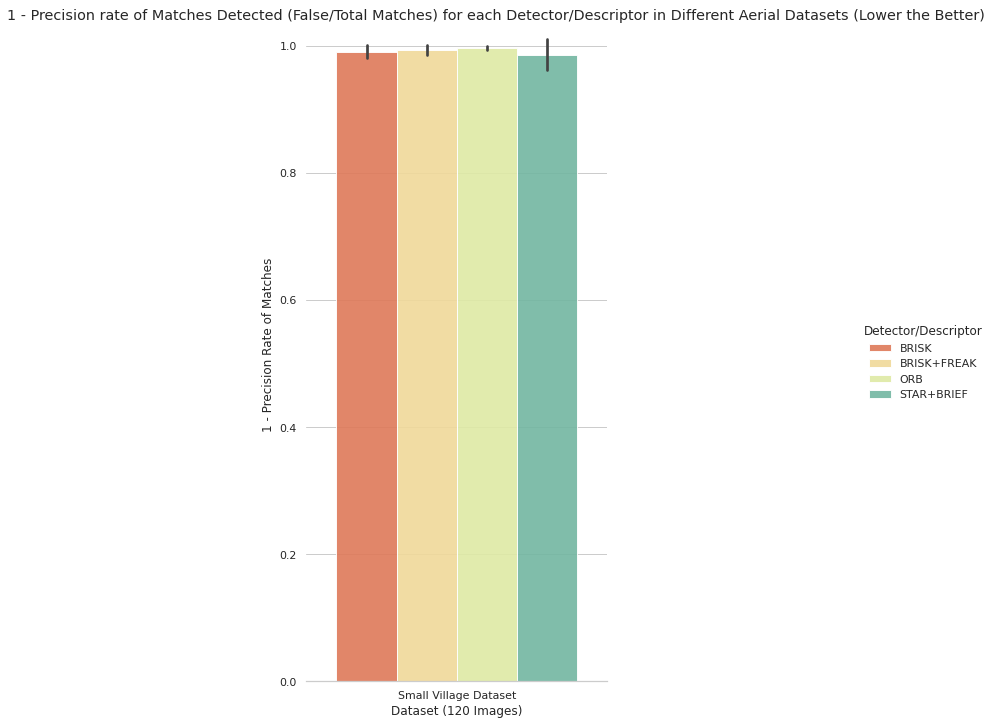

In [94]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_4, kind="bar",
    x="Dataset", y="1 - Precision Rate of Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset (120 Images)", "1 - Precision Rate of Matches")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("1 - Precision rate of Matches Detected (False/Total Matches) for each Detector/Descriptor in Different Aerial Datasets (Lower the Better)")

In [95]:
g.savefig('drive/MyDrive/One_minus_Precision_Rate_Matches_4.png')

F-Score for each Detector+Descriptor

In [96]:
df_match_4['F-Score'] = (2* (1 - df_match_4['1 - Precision Rate of Matches']) * df_match_4['Recall Rate of Matches'])/((1 - df_match_4['1 - Precision Rate of Matches']) + df_match_4['Recall Rate of Matches'])

Text(0.5, 0.98, 'F-Score of Matches Detected (2*P*R/P+R) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)')

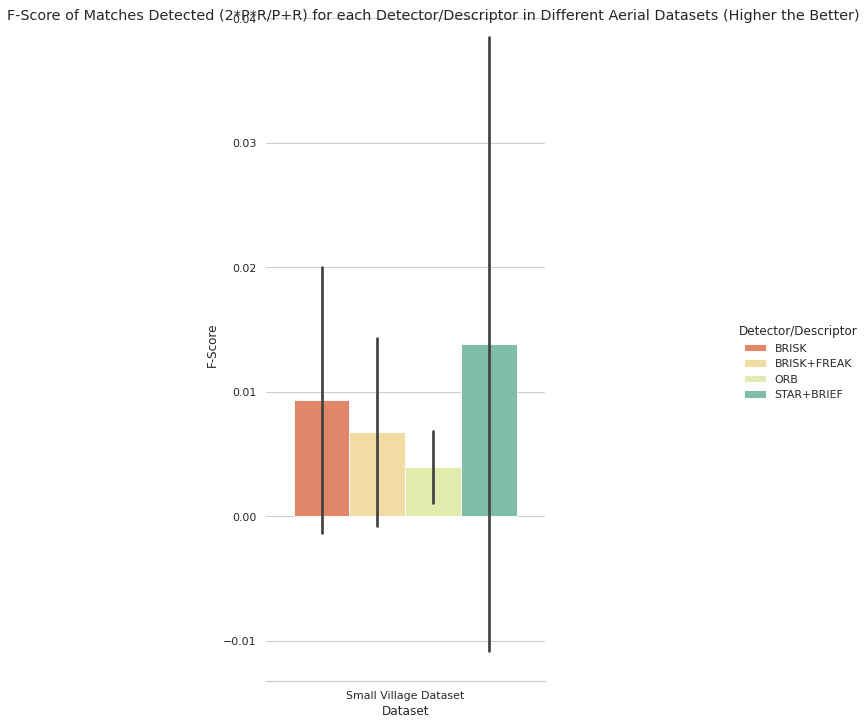

In [97]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_4, kind="bar",
    x="Dataset", y="F-Score", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "F-Score")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("F-Score of Matches Detected (2*P*R/P+R) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)")

In [98]:
g.savefig('drive/MyDrive/F_Score_Rate_Matches_4.png')

In [99]:
df_match_4.to_csv('drive/MyDrive/All_metrics_4.csv')

Time for each Detector+Descriptor

In [100]:
d = {'Dataset': [f'{Dataset}']*(num_detectors), 'Time': [time_all[3]] + [time_all[0]] + [time_all[2]] + [time_all[1]], 'Detector/Descriptor': ['BRISK']*(1) + ['BRISK+FREAK']*(1) +  ['ORB']*(1) + ['STAR+BRIEF']*(1) }
df_time_4 = pd.DataFrame(data=d)

In [101]:
print(df_time_4)

                 Dataset        Time Detector/Descriptor
0  Small Village Dataset  318.430913               BRISK
1  Small Village Dataset  317.297555         BRISK+FREAK
2  Small Village Dataset  324.275246                 ORB
3  Small Village Dataset  122.581066          STAR+BRIEF


Text(0.5, 0.98, 'Time taken during Feature Extraction by each Detector/Descriptor in Different Aerial Datasets (Lower the Better)')

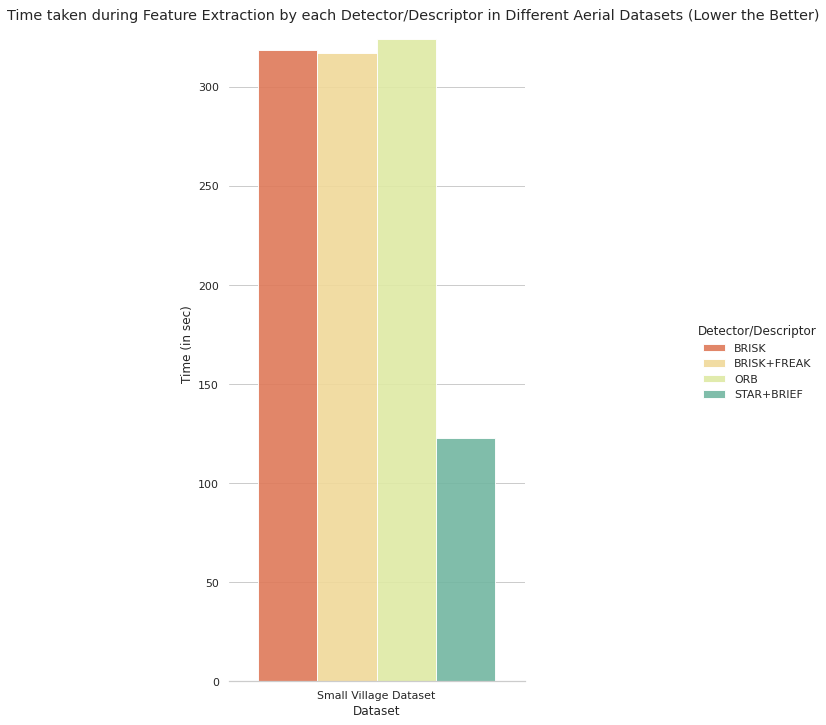

In [103]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_time_4, kind="bar",
    x="Dataset", y="Time", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Time (in sec)")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Time taken during Feature Extraction by each Detector/Descriptor in Different Aerial Datasets (Lower the Better)")

In [104]:
g.savefig('drive/MyDrive/Time_4.png')

In [106]:
df_time_4.to_csv('drive/MyDrive/Time_4.csv')

Stitching with CPU